In [24]:
import datasets as ds
import utils as ut
import models as md

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import skfuzzy as fuzz


# fairlearn
from fairlearn.postprocessing import ThresholdOptimizer
from xgboost import XGBClassifier
import fasttext

# libs 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import ShuffleSplit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1: Auditing with repsect to stereotypes 

In [25]:
dataset = ds.Dataset('nels')
dataset.split_train_test() 
print(dataset.x_train.shape, dataset.x_test.shape)

total students 12144
Limiting entries to two racial groups 3 n=1041 and 4 n=7908
remaining students 8949
(6264, 812) (1343, 812)


In [26]:
# base predictor 
clf = LogisticRegression()
clf.fit(dataset.x_train, dataset.y_train)

p = clf.predict_proba(dataset.x_test)[:, 1]
p_acc = accuracy_score(dataset.y_test, p > 0.5)

mask = dataset.g_test == 1
white_acc = accuracy_score(dataset.y_test[mask], p[mask] > 0.5)
black_acc = accuracy_score(dataset.y_test[~mask], p[~mask] > 0.5)

print(f"base clf acc: {p_acc:.3f} male acc: {white_acc:.3f} female acc: {black_acc:.3f}")

base clf acc: 0.829 male acc: 0.828 female acc: 0.840


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
abs_coeff = np.abs(g_clf.coef_.round(1)).flatten()
coeff = g_clf.coef_.round(1).flatten()
coeff_sorted = coeff[np.argsort(abs_coeff)[::-1]]
abs_coeff_sorted = abs_coeff[np.argsort(abs_coeff)[::-1]]
print(coeff_sorted[:10])
dataset.x_labels[np.argsort(abs_coeff)[::-1][:10]]

[ 1.4  1.1  1.1 -1.1  1.  -1.  -0.9  0.9  0.8 -0.7]


Index(['G8MINOR_0', 'F22XSSTD', 'F12XSSTD', 'G8MINOR_7', 'F2ROSO_C',
       'G8REGON_3', 'G8MINOR_6', 'G8REGON_4', 'F22XMSTD', 'G8MINOR_4'],
      dtype='object')

Top 10 Contributers to race: 
- 'G8MINOR_0' # PERCENT MINORITY IN SCHOOL
- 'F22XSSTD' # SCIENCE STANDARDIZED SCORE
- 'F12XSSTD' #SCIENCE STANDARDIZED SCORE
- 'G8MINOR_7'  # PERCENT MINORITY IN SCHOOL
- 'F2ROSO_C' #UNITS IN OTHER SOC. STUDIES (NAEP)
- 'G8REGON_3' #COMPOSITE GEOGRAPHIC REGION OF SCHOOL
- 'G8MINOR_6' # PERCENT MINORITY IN SCHOOL
- 'G8REGON_4' # COMPOSITE GEOGRAPHIC REGION OF SCHOOL
- 'F22XMSTD' #MATHEMATICS STANDARDIZED SCORE 
- 'G8MINOR_4' #  PERCENT MINORITY IN SCHOOL

In [29]:
for n_dim in [2,4,8, 16, 32, 64, 128, 300]:
    pca = PCA(n_components=n_dim)
    x = pca.fit_transform(dataset.x_train)
    x_test = pca.transform(dataset.x_test)
    g_clf_pca = LogisticRegression()
    g_clf_pca.fit(x, dataset.g_train)
    print(f"g dim {n_dim} acc: {accuracy_score(dataset.g_test, 
                                                  g_clf_pca.predict(x_test)):.3f}")
    print(g_clf_pca.predict(x_test).mean())

g dim 2 acc: 0.879
1.0
g dim 4 acc: 0.879
1.0
g dim 8 acc: 0.879
1.0
g dim 16 acc: 0.885
0.9806403574087863
g dim 32 acc: 0.902
0.939687267311988
g dim 64 acc: 0.918
0.9218168279970216
g dim 128 acc: 0.922
0.9166046165301563
g dim 300 acc: 0.914
0.9054355919583023


In [30]:
standarized_test_features = [
'F12XRSTD',
'F12XMSTD',
'F12XSSTD',
'F12XHSTD',
'F22XRSTD',
'F22XMSTD',	
'F22XSSTD',	
'F22XHSTD',
'BY2XRSTD',
'BY2XMSTD',	
'BY2XSSTD',	
'BY2XHSTD',	
]
freelunch_minority = [
    'G8MINOR_0',
     'G8MINOR_1',
     'G8MINOR_2',
     'G8MINOR_3',
     'G8MINOR_4',
     'G8MINOR_5',
     'G8MINOR_6',
     'G8MINOR_7',
     'G8MINOR_998',
     'G8MINOR_999', 
    'G8LUNCH_0',
     'G8LUNCH_1',
     'G8LUNCH_2',
     'G8LUNCH_3',
     'G8LUNCH_4',
     'G8LUNCH_5',
     'G8LUNCH_6',
     'G8LUNCH_7',
     'G8LUNCH_998',
     'G8LUNCH_999'
    
]

In [31]:
# use 64 dim
n_dim = 32
pca = PCA(n_components=n_dim)
dataset.x_pca_train = pca.fit_transform(dataset.x_train)
dataset.x_pca_test = pca.transform(dataset.x_test)

def find_means(features: np.array, group_labels: np.array): 
    ## assume group labels are 1 and 0 
    group1 = features[group_labels]
    group2 = features[~group_labels]
    #print(group1.mean(axis=0).shape)
    means = np.stack([group1.mean(axis=0), group2.mean(axis=0)])
    return means

In [33]:
# stereotype predictors:
# 1) overall pg
all_pg_clf = LogisticRegression()
all_pg_clf.fit(dataset.x_train, dataset.g_train)
all_pg = all_pg_clf.predict_proba(dataset.x_test)[:, 1]

# 2) harmful features
feature_indices = np.array([list(dataset.x_labels).index(key) for key in freelunch_minority if key in dataset.x_labels])
#feature_indices = np.array([list(dataset.x_labels).index(key) for key in standarized_test_features if key in dataset.x_labels])
dataset.x_harmful_train = dataset.x_train[:, feature_indices]
dataset.x_harmful_test = dataset.x_test[:, feature_indices]

test_pg_clf_base = LogisticRegression() 
test_pg_clf_base = test_pg_clf_base.fit(dataset.x_harmful_train, dataset.g_train)
test_pg_clf = md.HarmfulFeaturesClassifier(base_clf=test_pg_clf_base, feature_ind=feature_indices)
test_pg = test_pg_clf.predict_proba(dataset.x_test)[:, 1]
print(test_pg.mean())

# 3) clustering 
cntr = find_means(dataset.x_pca_train, dataset.g_train)
cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)
cluster_pg = cluster_pg_clf.predict_proba(dataset.x_test)[:, 1]

0.8831953558585398


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
# evaluate stereotype predictors
# clf

results = {} 
p = clf.predict_proba(dataset.x_test)[:, 1]
for pg, name in zip([all_pg, test_pg, cluster_pg], 
                    ['all_pg', 'harm_pg', 'cluster_pg']): 
    print(name)
    # group prediction accuracy
    print(f"acc {accuracy_score(dataset.g_test, pg>0.5):.3f}")
    print('cov(y, pg)', ut.emp_cov(dataset.y_test, pg))
    print('corr(y, pg)', stats.pearsonr(dataset.y_test, pg))
    print('cov(p, pg)', ut.emp_cov(p, pg))
    print('corr(p, pg)', stats.pearsonr(p, pg))
    results[name] = {} 
    results[name]['DP'] = ut.emp_cov(p, pg)
    results[name]['DP_corr'] = stats.pearsonr(p, pg)


    mask = dataset.y_test == 1 
    print('cov(p, pg | y=1)', ut.emp_cov(p[mask], pg[mask]))
    print('corr(p, pg | y=1)', stats.pearsonr(p[mask], pg[mask]))
    results[name]['EO'] = ut.emp_cov(p[mask], pg[mask])
    results[name]['EO_corr'] = stats.pearsonr(p[mask], pg[mask])

    results[name]['MA'] = np.abs(ut.emp_cov(p, pg) - ut.emp_cov(dataset.y_test, pg))

all_pg
acc 0.908
cov(y, pg) 0.018279172046173374
corr(y, pg) PearsonRResult(statistic=0.14410099921792272, pvalue=1.1350987285352354e-07)
cov(p, pg) 0.015579629824787326
corr(p, pg) PearsonRResult(statistic=0.16378012975584835, pvalue=1.5674771953667904e-09)
cov(p, pg | y=1) 0.00666085211872669
corr(p, pg | y=1) PearsonRResult(statistic=0.127601045746607, pvalue=0.00438340483706314)
harm_pg
acc 0.911
cov(y, pg) 0.013414631770374842
corr(y, pg) PearsonRResult(statistic=0.14599879546841818, pvalue=7.690148653625169e-08)
cov(p, pg) 0.011256532486956855
corr(p, pg) PearsonRResult(statistic=0.16336866138002007, pvalue=1.7239136966074778e-09)
cov(p, pg | y=1) 0.0058039016726874545
corr(p, pg | y=1) PearsonRResult(statistic=0.14598148698056965, pvalue=0.0010995066841035096)
cluster_pg
acc 0.845
cov(y, pg) 0.005527709898903231
corr(y, pg) PearsonRResult(statistic=0.14623678008025243, pvalue=7.321098607691256e-08)
cov(p, pg) 0.005182195938735273
corr(p, pg) PearsonRResult(statistic=0.1828179385

## Demographic Parity

In [35]:
DP_plot = [] 

In [38]:
# DP Post Processing
dataset = dataset

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

i = 0 

for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)


    # 1) stereotype associations
    all_pg_clf = LogisticRegression()
    all_pg_clf.fit(x_train_sub, g_train_sub)

    # 2) harmful stereotypes
    test_pg_clf_base = LogisticRegression() 
    test_pg_clf_base = test_pg_clf_base.fit(x_train_sub[:, feature_indices], g_train_sub)
    test_pg_clf = md.HarmfulFeaturesClassifier(base_clf=test_pg_clf_base, feature_ind=feature_indices)
    
    # 2c) clustering 
    cntr = find_means(pca.transform(x_train_sub), g_train_sub)
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)


    pg_dict = {'all_pg': all_pg_clf,
               'harm_pg': test_pg_clf,
               'cluster_pg': cluster_pg_clf}
    
    
    prev_results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=dataset.x_test, 
                            y=dataset.y_test, 
                            g=dataset.g_test)

    clfs = [
        ([all_pg_clf], r'$\hat{p}_g^{(all)}$'), 
        ([test_pg_clf], r'$\hat{p}_g^{(harm)}$'), 
        ([cluster_pg_clf], r'$\hat{p}_g^{(FCM)}$'), 
        ([all_pg_clf, test_pg_clf, cluster_pg_clf], r'$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$'),
    ]
    

    for clf_list, clf_list_name in clfs: 
        # 2. Refit models
        clf = LogisticRegression()
        clf.fit(x_train_sub, y_train_sub)
    
        
        if clf_list_name == r'$\hat{p}_g^{(all)}$': 
            for key in pg_dict.keys(): 
                DP_plot.append({
                    'eval_pg': key, 
                    'intervention_pg': 'None', 
                    'value': prev_results[f'cov(p, {key})'], 
                    'run': i, 
                    'acc': prev_results['accuracy'], 
                })
        
    
        
        c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
        md.fit_dp_pg_multi(x=x_train_sub, 
                       multi_clf=c_post_processed, 
                       alpha=1e-4,
                        max_iter=100)
        
        results = ut.results_summary(p=c_post_processed.predict_proba_1d(dataset.x_test), 
                                pg_dict=pg_dict, 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
        for key in pg_dict.keys(): 
            DP_plot.append({
                'eval_pg': key, 
                'intervention_pg': f'DP wrt. {clf_list_name}', 
                'value': results[f'cov(p, {key})'], 
                'acc': results['accuracy'], 
                'run': i, 
            })

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

new iteration


 10%|█████▉                                                     | 10/100 [00:00<00:00, 98.67it/s]

0.017428232286394747
0.016355175802960135
0.015446124375193564
0.014630453887701123
0.013884887086536162
0.013196151332623664
0.012556023826950376
0.011959089796652687
0.011400354201056452
0.010874849476906234
0.010381271186632159
0.009916834724721822
0.009481419805287794
0.00907015773644333
0.008680603328480084
0.008310445127780425
0.00795868726333326
0.007624026725102968
0.007306734432261249


 20%|███████████▊                                               | 20/100 [00:00<00:01, 53.89it/s]

0.007006536988101056
0.006720926055714506
0.006449196935934977
0.006190815946704184
0.005945345580334232
0.005711259059578412


 27%|███████████████▉                                           | 27/100 [00:00<00:01, 39.41it/s]

0.005487190905105114
0.005273129961465132
0.005068711348482641
0.004873634380297654
0.0046873502168639745


 32%|██████████████████▉                                        | 32/100 [00:00<00:02, 32.50it/s]

0.004509023275775331
0.00433798731605308
0.0041743798672028735
0.004017741591409189


 36%|█████████████████████▏                                     | 36/100 [00:01<00:02, 27.82it/s]

0.0038673047724962326
0.0037229795213076277
0.003584494739879667
0.003451798670952994


 40%|███████████████████████▌                                   | 40/100 [00:01<00:02, 23.85it/s]

0.0033242995097759946
0.003201740215127646
0.003084393257410354
0.0029717331439776417


 43%|█████████████████████████▎                                 | 43/100 [00:01<00:02, 21.52it/s]

0.002863374348138686
0.0027591685491260482
0.002659017672317257


 46%|███████████████████████████▏                               | 46/100 [00:01<00:02, 19.47it/s]

0.0025628222847282945
0.002470288251194346
0.002381328754770357


 49%|████████████████████████████▉                              | 49/100 [00:01<00:02, 17.64it/s]

0.0022958057994794247
0.002213385342385697


 51%|██████████████████████████████                             | 51/100 [00:02<00:03, 15.95it/s]

0.0021342007500896295


 53%|███████████████████████████████▎                           | 53/100 [00:02<00:03, 15.13it/s]

0.002057935490088705
0.001984660497971599
0.0019142433231683304


 55%|████████████████████████████████▍                          | 55/100 [00:02<00:03, 14.33it/s]

0.0018464630486900316
0.0017811932057274276


 57%|█████████████████████████████████▋                         | 57/100 [00:02<00:03, 13.65it/s]

0.0017183234287740706


 59%|██████████████████████████████████▊                        | 59/100 [00:02<00:03, 13.03it/s]

0.0016577660259914865
0.0015994565703517912
0.0015432730656820932


 61%|███████████████████████████████████▉                       | 61/100 [00:02<00:03, 12.42it/s]

0.0014891778069586591
0.0014370261591777132


 63%|█████████████████████████████████████▏                     | 63/100 [00:03<00:03, 11.96it/s]

0.001386854692302109


 65%|██████████████████████████████████████▎                    | 65/100 [00:03<00:03, 11.53it/s]

0.0013385449607343012
0.0012920531989166263
0.001247306248984714


 67%|███████████████████████████████████████▌                   | 67/100 [00:03<00:02, 11.16it/s]

0.0012042074988918925
0.0011626666551223966


 69%|████████████████████████████████████████▋                  | 69/100 [00:03<00:02, 10.80it/s]

0.0011225933062334952
0.001083941109366834


 71%|█████████████████████████████████████████▉                 | 71/100 [00:03<00:02, 10.47it/s]

0.0010466391608115082
0.0010106588459150815


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:02, 10.17it/s]

0.0009760290547803777
0.0009426150234481154


 75%|████████████████████████████████████████████▎              | 75/100 [00:04<00:02,  9.75it/s]

0.0009103451865365505


 76%|████████████████████████████████████████████▊              | 76/100 [00:04<00:02,  9.60it/s]

0.0008792290051663712


 77%|█████████████████████████████████████████████▍             | 77/100 [00:04<00:02,  9.46it/s]

0.0008492077507272656


 78%|██████████████████████████████████████████████             | 78/100 [00:04<00:02,  9.28it/s]

0.0008202602360552384


 79%|██████████████████████████████████████████████▌            | 79/100 [00:04<00:02,  9.13it/s]

0.0007923214968905773


 80%|███████████████████████████████████████████████▏           | 80/100 [00:04<00:02,  8.98it/s]

0.0007653639116244632


 81%|███████████████████████████████████████████████▊           | 81/100 [00:04<00:02,  8.80it/s]

0.0007393379048887229


 82%|████████████████████████████████████████████████▍          | 82/100 [00:05<00:02,  8.14it/s]

0.0007142093161589898


 83%|████████████████████████████████████████████████▉          | 83/100 [00:05<00:02,  8.04it/s]

0.000689969333197365


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:05<00:02,  7.64it/s]

0.0006665755439854847


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:05<00:01,  7.77it/s]

0.0006439925364140256


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:05<00:01,  7.82it/s]

0.0006222096916382707


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:05<00:01,  7.77it/s]

0.0006012016992959921


 88%|███████████████████████████████████████████████████▉       | 88/100 [00:05<00:01,  7.29it/s]

0.0005809181466859523


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:06<00:01,  7.38it/s]

0.0005613358934338335


 90%|█████████████████████████████████████████████████████      | 90/100 [00:06<00:01,  7.44it/s]

0.0005424089588279481


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:06<00:01,  7.45it/s]

0.0005241279624188799


 92%|██████████████████████████████████████████████████████▎    | 92/100 [00:06<00:01,  6.63it/s]

0.0005064889976854939


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:06<00:01,  6.77it/s]

0.0004894579951281231


 94%|███████████████████████████████████████████████████████▍   | 94/100 [00:06<00:00,  6.91it/s]

0.00047299967045602543


 95%|████████████████████████████████████████████████████████   | 95/100 [00:06<00:00,  7.00it/s]

0.00045709476702478766


 96%|████████████████████████████████████████████████████████▋  | 96/100 [00:07<00:00,  7.02it/s]

0.00044172467570644837


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:07<00:00,  6.69it/s]

0.0004268798927396816


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [00:07<00:00,  6.77it/s]

0.0004125405118372609


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:07<00:00,  6.86it/s]

0.00039870385207473215


100%|██████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.99it/s]

0.00038533772580186254



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 25%|██████████████▌                                           | 25/100 [00:00<00:00, 244.79it/s]

0.01119606560095959
0.010824078171663561
0.01049589621690155
0.010190876011372453
0.009901180731809517
0.009624357130710273
0.009362376688957508
0.009112086940023741
0.008872141299961615
0.008642089451457736
0.008421353504453524
0.008208775866822459
0.008003091901260553
0.007805285515635079
0.007614010864641358
0.00742870676718308
0.007247924785984912
0.007073469500885881
0.006904752884013569
0.006741008609744207
0.006581798835106867
0.006427567443849607
0.006278179113425348
0.0061330452297210245
0.005992070482108589
0.00585557768600141
0.005723729980863766
0.005596243214290959
0.005471959436272278
0.005350628145264725
0.005233251713801419
0.005119014038450193
0.005008188267292729
0.004900415665963929
0.004794981774925089
0.004692338787636978
0.00459234096642004


 50%|█████████████████████████████                             | 50/100 [00:00<00:00, 142.97it/s]

0.004495094057547785
0.00440058880307087
0.0043086144189319175
0.004218807615622804
0.0041308066260810974
0.004044898896687985
0.003961223627935004
0.003879720371220387
0.003800069099548627
0.0037222852088967954
0.0036463677535926923
0.003572225534146989
0.003499604835583048
0.0034287151405897986
0.0033595464819162623
0.003292051073878916
0.0032260636044387225
0.0031615482211753807
0.0030986168429679045


 67%|██████████████████████████████████████▊                   | 67/100 [00:00<00:00, 109.04it/s]

0.003037331836252691
0.002977428861698878
0.0029189651573875448
0.002861800073508741
0.002806006863186744
0.0027514490623805708
0.002698111521640725
0.0026459409529288836
0.002594986097587826
0.0025450749891695445
0.0024963599795367764
0.00244891517180728
0.002402565576682453
0.0023572485331969195
0.002312934257196066


 80%|███████████████████████████████████████████████▏           | 80/100 [00:00<00:00, 88.97it/s]

0.0022696030637192207
0.0022272774665798726
0.002185836505120566
0.002145299426176241
0.002105535409273867
0.0020666563350381075
0.002028679125939138
0.0019914541672868525
0.001954993192468135
0.0019191706529400512
0.0018840311935422924
0.0018496101078292076


 90%|█████████████████████████████████████████████████████      | 90/100 [00:00<00:00, 77.73it/s]

0.0018159766411912554
0.0017830591878657688
0.0017508597982132457
0.0017193878802156469
0.0016885497907648001
0.0016583104042270811
0.0016287672727396687
0.001599829074878843
0.0015714411508878448
0.0015436618311607455
0.0015164244253275058


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.04it/s]

0.0014896870502903602
0.0014634303564969127
0.0014377338573310526
0.0014125366341941913
0.0013878260231035785
0.0013636253669005987



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  4%|██▍                                                         | 4/100 [00:00<00:02, 34.21it/s]

0.018167396477819193
0.01782482182272786
0.01746393318669888
0.017102851080840198
0.016747769838147554


  8%|████▊                                                       | 8/100 [00:00<00:04, 18.66it/s]

0.0163995032027455
0.016057616880100337
0.015723649976728198


 11%|██████▍                                                    | 11/100 [00:00<00:06, 14.02it/s]

0.015396899186519469
0.015076841068435287
0.014764611091008746


 13%|███████▋                                                   | 13/100 [00:00<00:07, 11.67it/s]

0.014460757060022025
0.014164954517865806


 15%|████████▊                                                  | 15/100 [00:01<00:09,  8.97it/s]

0.013875950195909325
0.013594182996337021


 17%|██████████                                                 | 17/100 [00:01<00:10,  7.94it/s]

0.013319590986991476
0.01305206911109051


 19%|███████████▏                                               | 19/100 [00:01<00:11,  6.85it/s]

0.012789960993846947
0.012533666437336702


 20%|███████████▊                                               | 20/100 [00:02<00:13,  5.97it/s]

0.012282766124335306


 22%|████████████▉                                              | 22/100 [00:02<00:14,  5.47it/s]

0.012037611266548773
0.011798155884127224


 23%|█████████████▌                                             | 23/100 [00:02<00:15,  5.00it/s]

0.011564317440104182


 24%|██████████████▏                                            | 24/100 [00:03<00:16,  4.61it/s]

0.011335585655234008


 25%|██████████████▊                                            | 25/100 [00:03<00:16,  4.54it/s]

0.011111697187090642


 26%|███████████████▎                                           | 26/100 [00:03<00:17,  4.14it/s]

0.010892611002437927


 27%|███████████████▉                                           | 27/100 [00:03<00:18,  4.04it/s]

0.010677690518506358


 28%|████████████████▌                                          | 28/100 [00:04<00:17,  4.02it/s]

0.010468209948854027


 29%|█████████████████                                          | 29/100 [00:04<00:17,  3.97it/s]

0.010263812017218737


 30%|█████████████████▋                                         | 30/100 [00:04<00:17,  3.89it/s]

0.010063982877073054


 31%|██████████████████▎                                        | 31/100 [00:05<00:18,  3.74it/s]

0.0098685649313991


 32%|██████████████████▉                                        | 32/100 [00:05<00:19,  3.47it/s]

0.009677581493134123


 33%|███████████████████▍                                       | 33/100 [00:05<00:24,  2.74it/s]

0.009491002131959103


 34%|████████████████████                                       | 34/100 [00:06<00:24,  2.66it/s]

0.009308709002307475


 35%|████████████████████▋                                      | 35/100 [00:06<00:24,  2.64it/s]

0.009130292257059094


 36%|█████████████████████▏                                     | 36/100 [00:07<00:24,  2.65it/s]

0.008955853743735344


 37%|█████████████████████▊                                     | 37/100 [00:07<00:25,  2.49it/s]

0.008785189922842645


 38%|██████████████████████▍                                    | 38/100 [00:07<00:23,  2.59it/s]

0.008618174911301667


 39%|███████████████████████                                    | 39/100 [00:08<00:23,  2.62it/s]

0.008455366772577612


 40%|███████████████████████▌                                   | 40/100 [00:08<00:22,  2.61it/s]

0.008296625014315167


 41%|████████████████████████▏                                  | 41/100 [00:09<00:22,  2.57it/s]

0.00814123415132232


 42%|████████████████████████▊                                  | 42/100 [00:09<00:22,  2.54it/s]

0.007989586740446112


 43%|█████████████████████████▎                                 | 43/100 [00:09<00:22,  2.53it/s]

0.007841047672699317


 44%|█████████████████████████▉                                 | 44/100 [00:10<00:23,  2.35it/s]

0.007695780073757054


 45%|██████████████████████████▌                                | 45/100 [00:10<00:24,  2.29it/s]

0.0075536578680297055


 46%|███████████████████████████▏                               | 46/100 [00:11<00:23,  2.26it/s]

0.007414718402227421


 47%|███████████████████████████▋                               | 47/100 [00:11<00:22,  2.31it/s]

0.007278962842714555


 48%|████████████████████████████▎                              | 48/100 [00:12<00:22,  2.28it/s]

0.0071461645304368914


 49%|████████████████████████████▉                              | 49/100 [00:12<00:24,  2.10it/s]

0.007016278580601027


 50%|█████████████████████████████▌                             | 50/100 [00:13<00:24,  2.07it/s]

0.006889343721440565


 51%|██████████████████████████████                             | 51/100 [00:13<00:23,  2.09it/s]

0.006765274198004632


 52%|██████████████████████████████▋                            | 52/100 [00:14<00:23,  2.05it/s]

0.006643875978826083


 53%|███████████████████████████████▎                           | 53/100 [00:14<00:25,  1.85it/s]

0.006524838810484384


 54%|███████████████████████████████▊                           | 54/100 [00:15<00:25,  1.81it/s]

0.006408402290104754


 55%|████████████████████████████████▍                          | 55/100 [00:16<00:29,  1.51it/s]

0.00629451819792714


 56%|█████████████████████████████████                          | 56/100 [00:16<00:29,  1.50it/s]

0.006183318334225471


 57%|█████████████████████████████████▋                         | 57/100 [00:17<00:29,  1.45it/s]

0.006074558366635557


 58%|██████████████████████████████████▏                        | 58/100 [00:18<00:30,  1.37it/s]

0.005967880914728822


 59%|██████████████████████████████████▊                        | 59/100 [00:19<00:34,  1.19it/s]

0.0058633414054806675


 60%|███████████████████████████████████▍                       | 60/100 [00:20<00:33,  1.21it/s]

0.005760800317702645


 61%|███████████████████████████████████▉                       | 61/100 [00:21<00:32,  1.19it/s]

0.005660342635038103


 62%|████████████████████████████████████▌                      | 62/100 [00:22<00:35,  1.07it/s]

0.00556216692763845


 63%|█████████████████████████████████████▏                     | 63/100 [00:23<00:34,  1.08it/s]

0.005466255826835454


 64%|█████████████████████████████████████▊                     | 64/100 [00:24<00:30,  1.17it/s]

0.005372085069992671


 65%|██████████████████████████████████████▎                    | 65/100 [00:24<00:27,  1.26it/s]

0.0052794803936152815


 66%|██████████████████████████████████████▉                    | 66/100 [00:26<00:33,  1.01it/s]

0.005188686510321236


 67%|███████████████████████████████████████▌                   | 67/100 [00:27<00:33,  1.00s/it]

0.005100424190053194


 68%|████████████████████████████████████████                   | 68/100 [00:28<00:32,  1.01s/it]

0.00501386472557485


 69%|████████████████████████████████████████▋                  | 69/100 [00:29<00:34,  1.12s/it]

0.004929032899441783


 70%|█████████████████████████████████████████▎                 | 70/100 [00:31<00:36,  1.20s/it]

0.004846035098985442


 71%|█████████████████████████████████████████▉                 | 71/100 [00:32<00:34,  1.18s/it]

0.004764557617589284


 72%|██████████████████████████████████████████▍                | 72/100 [00:33<00:33,  1.18s/it]

0.004684632239729981


 73%|███████████████████████████████████████████                | 73/100 [00:34<00:31,  1.16s/it]

0.00460627728436434


 74%|███████████████████████████████████████████▋               | 74/100 [00:35<00:29,  1.12s/it]

0.00452942723939959


 75%|████████████████████████████████████████████▎              | 75/100 [00:36<00:28,  1.12s/it]

0.004454190890500393


 76%|████████████████████████████████████████████▊              | 76/100 [00:37<00:28,  1.20s/it]

0.004380467885921953


 77%|█████████████████████████████████████████████▍             | 77/100 [00:39<00:28,  1.25s/it]

0.0043081625153450495


 78%|██████████████████████████████████████████████             | 78/100 [00:40<00:28,  1.31s/it]

0.004237141321309889


 79%|██████████████████████████████████████████████▌            | 79/100 [00:42<00:31,  1.52s/it]

0.0041674807645892264


 80%|███████████████████████████████████████████████▏           | 80/100 [00:44<00:31,  1.56s/it]

0.004099332070773765


 81%|███████████████████████████████████████████████▊           | 81/100 [00:46<00:30,  1.62s/it]

0.004032575973931137


 82%|████████████████████████████████████████████████▍          | 82/100 [00:47<00:29,  1.64s/it]

0.0039670053977782106


 83%|████████████████████████████████████████████████▉          | 83/100 [00:49<00:28,  1.70s/it]

0.0039027174386232714


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:51<00:26,  1.67s/it]

0.003839681090083002


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:53<00:26,  1.75s/it]

0.00377786378591552


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:54<00:21,  1.55s/it]

0.003717213657286119


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:55<00:18,  1.44s/it]

0.00365790388771862


 88%|███████████████████████████████████████████████████▉       | 88/100 [00:56<00:15,  1.32s/it]

0.003599760344275608


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:57<00:13,  1.20s/it]

0.003542781832378498


 90%|█████████████████████████████████████████████████████      | 90/100 [00:58<00:10,  1.10s/it]

0.0034871380405366976


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:59<00:09,  1.04s/it]

0.0034325029395906224


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:00<00:08,  1.05s/it]

0.0033788622890963166


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:01<00:06,  1.00it/s]

0.003326181857134637


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:02<00:06,  1.13s/it]

0.0032744969322490943


 95%|████████████████████████████████████████████████████████   | 95/100 [01:04<00:07,  1.47s/it]

0.0032237967520698614


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:06<00:06,  1.63s/it]

0.0031739560463947343


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:08<00:05,  1.74s/it]

0.003124815686378244


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:10<00:03,  1.82s/it]

0.0030764470770976537


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:12<00:01,  1.83s/it]

0.003029005487713425


100%|██████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]

0.002982511089371179



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:07, 13.93it/s]

0.017428232286394747
0.010618245242819352
0.017717313802648495
0.01592330714423735
0.00976251576298071
0.01684175783168055
0.014638162488426157
0.009004320217799273
0.016005515355584747
0.013495994349679344


  4%|██▍                                                         | 4/100 [00:00<00:18,  5.20it/s]

0.008317928175083703
0.01521269698298712
0.012467410853716276
0.007696647061886024


  5%|███                                                         | 5/100 [00:01<00:21,  4.37it/s]

0.014470524559899504
0.01153890016837212
0.007130363811085114


  6%|███▌                                                        | 6/100 [00:01<00:38,  2.46it/s]

0.013776387387365096
0.01068821374767273
0.0066072924242650075


  7%|████▏                                                       | 7/100 [00:02<00:42,  2.17it/s]

0.013126386527839609
0.009909389964309744
0.006136011073154192


  8%|████▊                                                       | 8/100 [00:02<00:41,  2.19it/s]

0.01251976265515388
0.009201270009689448
0.005704559406845105


  9%|█████▍                                                      | 9/100 [00:03<00:42,  2.13it/s]

0.01194884185736933
0.008551748495784826
0.0053102016456179025


 10%|█████▉                                                     | 10/100 [00:04<00:49,  1.83it/s]

0.01141370367859456
0.007956541053230334
0.0049469782220891365


 11%|██████▍                                                    | 11/100 [00:04<00:55,  1.60it/s]

0.01091477794639597
0.007404641637651664
0.004611281868209076


 12%|███████                                                    | 12/100 [00:05<00:57,  1.54it/s]

0.010448400086379784
0.0068971326388804
0.004302654635550607


 13%|███████▋                                                   | 13/100 [00:06<01:02,  1.39it/s]

0.010010553776990238
0.00642890270936696
0.0040172197721801365


 14%|████████▎                                                  | 14/100 [00:07<01:04,  1.33it/s]

0.009600430588508868
0.005996597676387238
0.0037545775158265935


 15%|████████▊                                                  | 15/100 [00:08<01:11,  1.18it/s]

0.009215640417603591
0.005600309303993772
0.0035142228050635163


 16%|█████████▍                                                 | 16/100 [00:09<01:16,  1.10it/s]

0.008853729417312549
0.005234624470845496
0.003291727658556862


 17%|██████████                                                 | 17/100 [00:10<01:20,  1.03it/s]

0.008516035995475736
0.004894753816209356
0.003085625735600879


 18%|██████████▌                                                | 18/100 [00:12<01:31,  1.11s/it]

0.008199159840632785
0.0045764519611467686
0.002894692552014541


 19%|███████████▏                                               | 19/100 [00:13<01:43,  1.28s/it]

0.007901376584174351
0.004280309457170923
0.0027190065846446664


 20%|███████████▊                                               | 20/100 [00:15<01:59,  1.50s/it]

0.007620352800003147
0.004004596895542722
0.002555299804455565


 21%|████████████▍                                              | 21/100 [00:16<01:42,  1.29s/it]

0.007354278941923817
0.003748943414347319
0.00240231995578353


 22%|████████████▉                                              | 22/100 [00:17<01:32,  1.18s/it]

0.0071016385369599986
0.0035111819893623697
0.0022599861192086233


 23%|█████████████▌                                             | 23/100 [00:18<01:28,  1.15s/it]

0.006862942333709528
0.0032887805036086607
0.0021262515739602925


 24%|██████████████▏                                            | 24/100 [00:19<01:24,  1.12s/it]

0.006636858271187332
0.0030798056892506237
0.0020000189595891934


 25%|██████████████▊                                            | 25/100 [00:20<01:17,  1.03s/it]

0.00642247192673351
0.0028841073930189727
0.0018802770137973498


 26%|███████████████▎                                           | 26/100 [00:21<01:12,  1.02it/s]

0.006218245376215413
0.0027010244982832504
0.001768267740485709


 27%|███████████████▉                                           | 27/100 [00:22<01:09,  1.05it/s]

0.006025451872876271
0.002530587899474488
0.0016635471519166872


 28%|████████████████▌                                          | 28/100 [00:22<01:07,  1.07it/s]

0.005842794169503215
0.0023708281699211177
0.0015644888260103683


 29%|█████████████████                                          | 29/100 [00:23<01:06,  1.07it/s]

0.0056700137928059864
0.002220146603861364
0.0014707608836621122


 30%|█████████████████▋                                         | 30/100 [00:24<01:06,  1.06it/s]

0.0055054429797583735
0.002077096237761587
0.0013820055417542066


 31%|██████████████████▎                                        | 31/100 [00:26<01:09,  1.01s/it]

0.005348838866714868
0.0019406646398817389
0.0012977555480093396


 32%|██████████████████▉                                        | 32/100 [00:27<01:10,  1.04s/it]

0.005200094190584264
0.0018132843808560124
0.0012182354253295884


 33%|███████████████████▍                                       | 33/100 [00:28<01:11,  1.07s/it]

0.005059707766652128
0.001694373663208436
0.0011436125699290076


 34%|████████████████████                                       | 34/100 [00:29<01:14,  1.13s/it]

0.004925796800759035
0.0015823758440486827
0.0010735934892985542


 35%|████████████████████▋                                      | 35/100 [00:30<01:17,  1.19s/it]

0.004797978015991701
0.0014773919549806625
0.001007041014099327


 36%|█████████████████████▏                                     | 36/100 [00:32<01:19,  1.25s/it]

0.0046757420133159274
0.0013789490776037674
0.0009442607595151736


 37%|█████████████████████▊                                     | 37/100 [00:33<01:20,  1.27s/it]

0.00455882221095259
0.0012861887016259344
0.0008850911395860816


 38%|██████████████████████▍                                    | 38/100 [00:35<01:22,  1.33s/it]

0.004447047931612937
0.001199248716668939
0.0008296064365167855


 39%|███████████████████████                                    | 39/100 [00:37<01:45,  1.73s/it]

0.004340430829738583
0.0011181368218597149
0.0007778240311277769


 40%|███████████████████████▌                                   | 40/100 [00:40<02:01,  2.02s/it]

0.004238446411320472
0.0010417406045861804
0.0007290418912222426


 41%|████████████████████████▏                                  | 41/100 [00:43<02:15,  2.30s/it]

0.004140493617942475
0.0009687924469212654
0.0006826821026607743


 42%|████████████████████████▊                                  | 42/100 [00:47<02:43,  2.81s/it]

0.004046680631694454
0.0008995334622439719
0.0006389827716822727


 43%|█████████████████████████▎                                 | 43/100 [00:51<03:07,  3.29s/it]

0.003956949507093341
0.000833781041932661
0.000597244806316385


 44%|█████████████████████████▉                                 | 44/100 [00:56<03:19,  3.57s/it]

0.0038709344376662634
0.000771151274203899
0.000557620581136819


 45%|██████████████████████████▌                                | 45/100 [00:59<03:11,  3.48s/it]

0.0037885531326797357
0.0007118293497113644
0.0005201139958086405


 46%|███████████████████████████▏                               | 46/100 [01:03<03:13,  3.59s/it]

0.0037092516367517882
0.0006558459583008905
0.000484748558945329


 47%|███████████████████████████▋                               | 47/100 [01:07<03:15,  3.69s/it]

0.0036331675574399016
0.0006029090470078383
0.0004510805622385777


 48%|████████████████████████████▎                              | 48/100 [01:11<03:19,  3.84s/it]

0.0035601620031246854
0.0005528622663284481
0.00041922232531717936


 49%|████████████████████████████▉                              | 49/100 [01:15<03:18,  3.90s/it]

0.003490004558755429
0.0005058729622304667
0.000389465918917308


 50%|█████████████████████████████▌                             | 50/100 [01:19<03:22,  4.06s/it]

0.0034226552567809617
0.0004615250729736463
0.0003612976054344951


 51%|██████████████████████████████                             | 51/100 [01:24<03:25,  4.20s/it]

0.0033579025488672093
0.0004195772753322148
0.00033472719889545994


 52%|██████████████████████████████▋                            | 52/100 [01:28<03:25,  4.29s/it]

0.0032953566599820813
0.00038003924901905195
0.00030962802164177393


 53%|███████████████████████████████▎                           | 53/100 [01:32<03:14,  4.14s/it]

0.0032349612373284054
0.0003420816662335149
0.00028555862633786324


 54%|███████████████████████████████▊                           | 54/100 [01:35<02:53,  3.78s/it]

0.003176594335479305
0.00030632759307192275
0.00026292818800324096


 55%|████████████████████████████████▍                          | 55/100 [01:38<02:37,  3.51s/it]

0.00312016329060464
0.0002727095156566441
0.0002415899719368875


 56%|█████████████████████████████████                          | 56/100 [01:41<02:26,  3.33s/it]

0.003065869671398689
0.00024058218604165537
0.00022111306459319936


 57%|█████████████████████████████████▋                         | 57/100 [01:44<02:21,  3.30s/it]

0.0030133514041173885
0.00020993553520201553
0.00020152306707481492


 58%|██████████████████████████████████▏                        | 58/100 [01:48<02:21,  3.38s/it]

0.002962530793372954
0.0001808798697973244
0.00018293595464457713


 59%|██████████████████████████████████▊                        | 59/100 [01:51<02:15,  3.29s/it]

0.002913254349156996
0.000153253641584583
0.00016526346629060652


 60%|███████████████████████████████████▍                       | 60/100 [01:54<02:10,  3.26s/it]

0.0028655690409201563
0.00012708353226612853
0.00014845588183984038


 61%|███████████████████████████████████▉                       | 61/100 [01:57<02:07,  3.27s/it]

0.0028195595988321264
0.00010193097689232653
0.00013236157997946734


 62%|████████████████████████████████████▌                      | 62/100 [02:00<02:03,  3.24s/it]

0.002775017210473412
7.769436846733197e-05
0.0001178561368148403


 63%|█████████████████████████████████████▏                     | 63/100 [02:04<02:00,  3.27s/it]

0.0027329699006576904
3.0490971720666633e-05
7.927015365808108e-05


 64%|█████████████████████████████████████▊                     | 64/100 [02:08<02:10,  3.62s/it]

0.0026929785212661855
1.1573315289536726e-05
6.70766539309167e-05


 65%|██████████████████████████████████████▎                    | 65/100 [02:11<01:56,  3.34s/it]

0.0026541976753717642
5.104903629968496e-05
3.156710243288194e-05


 66%|██████████████████████████████████████▉                    | 66/100 [02:13<01:41,  3.00s/it]

0.0026143440182736658
9.284542122621405e-05
3.4416068467419427e-06


 67%|███████████████████████████████████████▌                   | 67/100 [02:15<01:32,  2.81s/it]

0.0025763384768721573
0.00011055743209568296
1.0891263630356977e-05


 68%|████████████████████████████████████████                   | 68/100 [02:18<01:24,  2.63s/it]

0.0025396234145328264
0.00014845445686443925
4.7051421239244855e-05


 69%|████████████████████████████████████████▋                  | 69/100 [02:20<01:18,  2.52s/it]

0.00250604411816995
0.00020792760455289367
7.33892621144056e-05


 70%|█████████████████████████████████████████▎                 | 70/100 [02:22<01:15,  2.52s/it]

0.0024691832204799895
0.00021933361330399686
7.987612398229011e-05


 71%|█████████████████████████████████████████▉                 | 71/100 [02:25<01:16,  2.62s/it]

0.00243729558109245
0.00025238136818350347
0.00011645461306230782


 72%|██████████████████████████████████████████▍                | 72/100 [02:28<01:15,  2.71s/it]

0.002408844231603749
0.00028542494811666384
0.00014523111187630342


 73%|███████████████████████████████████████████                | 73/100 [02:32<01:19,  2.96s/it]

0.002380561436821105
0.00031701027389556216
0.00017309361046381828


 74%|███████████████████████████████████████████▋               | 74/100 [02:36<01:25,  3.30s/it]

0.0023535633582407738
0.00034728196315661166
0.00020005634215660456


 75%|████████████████████████████████████████████▎              | 75/100 [02:38<01:18,  3.13s/it]

0.0023279696066157503
0.0003762364242464584
0.00022616016539062298


 76%|████████████████████████████████████████████▊              | 76/100 [02:41<01:09,  2.92s/it]

0.0023035592042534186
0.00040398073293116614
0.00025150666707508563


 77%|█████████████████████████████████████████████▍             | 77/100 [02:43<01:04,  2.82s/it]

0.0022803128027758684
0.00043055204138205437
0.000276173835937893


 78%|██████████████████████████████████████████████             | 78/100 [02:46<00:59,  2.71s/it]

0.00225815404238962
0.0004560559899024311
0.00030021962106301103


 79%|██████████████████████████████████████████████▌            | 79/100 [02:49<00:56,  2.68s/it]

0.0022370531074411082
0.0004804183658241102
0.00032353810291912483


 80%|███████████████████████████████████████████████▏           | 80/100 [02:51<00:52,  2.63s/it]

0.002216988902801418
0.0005037008279028987
0.0003462245735640446


 81%|███████████████████████████████████████████████▊           | 81/100 [02:54<00:50,  2.66s/it]

0.0021979433867613646
0.0005261217342566844
0.0003684256699036938


 82%|████████████████████████████████████████████████▍          | 82/100 [02:56<00:48,  2.67s/it]

0.00217978496071597
0.0005477107139175998
0.00039021013748310226


 83%|████████████████████████████████████████████████▉          | 83/100 [02:59<00:45,  2.70s/it]

0.002162481143787008
0.0005685196811838955
0.00041163618593653933


 84%|█████████████████████████████████████████████████▌         | 84/100 [03:02<00:44,  2.78s/it]

0.0021459939003943608
0.0005885947078269747
0.00043272816593586326


 85%|██████████████████████████████████████████████████▏        | 85/100 [03:06<00:44,  2.98s/it]

0.002130301101504853
0.0006079986215745495
0.000453524028995656


 86%|██████████████████████████████████████████████████▋        | 86/100 [03:08<00:40,  2.92s/it]

0.0021154108241849736
0.0006267350257774617
0.0004740457149608868


 87%|███████████████████████████████████████████████████▎       | 87/100 [03:11<00:37,  2.86s/it]

0.002101278900601039
0.0006448458102133104
0.00049432686005699


 88%|███████████████████████████████████████████████████▉       | 88/100 [03:17<00:44,  3.68s/it]

0.0020878688373501663
0.0006624461591958528
0.0005143745332342909


 89%|████████████████████████████████████████████████████▌      | 89/100 [03:22<00:46,  4.22s/it]

0.0020751653300290006
0.0006796191597387076
0.0005342651445157154


 90%|█████████████████████████████████████████████████████      | 90/100 [03:25<00:38,  3.82s/it]

0.00206312564459628
0.0006962000899280616
0.0005539629126445045


 91%|█████████████████████████████████████████████████████▋     | 91/100 [03:28<00:31,  3.53s/it]

0.002051805042788622
0.0007122450840853577
0.0005735161188264136


 92%|██████████████████████████████████████████████████████▎    | 92/100 [03:31<00:27,  3.42s/it]

0.002041143253477393
0.0007278055939188792
0.0005929322159206641


 93%|██████████████████████████████████████████████████████▊    | 93/100 [03:35<00:23,  3.41s/it]

0.0020311363891435414
0.0007428510681919909
0.0006122665404506041


 94%|███████████████████████████████████████████████████████▍   | 94/100 [03:38<00:19,  3.29s/it]

0.002021734533936937
0.0007573798177667662
0.0006315316149134745


 95%|████████████████████████████████████████████████████████   | 95/100 [03:41<00:15,  3.19s/it]

0.0020129178892123794
0.0007714246150898339
0.0006507511505240396


 96%|████████████████████████████████████████████████████████▋  | 96/100 [03:44<00:12,  3.16s/it]

0.0020046687635929326
0.0007850610597277187
0.0006699783036038945


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [03:49<00:11,  3.76s/it]

0.001996924342575693
0.0007982583704682774
0.0006892141376180607


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [03:55<00:09,  4.52s/it]

0.001989743944381038
0.0008110733867300958
0.0007084753370257839


 99%|██████████████████████████████████████████████████████████▍| 99/100 [04:00<00:04,  4.80s/it]

0.0019831092286230335
0.0008234749968259265
0.0007277743499669847


100%|██████████████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]

0.0019769935457647748



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|██████▍                                                    | 11/100 [00:00<00:00, 97.85it/s]

0.01724690371695121
0.016203996808094992
0.015326311790338353
0.014536669690483233
0.013811708834663762
0.01313915200868983
0.012511449003301749
0.011925076369545482
0.011376574670765492
0.010861114604393995
0.010374035473896497
0.009914064808573578
0.009480230985576895
0.009070048065564109
0.0086821351632337


 21%|████████████▍                                              | 21/100 [00:00<00:01, 53.28it/s]

0.008314330541907762
0.007965407324285714
0.007633570348890145
0.007318609549561451
0.007018964754957253
0.006733428876841578
0.0064612870689231714


 28%|████████████████▌                                          | 28/100 [00:00<00:01, 39.00it/s]

0.006202492890395012
0.005956146029254242
0.005721436463881881
0.005497566483276454
0.0052833214231936924
0.005078114496556696
0.004881788297008863
0.0046944981833145286
0.004515615731164117
0.004344215061860761


 33%|███████████████████▍                                       | 33/100 [00:00<00:02, 30.87it/s]

0.0041801785292164256
0.0040229673701187045
0.003872431048293536
0.003728337282672005


 40%|███████████████████████▌                                   | 40/100 [00:01<00:02, 23.20it/s]

0.003590152205135213
0.003457607164048464
0.003330477639585345
0.003208382507814628


 43%|█████████████████████████▎                                 | 43/100 [00:01<00:02, 21.02it/s]

0.003091432455993269
0.002979239551001333
0.00287140893448436
0.00276805455607654


 46%|███████████████████████████▏                               | 46/100 [00:01<00:02, 19.13it/s]

0.002668882450820387
0.00257371301608116
0.0024821913059148728


 50%|█████████████████████████████▌                             | 50/100 [00:01<00:02, 16.79it/s]

0.0023942202954341262
0.002309670141987754
0.0022282077592713397


 52%|██████████████████████████████▋                            | 52/100 [00:02<00:03, 15.81it/s]

0.0021496962053783927
0.002074129090944541
0.0020014053056969998


 56%|█████████████████████████████████                          | 56/100 [00:02<00:03, 13.98it/s]

0.0019313626976937353
0.0018638605940056972
0.0017988137411355579


 58%|██████████████████████████████████▏                        | 58/100 [00:02<00:03, 12.73it/s]

0.0017362171664755245
0.0016759559507784792
0.0016179435629833391


 62%|████████████████████████████████████▌                      | 62/100 [00:03<00:03, 11.91it/s]

0.0015620057094486645
0.001508059547763989
0.0014560297074027032


 64%|█████████████████████████████████████▊                     | 64/100 [00:03<00:03, 11.56it/s]

0.0014059237895187567
0.0013576411543856116
0.0013111459037605504


 66%|██████████████████████████████████████▉                    | 66/100 [00:03<00:03, 11.10it/s]

0.0012662940301057057
0.001223036172449282


 68%|████████████████████████████████████████                   | 68/100 [00:03<00:02, 10.67it/s]

0.0011813100795352634
0.0011410904384050668


 70%|█████████████████████████████████████████▎                 | 70/100 [00:03<00:02, 10.38it/s]

0.0011022824757010244
0.001064825349670611


 72%|██████████████████████████████████████████▍                | 72/100 [00:04<00:02, 10.08it/s]

0.0010286723599062782
0.0009938294892954608


 75%|████████████████████████████████████████████▎              | 75/100 [00:04<00:02,  9.67it/s]

0.0009602180842610703
0.0009277659096934203


 77%|█████████████████████████████████████████████▍             | 77/100 [00:04<00:02,  9.34it/s]

0.000896461100498476
0.0008662495654702749


 79%|██████████████████████████████████████████████▌            | 79/100 [00:04<00:02,  8.98it/s]

0.0008370759856219493
0.0008088937739203977


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  8.58it/s]

0.0007816950749072984
0.000755436220832307


 83%|████████████████████████████████████████████████▉          | 83/100 [00:05<00:02,  8.04it/s]

0.0007300589823687866
0.0007055443632771604


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:05<00:01,  8.05it/s]

0.0006818707699829656
0.000659000619594023


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:05<00:01,  7.94it/s]

0.0006369066404887872
0.0006155743817634456


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:06<00:01,  7.74it/s]

0.0005949689944234669
0.0005750689038611815


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:06<00:01,  7.64it/s]

0.0005558383344956563
0.0005372687803311988


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:06<00:00,  7.36it/s]

0.0005193269565594375
0.0005020091565649859


 95%|████████████████████████████████████████████████████████   | 95/100 [00:06<00:00,  7.26it/s]

0.0004852869697891644
0.00046913762729357744


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:07<00:00,  7.12it/s]

0.00045353220371139365
0.0004384458799221303


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:07<00:00,  6.78it/s]

0.0004238613885575818
0.0004097703708883257


100%|██████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.05it/s]


0.0003961540114670979


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 25%|██████████████▌                                           | 25/100 [00:00<00:00, 241.08it/s]

0.011464202485961517
0.011074398280138394
0.010728225238744706
0.010411460965080164
0.010113752317661862
0.009829129471131392
0.009556248297641396
0.00929357763385733
0.009040433887056405
0.008795689894338323
0.00856133227897806
0.008336489530777756
0.008120659603789717
0.007911901613639721
0.007708970494266633
0.007512335265337061
0.007322713559925219
0.007138677225841775
0.006960922204529297
0.006789044460319613
0.006623110535060904
0.006462201820943101
0.006306066484192171
0.006154282102174196
0.006007207089873227
0.005865337949258335
0.005727537721245727
0.005593265661473975
0.005462605220834808
0.00533590603491605
0.005212674977679462
0.005093194074837719
0.004977522922283645
0.004865755272437385
0.004757080305533718
0.00465106285258117
0.004547615355204148


 50%|█████████████████████████████                             | 50/100 [00:00<00:00, 147.03it/s]

0.004446823187960673
0.004348808773282366
0.004253621833786937
0.004161365921314438
0.004071481777022556
0.003984266129888114
0.0038991144455715215
0.0038160905007911953
0.0037353082661609554
0.0036566048920700987
0.0035797417308069904
0.0035043447827868726
0.0034309717899305976
0.0033594861731509446
0.0032897508037381326
0.0032216028023786436
0.003155330220264607
0.003090827423837097
0.003027701631042375
0.002966294143568606


 67%|██████████████████████████████████████▊                   | 67/100 [00:00<00:00, 112.12it/s]

0.0029065791114690777
0.0028481069026734317
0.002791017853954454
0.0027352271920866337
0.0026803065175496394
0.0026265686001732545
0.002574038744553837
0.0025226686498688944
0.002472351139103662
0.0024231027195488583
0.002375076455688876
0.002328179478761701
0.002282355968244928
0.002237597814042104
0.0021939876960060433


 80%|███████████████████████████████████████████████▏           | 80/100 [00:00<00:00, 91.54it/s]

0.0021513066826579466
0.0021096000484279523
0.0020687080018517946
0.002028699796573527
0.00198954172896368
0.001951310973026373
0.0019139339203945026
0.0018773830465771966
0.0018415766830057125
0.0018064568670531208
0.001772103966710462
0.0017384798553131762


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:00<00:00, 78.13it/s]

0.0017055478998925244
0.0016732430143996128
0.0016415844713472852
0.0016106585397768207
0.0015803711079974817
0.0015507249554223836
0.0015217295232978223
0.001493301883945548
0.0014654106553669641
0.0014380787328927404
0.0014113706096899367


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.94it/s]


0.0013852165042675488
0.0013595674745988287
0.0013344182424081343
0.0013097459552291536
0.0012855995999967195


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:04, 21.28it/s]

0.004402844905777618
0.0042551964540001475
0.004117980638356299
0.003990912194125058
0.0038717435979338053


  6%|███▌                                                        | 6/100 [00:00<00:07, 12.60it/s]

0.0037598244144737445
0.0036531684426527964


  8%|████▊                                                       | 8/100 [00:00<00:09,  9.26it/s]

0.0035510693632112835
0.003453610637907264


 10%|█████▉                                                     | 10/100 [00:01<00:12,  7.05it/s]

0.00336023813642752


 11%|██████▍                                                    | 11/100 [00:01<00:14,  6.19it/s]

0.0032706176646895772


 12%|███████                                                    | 12/100 [00:01<00:16,  5.42it/s]

0.0031844087679961364


 13%|███████▋                                                   | 13/100 [00:01<00:18,  4.71it/s]

0.003101482040950711


 14%|████████▎                                                  | 14/100 [00:02<00:19,  4.40it/s]

0.003021514548882872


 15%|████████▊                                                  | 15/100 [00:02<00:21,  4.03it/s]

0.002944571033993239


 16%|█████████▍                                                 | 16/100 [00:02<00:23,  3.64it/s]

0.002870303370238478


 17%|██████████                                                 | 17/100 [00:03<00:25,  3.31it/s]

0.0027988076920812607


 18%|██████████▌                                                | 18/100 [00:03<00:26,  3.07it/s]

0.002729727203510351


 19%|███████████▏                                               | 19/100 [00:04<00:28,  2.88it/s]

0.002662685939285523


 20%|███████████▊                                               | 20/100 [00:04<00:29,  2.74it/s]

0.0025973019067433334


 21%|████████████▍                                              | 21/100 [00:04<00:31,  2.50it/s]

0.0025338050796922746


 22%|████████████▉                                              | 22/100 [00:05<00:33,  2.36it/s]

0.0024720354651620482


 23%|█████████████▌                                             | 23/100 [00:05<00:34,  2.22it/s]

0.0024122532392038794


 24%|██████████████▏                                            | 24/100 [00:06<00:34,  2.18it/s]

0.0023540758518158


 25%|██████████████▊                                            | 25/100 [00:06<00:35,  2.09it/s]

0.0022974397874981093


 26%|███████████████▎                                           | 26/100 [00:07<00:35,  2.07it/s]

0.002242434931089317


 27%|███████████████▉                                           | 27/100 [00:08<00:36,  1.98it/s]

0.0021890261103656443


 28%|████████████████▌                                          | 28/100 [00:08<00:38,  1.87it/s]

0.002137362779789337


 29%|█████████████████                                          | 29/100 [00:09<00:35,  2.02it/s]

0.0020872566896947163


 30%|█████████████████▋                                         | 30/100 [00:09<00:30,  2.30it/s]

0.0020383926472072778


 31%|██████████████████▎                                        | 31/100 [00:09<00:27,  2.54it/s]

0.0019906565370088483


 32%|██████████████████▉                                        | 32/100 [00:09<00:25,  2.70it/s]

0.0019441730945929947


 33%|███████████████████▍                                       | 33/100 [00:10<00:23,  2.83it/s]

0.0018990206458650996


 34%|████████████████████                                       | 34/100 [00:10<00:22,  2.92it/s]

0.001854978261307708


 35%|████████████████████▋                                      | 35/100 [00:10<00:21,  3.01it/s]

0.0018122261809919923


 36%|█████████████████████▏                                     | 36/100 [00:11<00:21,  3.00it/s]

0.0017706316589821511


 37%|█████████████████████▊                                     | 37/100 [00:11<00:21,  2.87it/s]

0.0017300331834845379


 38%|██████████████████████▍                                    | 38/100 [00:11<00:22,  2.78it/s]

0.001690493955142162


 39%|███████████████████████                                    | 39/100 [00:12<00:22,  2.66it/s]

0.0016520317230253614


 40%|███████████████████████▌                                   | 40/100 [00:12<00:24,  2.46it/s]

0.0016146758483171844


 41%|████████████████████████▏                                  | 41/100 [00:13<00:24,  2.42it/s]

0.0015782695191394716


 42%|████████████████████████▊                                  | 42/100 [00:13<00:24,  2.37it/s]

0.0015427813849465


 43%|█████████████████████████▎                                 | 43/100 [00:14<00:24,  2.30it/s]

0.0015082298116272535


 44%|█████████████████████████▉                                 | 44/100 [00:14<00:25,  2.20it/s]

0.0014745544285737094


 45%|██████████████████████████▌                                | 45/100 [00:15<00:25,  2.13it/s]

0.0014416550488885599


 46%|███████████████████████████▏                               | 46/100 [00:15<00:27,  1.99it/s]

0.0014096242438553991


 47%|███████████████████████████▋                               | 47/100 [00:16<00:27,  1.92it/s]

0.0013783715642556632


 48%|████████████████████████████▎                              | 48/100 [00:16<00:26,  1.94it/s]

0.0013478657735137211


 49%|████████████████████████████▉                              | 49/100 [00:17<00:27,  1.88it/s]

0.0013181249277718994


 50%|█████████████████████████████▌                             | 50/100 [00:17<00:27,  1.83it/s]

0.0012891477074161203


 51%|██████████████████████████████                             | 51/100 [00:18<00:26,  1.82it/s]

0.001260977398581016


 52%|██████████████████████████████▋                            | 52/100 [00:19<00:27,  1.77it/s]

0.001233569638217177


 53%|███████████████████████████████▎                           | 53/100 [00:19<00:27,  1.73it/s]

0.0012068475608537751


 54%|███████████████████████████████▊                           | 54/100 [00:20<00:27,  1.66it/s]

0.0011807527932644034


 55%|████████████████████████████████▍                          | 55/100 [00:21<00:27,  1.66it/s]

0.0011553185645299812


 56%|█████████████████████████████████                          | 56/100 [00:21<00:25,  1.71it/s]

0.0011304745408640693


 57%|█████████████████████████████████▋                         | 57/100 [00:22<00:24,  1.73it/s]

0.0011062241339173777


 58%|██████████████████████████████████▏                        | 58/100 [00:22<00:24,  1.75it/s]

0.0010825266058077795


 59%|██████████████████████████████████▊                        | 59/100 [00:23<00:23,  1.74it/s]

0.0010594062483844542


 60%|███████████████████████████████████▍                       | 60/100 [00:23<00:22,  1.76it/s]

0.001036815678024493


 61%|███████████████████████████████████▉                       | 61/100 [00:24<00:22,  1.72it/s]

0.001014754632891795


 62%|████████████████████████████████████▌                      | 62/100 [00:25<00:22,  1.70it/s]

0.0009933432592163492


 63%|█████████████████████████████████████▏                     | 63/100 [00:25<00:22,  1.66it/s]

0.0009724728663552302


 64%|█████████████████████████████████████▊                     | 64/100 [00:26<00:21,  1.66it/s]

0.0009520834810457228


 65%|██████████████████████████████████████▎                    | 65/100 [00:27<00:22,  1.56it/s]

0.0009321543114949759


 66%|██████████████████████████████████████▉                    | 66/100 [00:27<00:21,  1.56it/s]

0.0009126613926113569


 67%|███████████████████████████████████████▌                   | 67/100 [00:28<00:21,  1.56it/s]

0.00089358773125597


 68%|████████████████████████████████████████                   | 68/100 [00:28<00:21,  1.52it/s]

0.0008749079318051044


 69%|████████████████████████████████████████▋                  | 69/100 [00:29<00:22,  1.41it/s]

0.0008566310609587773


 70%|█████████████████████████████████████████▎                 | 70/100 [00:30<00:21,  1.37it/s]

0.0008387992467459248


 71%|█████████████████████████████████████████▉                 | 71/100 [00:31<00:20,  1.40it/s]

0.0008213727391960525


 72%|██████████████████████████████████████████▍                | 72/100 [00:31<00:19,  1.40it/s]

0.0008043219866726959


 73%|███████████████████████████████████████████                | 73/100 [00:32<00:19,  1.42it/s]

0.0007876363924584828


 74%|███████████████████████████████████████████▋               | 74/100 [00:33<00:18,  1.42it/s]

0.0007713223456367975


 75%|████████████████████████████████████████████▎              | 75/100 [00:34<00:17,  1.43it/s]

0.0007553550308301331


 76%|████████████████████████████████████████████▊              | 76/100 [00:34<00:17,  1.35it/s]

0.0007397285954768367


 77%|█████████████████████████████████████████████▍             | 77/100 [00:35<00:16,  1.36it/s]

0.000724414810379439


 78%|██████████████████████████████████████████████             | 78/100 [00:36<00:16,  1.36it/s]

0.0007094325660919523


 79%|██████████████████████████████████████████████▌            | 79/100 [00:37<00:15,  1.32it/s]

0.0006947755930493033


 80%|███████████████████████████████████████████████▏           | 80/100 [00:37<00:15,  1.31it/s]

0.0006804369228098111


 81%|███████████████████████████████████████████████▊           | 81/100 [00:38<00:15,  1.19it/s]

0.0006663977281875022


 82%|████████████████████████████████████████████████▍          | 82/100 [00:41<00:25,  1.44s/it]

0.0006526339321456577


 83%|████████████████████████████████████████████████▉          | 83/100 [00:44<00:30,  1.77s/it]

0.0006391721087063395


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:47<00:36,  2.27s/it]

0.0006260295749949968


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:50<00:37,  2.50s/it]

0.0006131608358352298


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:54<00:40,  2.89s/it]

0.0006005475665199537


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:57<00:36,  2.80s/it]

0.000588199193184793


 88%|███████████████████████████████████████████████████▉       | 88/100 [00:59<00:30,  2.53s/it]

0.000576107018888957


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:00<00:25,  2.32s/it]

0.0005642703977561887


 90%|█████████████████████████████████████████████████████      | 90/100 [01:02<00:22,  2.21s/it]

0.0005526883194302087


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:04<00:18,  2.09s/it]

0.0005413462094403885


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:06<00:15,  1.93s/it]

0.0005302649966936938


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:07<00:12,  1.84s/it]

0.0005194356306148962


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:08<00:09,  1.59s/it]

0.0005088461123701314


 95%|████████████████████████████████████████████████████████   | 95/100 [01:09<00:07,  1.40s/it]

0.0004984980180642647


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:10<00:05,  1.27s/it]

0.0004883542762925812


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:11<00:03,  1.19s/it]

0.00047842510497419897


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:12<00:02,  1.11s/it]

0.00046868740046362214


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:13<00:01,  1.10s/it]

0.0004591536989007935


100%|██████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]

0.0004498308212115076



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:05, 16.20it/s]

0.01724690371695121
0.010880201361851001
0.0041713453723804545
0.01585088754708095
0.01007166014604922
0.003871058210710808
0.014690091355530514
0.009349490966284317
0.0036170667719855457
0.013652126389898121
0.00869387234247662
0.003391145828133801
0.012713072943019791
0.008101005935549698


  5%|███                                                         | 5/100 [00:00<00:09,  9.64it/s]

0.0031944057338211896
0.011862488725189918
0.007561372724448144
0.003016560635945577


  7%|████▏                                                       | 7/100 [00:00<00:14,  6.48it/s]

0.011083333960121355
0.007070505838475172
0.0028537587296531275


  8%|████▊                                                       | 8/100 [00:01<00:16,  5.49it/s]

0.010368778414133736
0.006622697234511782
0.002698868276565588
0.009712520843106259
0.006209832750120163


  9%|█████▍                                                      | 9/100 [00:01<00:19,  4.63it/s]

0.0025548837893296992
0.009111519790935173


 10%|█████▉                                                     | 10/100 [00:01<00:23,  3.86it/s]

0.005830288724980496
0.0024199233789144593
0.00855322039124733
0.005478501644059582


 11%|██████▍                                                    | 11/100 [00:02<00:26,  3.30it/s]

0.0022943203630033317
0.008038968140797489


 12%|███████                                                    | 12/100 [00:02<00:30,  2.85it/s]

0.005155910012224144
0.0021762153602673494
0.007565171856879745
0.004857602718019623


 13%|███████▋                                                   | 13/100 [00:03<00:33,  2.60it/s]

0.002068028863557286
0.007125817271515058


 14%|████████▎                                                  | 14/100 [00:03<00:36,  2.38it/s]

0.004578450000919825
0.001967225375951053
0.006715028323115399
0.004317587444458684


 15%|████████▊                                                  | 15/100 [00:04<00:39,  2.17it/s]

0.0018744790498548137
0.006332681726593641


 16%|█████████▍                                                 | 16/100 [00:04<00:40,  2.06it/s]

0.004074082404654514
0.0017882966026183064
0.005977229114304255
0.0038468366647753816


 17%|██████████                                                 | 17/100 [00:05<00:41,  1.98it/s]

0.0017095996856792417
0.0056472906078622225
0.0036347290131785322


 18%|██████████▌                                                | 18/100 [00:06<00:45,  1.82it/s]

0.0016376429200770264
0.0053401287158280535
0.0034368112138376604


 19%|███████████▏                                               | 19/100 [00:06<00:47,  1.69it/s]

0.001570331889906997
0.005053803974870446
0.0032515529571243698


 20%|███████████▊                                               | 20/100 [00:07<00:48,  1.65it/s]

0.0015046185339931885
0.0047856960671786115
0.003077791278363828


 21%|████████████▍                                              | 21/100 [00:08<00:49,  1.59it/s]

0.001439644943243548
0.004534704607347703
0.002915835036409835


 22%|████████████▉                                              | 22/100 [00:08<00:50,  1.53it/s]

0.0013786425390930094
0.004300913277213274
0.0027638518269250435


 23%|█████████████▌                                             | 23/100 [00:09<00:53,  1.44it/s]

0.0013216341531247279
0.004080505039674173
0.0026211947872966834


 24%|██████████████▏                                            | 24/100 [00:10<00:54,  1.39it/s]

0.0012684725340807166
0.003872729270368534
0.0024867382613262975


 25%|██████████████▊                                            | 25/100 [00:11<00:57,  1.32it/s]

0.0012193018491002629
0.003676823688520343
0.002359702251054781


 26%|███████████████▎                                           | 26/100 [00:12<00:57,  1.28it/s]

0.0011734919693340603
0.0034917968616534098
0.0022397326875133344


 27%|███████████████▉                                           | 27/100 [00:12<00:58,  1.24it/s]

0.001129325661455203
0.003317384994990041
0.002127134592876673


 28%|████████████████▌                                          | 28/100 [00:13<01:02,  1.16it/s]

0.0010869011936059064
0.0031535775301911803
0.002021146061514432


 29%|█████████████████                                          | 29/100 [00:15<01:09,  1.02it/s]

0.001047234055186696
0.0029988662465637826
0.001921382557362383


 30%|█████████████████▋                                         | 30/100 [00:17<01:29,  1.28s/it]

0.0010089332868919911
0.002852939154477501
0.001826798124887548


 31%|██████████████████▎                                        | 31/100 [00:19<01:43,  1.50s/it]

0.0009730027116314883
0.0027153655616725153
0.0017381286305622476


 32%|██████████████████▉                                        | 32/100 [00:21<01:48,  1.60s/it]

0.0009385356859936598
0.002585918201527201
0.0016541942571564302


 33%|███████████████████▍                                       | 33/100 [00:22<01:52,  1.68s/it]

0.0009062902606387203
0.0024633129471217734
0.0015745570671700092


 34%|████████████████████                                       | 34/100 [00:24<01:51,  1.69s/it]

0.0008755404174892499
0.002347183580298668
0.001499231235815385


 35%|████████████████████▋                                      | 35/100 [00:25<01:40,  1.54s/it]

0.0008460517091376069
0.002237349301453606
0.0014279054191403129


 36%|█████████████████████▏                                     | 36/100 [00:27<01:33,  1.46s/it]

0.0008185692814976996
0.0021331548614705632
0.0013601274172847573


 37%|█████████████████████▊                                     | 37/100 [00:28<01:29,  1.42s/it]

0.0007928160838387917
0.002033911881568068
0.001295571557490196


 38%|██████████████████████▍                                    | 38/100 [00:29<01:26,  1.40s/it]

0.0007683905211594316
0.0019394273466868837
0.001234265788363299


 39%|███████████████████████                                    | 39/100 [00:31<01:27,  1.43s/it]

0.0007453241634907773
0.0018498917886961709
0.001176291631166594


 40%|███████████████████████▌                                   | 40/100 [00:32<01:31,  1.52s/it]

0.0007234171709351172
0.0017649090149914155
0.001121197370741032


 41%|████████████████████████▏                                  | 41/100 [00:34<01:29,  1.52s/it]

0.0007023255690596177
0.0016840136571026516
0.0010686584551373105


 42%|████████████████████████▊                                  | 42/100 [00:36<01:29,  1.55s/it]

0.0006820324943467688
0.0016069517755544604
0.0010185213931080124


 43%|█████████████████████████▎                                 | 43/100 [00:37<01:27,  1.53s/it]

0.0006624596920501255
0.0015338522604518825
0.0009710547750529607


 44%|█████████████████████████▉                                 | 44/100 [00:39<01:25,  1.52s/it]

0.0006434296587064096
0.0014646889722776861
0.0009260471921136405


 45%|██████████████████████████▌                                | 45/100 [00:41<01:34,  1.72s/it]

0.0006250199629220192
0.0013987210884750234
0.0008831562388670602


 46%|███████████████████████████▏                               | 46/100 [00:44<01:53,  2.10s/it]

0.0006073401933440151
0.0013359183895921688
0.0008423460115961806


 47%|███████████████████████████▋                               | 47/100 [00:47<02:06,  2.38s/it]

0.0005904238870869732
0.001275832316569081
0.0008033880768924497


 48%|████████████████████████████▎                              | 48/100 [00:50<02:15,  2.61s/it]

0.0005740727513132149
0.0012185562466840954
0.0007664968003602678


 49%|████████████████████████████▉                              | 49/100 [00:52<02:07,  2.50s/it]

0.0005584219789472355
0.001164090080135049
0.0007314119153966975


 50%|█████████████████████████████▌                             | 50/100 [00:54<01:53,  2.27s/it]

0.0005435014130438904
0.001112276601379067
0.0006979889829221646


 51%|██████████████████████████████                             | 51/100 [00:56<01:44,  2.13s/it]

0.0005293368044157275
0.0010628639613681477
0.0006661362532824945


 52%|██████████████████████████████▋                            | 52/100 [00:58<01:37,  2.03s/it]

0.00051581033574809
0.0010157253377146695
0.0006358047797860917


 53%|███████████████████████████████▎                           | 53/100 [01:00<01:38,  2.10s/it]

0.0005028364334395813
0.0009708243822864753
0.0006069645577568691


 54%|███████████████████████████████▊                           | 54/100 [01:02<01:36,  2.10s/it]

0.0004903753204605262
0.0009279415291568486
0.00057941203223577


 55%|████████████████████████████████▍                          | 55/100 [01:04<01:34,  2.10s/it]

0.00047848588018758895
0.0008869241488469747
0.0005531826181220915


 56%|█████████████████████████████████                          | 56/100 [01:06<01:30,  2.05s/it]

0.0004671566313345513
0.0008477324068830212
0.0005282021313264089


 57%|█████████████████████████████████▋                         | 57/100 [01:09<01:38,  2.30s/it]

0.00045629819105715805
0.0008101155603429641
0.0005043062434621259


 58%|██████████████████████████████████▏                        | 58/100 [01:12<01:53,  2.71s/it]

0.0004458128356843903
0.0007742813476907604
0.00048160388614417084


 59%|██████████████████████████████████▊                        | 59/100 [01:15<01:46,  2.60s/it]

0.0004358195383828295
0.0007401671742767379
0.00046000348082445036


 60%|███████████████████████████████████▍                       | 60/100 [01:18<01:53,  2.83s/it]

0.0004262876582935541
0.0007076373733828055
0.0004394271455757945


 61%|███████████████████████████████████▉                       | 61/100 [01:22<02:04,  3.19s/it]

0.0004170855669676887
0.0006765939654085302
0.00041982088483310295


 62%|████████████████████████████████████▌                      | 62/100 [01:26<02:12,  3.49s/it]

0.0004082323134427667
0.00064688787045869
0.0004010736951930775


 63%|█████████████████████████████████████▏                     | 63/100 [01:30<02:11,  3.56s/it]

0.00039971583407710483
0.0006184330082996696
0.0003831480939068314


 64%|█████████████████████████████████████▊                     | 64/100 [01:33<02:01,  3.37s/it]

0.00039140754175616947
0.0005912460882549821
0.0003659997978221236


 65%|██████████████████████████████████████▎                    | 65/100 [01:37<01:59,  3.42s/it]

0.00038337480033307723
0.0005652332146202127
0.0003495969111995835


 66%|██████████████████████████████████████▉                    | 66/100 [01:40<01:51,  3.29s/it]

0.00037559218842423716
0.0005402999761182272
0.0003339181634417724


 67%|███████████████████████████████████████▌                   | 67/100 [01:43<01:46,  3.22s/it]

0.0003680836351745668
0.0005164669012739208
0.0003189530001469068


 68%|████████████████████████████████████████                   | 68/100 [01:46<01:43,  3.22s/it]

0.00036083837300053377
0.0004936756111318592
0.00030465880704828234


 69%|████████████████████████████████████████▋                  | 69/100 [01:49<01:38,  3.18s/it]

0.00035381967536809864
0.00047189090977018414
0.00029099750977821127


 70%|█████████████████████████████████████████▎                 | 70/100 [01:52<01:34,  3.15s/it]

0.0003470144433334063
0.00045104333301770617
0.000277944006123793


 71%|█████████████████████████████████████████▉                 | 71/100 [01:56<01:35,  3.28s/it]

0.00034042628201259466
0.0004311177554312335
0.0002653972980825262


 72%|██████████████████████████████████████████▍                | 72/100 [01:59<01:32,  3.31s/it]

0.0003340473453384431
0.0004121281474089704
0.0002534281694872434


 73%|███████████████████████████████████████████                | 73/100 [02:03<01:38,  3.65s/it]

0.0003278929803650423
0.0003939949964927432
0.0002419932833773534


 74%|███████████████████████████████████████████▋               | 74/100 [02:07<01:34,  3.64s/it]

0.0003219110483722882
0.0003766312723780934
0.00023105081499215607


 75%|████████████████████████████████████████████▎              | 75/100 [02:11<01:35,  3.83s/it]

0.00031609404235883524
0.000360017546827068
0.00022059520168513037


 76%|████████████████████████████████████████████▊              | 76/100 [02:16<01:39,  4.13s/it]

0.0003104236348045103
0.0003441483619129138
0.00021059458302863731


 77%|█████████████████████████████████████████████▍             | 77/100 [02:19<01:27,  3.79s/it]

0.00030495457596893733
0.0003289602609001795
0.000201007095567485


 78%|██████████████████████████████████████████████             | 78/100 [02:22<01:18,  3.56s/it]

0.0002996519684517869
0.0003144369255549089
0.0001918318369196648


 79%|██████████████████████████████████████████████▌            | 79/100 [02:25<01:13,  3.48s/it]

0.00029448642569448525
0.0003005226953151492
0.00018306013254135544


 80%|███████████████████████████████████████████████▏           | 80/100 [02:29<01:10,  3.52s/it]

0.0002894648891493794
0.00028717324252840274
0.00017464038330020017


 81%|███████████████████████████████████████████████▊           | 81/100 [02:33<01:07,  3.56s/it]

0.0002845337149076179
0.0002743762865632691
0.00016656375152418373


 82%|████████████████████████████████████████████████▍          | 82/100 [02:37<01:06,  3.70s/it]

0.00027972231214685837
0.0002620852258361995
0.00015882258522882404


 83%|████████████████████████████████████████████████▉          | 83/100 [02:40<00:59,  3.52s/it]

0.00027506139172775
0.00025030698979686
0.0001514288429938376


 84%|█████████████████████████████████████████████████▌         | 84/100 [02:43<00:55,  3.49s/it]

0.0002705287396046389
0.00023903762031547848
0.0001443549197778199


 85%|██████████████████████████████████████████████████▏        | 85/100 [02:46<00:50,  3.39s/it]

0.00026611280492986586
0.00022825142110780028
0.0001375975639886087


 86%|██████████████████████████████████████████████████▋        | 86/100 [02:50<00:46,  3.29s/it]

0.00026179996979196804
0.00021793172560139127
0.0001311371026246508


 87%|███████████████████████████████████████████████████▎       | 87/100 [02:53<00:42,  3.25s/it]

0.00025758228397247115
0.00020806088399643902
0.00012497626291610878


 88%|███████████████████████████████████████████████████▉       | 88/100 [02:56<00:38,  3.21s/it]

0.0002534674946059228
0.00019863566904886024
0.00011908746948602351


 89%|████████████████████████████████████████████████████▌      | 89/100 [02:59<00:35,  3.23s/it]

0.0002494520638930848
0.00018960615831499706
0.00011345254760295526


 90%|█████████████████████████████████████████████████████      | 90/100 [03:03<00:34,  3.49s/it]

0.0002455320186069145
0.00018095710046844938
0.00010805862789929041


 91%|█████████████████████████████████████████████████████▋     | 91/100 [03:07<00:31,  3.49s/it]

0.00024172609329445606
0.00017268897930294613
0.0001028994320262841


 92%|██████████████████████████████████████████████████████▎    | 92/100 [03:10<00:27,  3.48s/it]

0.00023800944481826611
0.0001647707604085443
9.796434963589368e-05


 93%|██████████████████████████████████████████████████████▊    | 93/100 [03:15<00:28,  4.02s/it]

0.0002346047181942648
0.00015578813695349186
9.3884869365967e-05


 94%|███████████████████████████████████████████████████████▍   | 94/100 [03:19<00:22,  3.77s/it]

0.0002321404394472903
0.0001484846079471022
8.77040477851639e-05


 95%|████████████████████████████████████████████████████████   | 95/100 [03:22<00:18,  3.62s/it]

0.00023104567394462212
0.00014465671120722414
8.474532715951549e-05


 96%|████████████████████████████████████████████████████████▋  | 96/100 [03:25<00:14,  3.50s/it]

0.00022778006591412685
0.00013636788950191514
8.081794303942888e-05


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [03:29<00:10,  3.48s/it]

0.00022556774432070382
0.00012934399838318886
7.505377484774241e-05


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [03:33<00:07,  3.70s/it]

0.00022455185764318553
0.00012590587589541284
7.24241189492716e-05


 99%|██████████████████████████████████████████████████████████▍| 99/100 [03:36<00:03,  3.68s/it]

0.000221429186617699
0.00011826750051939604
6.864457051160126e-05


100%|██████████████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it]

0.0002194569978449952



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 10%|█████▉                                                     | 10/100 [00:00<00:00, 99.46it/s]

0.017219938134127113
0.016166718051753418
0.015270150781722473
0.014462790303069966
0.013720815763521334
0.013036172306708631
0.012401645285107217
0.011808597598855393
0.011253717552585666
0.010735138368149651
0.01024841151211225
0.00978981143866747
0.009357151230034041


 20%|███████████▊                                               | 20/100 [00:00<00:01, 49.47it/s]

0.008948086700898769
0.00856139214989414
0.008197060992140669
0.007851552651965587
0.00752371090615448
0.0072114728964748735
0.006913045788314699
0.006628916048837869
0.006358333196260963
0.006101668895543714
0.005856942688155314
0.005623510405174312
0.005401452093545353


 27%|███████████████▉                                           | 27/100 [00:00<00:01, 37.41it/s]

0.005190114575986992
0.004988214623080896
0.004795420309687882
0.004611549615548247
0.004435807745491692


 32%|██████████████████▉                                        | 32/100 [00:00<00:02, 30.19it/s]

0.004267377664315675
0.004105866912785477
0.003951542653095351


 36%|█████████████████████▏                                     | 36/100 [00:01<00:02, 24.55it/s]

0.0038037480763577153
0.0036621894722075393
0.0035263811374581146
0.0033961498746215347


 42%|████████████████████████▊                                  | 42/100 [00:01<00:02, 20.55it/s]

0.0032708785389882053
0.0031503237338258855
0.0030343849550244187
0.0029229526513044938


 45%|██████████████████████████▌                                | 45/100 [00:01<00:02, 18.70it/s]

0.0028159651128700767
0.0027131437988154343
0.002614304486046696


 47%|███████████████████████████▋                               | 47/100 [00:01<00:03, 17.62it/s]

0.0025194384303098057
0.002428308304110965
0.0023406115621936053


 51%|██████████████████████████████                             | 51/100 [00:02<00:03, 15.05it/s]

0.002256132831114625
0.0021749112572947813
0.0020968738194292198


 53%|███████████████████████████████▎                           | 53/100 [00:02<00:03, 13.83it/s]

0.0020218830265210587
0.0019496221519339407
0.0018800452424308706


 57%|█████████████████████████████████▋                         | 57/100 [00:02<00:03, 12.79it/s]

0.0018130569067406383
0.0017486191897605448
0.0016865646142782292


 59%|██████████████████████████████████▊                        | 59/100 [00:02<00:03, 12.30it/s]

0.001626865692713683
0.0015693755240321395
0.0015139779122168618


 63%|█████████████████████████████████████▏                     | 63/100 [00:03<00:03, 11.38it/s]

0.0014606101758632437
0.001409226780497869
0.0013597446893300644


 65%|██████████████████████████████████████▎                    | 65/100 [00:03<00:03, 10.94it/s]

0.0013120677654323532
0.0012661057305302051


 67%|███████████████████████████████████████▌                   | 67/100 [00:03<00:03, 10.33it/s]

0.0012217547021399944
0.0011790024683327458


 69%|████████████████████████████████████████▋                  | 69/100 [00:03<00:03,  9.25it/s]

0.0011378115980521138
0.0010980954453052778


 71%|█████████████████████████████████████████▉                 | 71/100 [00:04<00:03,  9.23it/s]

0.0010598186159881534
0.001022916866734985


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:02,  9.10it/s]

0.0009873639945750842
0.000953069603651397


 75%|████████████████████████████████████████████▎              | 75/100 [00:04<00:02,  8.93it/s]

0.0009199985446239442
0.0008880745148467887


 77%|█████████████████████████████████████████████▍             | 77/100 [00:04<00:02,  8.29it/s]

0.0008572851287900015
0.0008275976275533978


 79%|██████████████████████████████████████████████▌            | 79/100 [00:05<00:02,  8.03it/s]

0.0007989635130291721
0.0007713280945133379


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  7.69it/s]

0.0007446620681301481
0.0007189500200110066


 83%|████████████████████████████████████████████████▉          | 83/100 [00:05<00:02,  7.75it/s]

0.0006941590223027923
0.0006702304097546218


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:05<00:01,  7.50it/s]

0.0006471399592708765
0.0006248450097011187


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  7.25it/s]

0.0006033201351371369
0.000582547451032423


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:06<00:01,  7.00it/s]

0.0005624914193141694
0.0005431409237378279


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:06<00:01,  7.08it/s]

0.0005244649423748487
0.0005064454413282587


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:00,  7.03it/s]

0.0004890739035288334
0.0004723160513493926


 95%|████████████████████████████████████████████████████████   | 95/100 [00:07<00:00,  7.01it/s]

0.0004561359561162991
0.00044051603305857113


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:07<00:00,  6.94it/s]

0.000425443286558491
0.00041088891436963447


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:07<00:00,  6.81it/s]

0.00039684525886216575
0.00038327722693002594


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.32it/s]


0.00037016633323044373


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 25%|██████████████▌                                           | 25/100 [00:00<00:00, 239.18it/s]

0.01145926061980167
0.011076159106909988
0.010733246106381412
0.010415193806845293
0.010114720334217777
0.009830182440387338
0.009557692142772151
0.009297239328176454
0.00904767203699893
0.00880826825658145
0.008578629908564948
0.008357438830633427
0.008144227041646579
0.007938442390433393
0.007739583305899067
0.007546449618751724
0.007358381401011187
0.007175628638754847
0.006999099448915099
0.00682822183797002
0.006663183186339499
0.006504636735159602
0.006351120646974922
0.006201815971441691
0.006056698377201937
0.005915320172387561
0.005777314689647036
0.0056433892331108956
0.0055132722991369084
0.005386798835764145
0.005264492309187184
0.0051458467383489305
0.005030006640205116
0.004917216654169738
0.004807507184765005
0.004700911810559566
0.004597277167274271


 49%|████████████████████████████▍                             | 49/100 [00:00<00:00, 143.64it/s]

0.004496673627125547
0.004399263677542964
0.004304284974653148
0.004211429241100801
0.004120667996213752
0.004031999861300971
0.003945877677736345
0.0038621374920234483
0.0037804812300280236
0.003701116653497763
0.003623767907038818
0.0035480624118910636
0.003473988090033846
0.0034017031378117614
0.00333113919742528
0.0032619022472886103
0.0031941779832156975
0.003128102229957465
0.0030635253609640383


 66%|██████████████████████████████████████▎                   | 66/100 [00:00<00:00, 107.42it/s]

0.0030001395436498094
0.002938186936190393
0.0028775051107004204
0.0028180459683718674
0.00276004029564139
0.002703418825688432
0.00264814055165567
0.002594094252553307
0.0025411693659437603
0.002489599120079988
0.0024392496595362044
0.002390128776158248
0.0023422181674016824
0.002295337656351564


 79%|██████████████████████████████████████████████▌            | 79/100 [00:00<00:00, 89.56it/s]

0.0022495267051543706
0.0022047776254415737
0.002161011207161701
0.002118277511987074
0.0020765864713821066
0.0020358359787140097
0.001995988707578076
0.0019569663948043083
0.0019188019150527004
0.0018814952953296474
0.001844950033744826
0.0018091283188959128
0.0017740110460763864


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:00<00:00, 77.27it/s]

0.001739673659269576
0.0017060965458528354
0.0016732141309846584
0.001641055942297574
0.0016095271382520736
0.001578621748578713
0.0015484480774564254
0.001518957801872405
0.001490187198474472
0.0014620760973936577
0.0014345702091322233


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.01it/s]

0.0014075922106936733
0.0013811682881639798
0.0013552432932625305
0.001329867574698929
0.0013049885466165055
0.0012806914854018876



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:03, 29.28it/s]

0.008214948419944381
0.00805870694693487
0.007900271580250624
0.0077467856491490105


  6%|███▌                                                        | 6/100 [00:00<00:07, 12.30it/s]

0.007597889779612324
0.007453816851073145


  8%|████▊                                                       | 8/100 [00:00<00:10,  9.08it/s]

0.007314472921673088
0.007179216247899731
0.007047565326376326


 10%|█████▉                                                     | 10/100 [00:01<00:13,  6.86it/s]

0.006919014458552017


 11%|██████▍                                                    | 11/100 [00:01<00:14,  6.27it/s]

0.006794040637094847


 12%|███████                                                    | 12/100 [00:01<00:16,  5.35it/s]

0.00667184837868061


 13%|███████▋                                                   | 13/100 [00:01<00:17,  4.99it/s]

0.006552809477672081


 14%|████████▎                                                  | 14/100 [00:02<00:19,  4.42it/s]

0.006436968044676598


 15%|████████▊                                                  | 15/100 [00:02<00:21,  4.05it/s]

0.006324169271382393


 16%|█████████▍                                                 | 16/100 [00:02<00:23,  3.64it/s]

0.006214261320464258


 17%|██████████                                                 | 17/100 [00:03<00:25,  3.27it/s]

0.006107174196905941


 18%|██████████▌                                                | 18/100 [00:03<00:28,  2.91it/s]

0.006002926574860882


 19%|███████████▏                                               | 19/100 [00:04<00:28,  2.81it/s]

0.005901459919196074


 20%|███████████▊                                               | 20/100 [00:04<00:30,  2.61it/s]

0.005802958533697135


 21%|████████████▍                                              | 21/100 [00:05<00:33,  2.37it/s]

0.005706892369725096


 22%|████████████▉                                              | 22/100 [00:05<00:34,  2.23it/s]

0.005613444867376924


 23%|█████████████▌                                             | 23/100 [00:06<00:34,  2.21it/s]

0.00552212863831059


 24%|██████████████▏                                            | 24/100 [00:06<00:38,  1.98it/s]

0.005433268858236968


 25%|██████████████▊                                            | 25/100 [00:07<00:38,  1.94it/s]

0.005346027447083338


 26%|███████████████▎                                           | 26/100 [00:07<00:38,  1.92it/s]

0.005260565865043793


 27%|███████████████▉                                           | 27/100 [00:08<00:36,  1.99it/s]

0.00517764925803094


 28%|████████████████▌                                          | 28/100 [00:08<00:35,  2.05it/s]

0.005096667669434173


 29%|█████████████████                                          | 29/100 [00:09<00:33,  2.12it/s]

0.00501737260212726


 30%|█████████████████▋                                         | 30/100 [00:09<00:30,  2.27it/s]

0.004939582723977521


 31%|██████████████████▎                                        | 31/100 [00:09<00:29,  2.33it/s]

0.004863350132165285


 32%|██████████████████▉                                        | 32/100 [00:10<00:30,  2.26it/s]

0.004788280123164244


 33%|███████████████████▍                                       | 33/100 [00:10<00:28,  2.38it/s]

0.004714785660304576


 34%|████████████████████                                       | 34/100 [00:11<00:27,  2.43it/s]

0.004642614700511068


 35%|████████████████████▋                                      | 35/100 [00:11<00:26,  2.45it/s]

0.004572196814349605


 36%|█████████████████████▏                                     | 36/100 [00:11<00:26,  2.40it/s]

0.004503647422852465


 37%|█████████████████████▊                                     | 37/100 [00:12<00:27,  2.30it/s]

0.004436586039246784


 38%|██████████████████████▍                                    | 38/100 [00:12<00:28,  2.19it/s]

0.004370957472569104


 39%|███████████████████████                                    | 39/100 [00:13<00:27,  2.18it/s]

0.00430641833666321


 40%|███████████████████████▌                                   | 40/100 [00:13<00:28,  2.12it/s]

0.00424331796671838


 41%|████████████████████████▏                                  | 41/100 [00:14<00:27,  2.17it/s]

0.00418173842658


 42%|████████████████████████▊                                  | 42/100 [00:14<00:28,  2.06it/s]

0.004121290345417965


 43%|█████████████████████████▎                                 | 43/100 [00:15<00:26,  2.14it/s]

0.004061871045710852


 44%|█████████████████████████▉                                 | 44/100 [00:15<00:28,  2.00it/s]

0.004003237146912508


 45%|██████████████████████████▌                                | 45/100 [00:16<00:30,  1.78it/s]

0.003945665029996061


 46%|███████████████████████████▏                               | 46/100 [00:17<00:31,  1.73it/s]

0.0038893423574534684


 47%|███████████████████████████▋                               | 47/100 [00:17<00:32,  1.63it/s]

0.0038340002538222316


 48%|████████████████████████████▎                              | 48/100 [00:18<00:30,  1.68it/s]

0.00377959309764983


 49%|████████████████████████████▉                              | 49/100 [00:19<00:34,  1.47it/s]

0.00372640075605329


 50%|█████████████████████████████▌                             | 50/100 [00:19<00:33,  1.48it/s]

0.0036741583456888455


 51%|██████████████████████████████                             | 51/100 [00:20<00:34,  1.43it/s]

0.0036229495918180346


 52%|██████████████████████████████▋                            | 52/100 [00:21<00:39,  1.20it/s]

0.0035728568843678156


 53%|███████████████████████████████▎                           | 53/100 [00:22<00:36,  1.28it/s]

0.0035237344438715417


 54%|███████████████████████████████▊                           | 54/100 [00:23<00:38,  1.19it/s]

0.003475625943732799


 55%|████████████████████████████████▍                          | 55/100 [00:24<00:44,  1.02it/s]

0.0034285156353840484


 56%|█████████████████████████████████                          | 56/100 [00:26<00:46,  1.06s/it]

0.003382406669235188


 57%|█████████████████████████████████▋                         | 57/100 [00:27<00:49,  1.15s/it]

0.003336900146553249


 58%|██████████████████████████████████▏                        | 58/100 [00:28<00:45,  1.09s/it]

0.00329225933005531


 59%|██████████████████████████████████▊                        | 59/100 [00:29<00:40,  1.02it/s]

0.0032482194596127633


 60%|███████████████████████████████████▍                       | 60/100 [00:30<00:38,  1.03it/s]

0.003204810322900667


 61%|███████████████████████████████████▉                       | 61/100 [00:30<00:37,  1.05it/s]

0.0031622249218309067


 62%|████████████████████████████████████▌                      | 62/100 [00:31<00:36,  1.05it/s]

0.0031204803626633123


 63%|█████████████████████████████████████▏                     | 63/100 [00:33<00:39,  1.05s/it]

0.0030794330993453444


 64%|█████████████████████████████████████▊                     | 64/100 [00:34<00:36,  1.00s/it]

0.003039055148712152


 65%|██████████████████████████████████████▎                    | 65/100 [00:34<00:33,  1.04it/s]

0.0029995478837312457


 66%|██████████████████████████████████████▉                    | 66/100 [00:35<00:30,  1.13it/s]

0.0029607335924721435


 67%|███████████████████████████████████████▌                   | 67/100 [00:36<00:29,  1.13it/s]

0.002922483679625858


 68%|████████████████████████████████████████                   | 68/100 [00:37<00:28,  1.10it/s]

0.002884736192029835


 69%|████████████████████████████████████████▋                  | 69/100 [00:38<00:28,  1.09it/s]

0.002847415107297757


 70%|█████████████████████████████████████████▎                 | 70/100 [00:39<00:28,  1.06it/s]

0.0028107775355949768


 71%|█████████████████████████████████████████▉                 | 71/100 [00:40<00:29,  1.03s/it]

0.0027747342452232016


 72%|██████████████████████████████████████████▍                | 72/100 [00:41<00:27,  1.00it/s]

0.0027392156478095826


 73%|███████████████████████████████████████████                | 73/100 [00:42<00:25,  1.04it/s]

0.002704219697931338


 74%|███████████████████████████████████████████▋               | 74/100 [00:43<00:24,  1.08it/s]

0.002669622839285932


 75%|████████████████████████████████████████████▎              | 75/100 [00:44<00:21,  1.15it/s]

0.0026355926344661827


 76%|████████████████████████████████████████████▊              | 76/100 [00:44<00:21,  1.13it/s]

0.002602175997167661


 77%|█████████████████████████████████████████████▍             | 77/100 [00:45<00:20,  1.13it/s]

0.0025692595168686073


 78%|██████████████████████████████████████████████             | 78/100 [00:46<00:19,  1.13it/s]

0.002536822271169539


 79%|██████████████████████████████████████████████▌            | 79/100 [00:47<00:18,  1.12it/s]

0.0025049034090183896


 80%|███████████████████████████████████████████████▏           | 80/100 [00:48<00:17,  1.11it/s]

0.0024735052307710763


 81%|███████████████████████████████████████████████▊           | 81/100 [00:49<00:16,  1.14it/s]

0.0024425737596062997


 82%|████████████████████████████████████████████████▍          | 82/100 [00:50<00:15,  1.14it/s]

0.0024121351900464687


 83%|████████████████████████████████████████████████▉          | 83/100 [00:51<00:15,  1.12it/s]

0.002382088044231969


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:52<00:14,  1.11it/s]

0.002352561340068285


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:53<00:13,  1.12it/s]

0.0023233846862719914


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:53<00:12,  1.10it/s]

0.0022946997286939683


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:54<00:12,  1.07it/s]

0.0022665596828719855


 88%|███████████████████████████████████████████████████▉       | 88/100 [00:55<00:11,  1.08it/s]

0.0022387054338572523


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:56<00:10,  1.09it/s]

0.002211246533598554


 90%|█████████████████████████████████████████████████████      | 90/100 [00:57<00:08,  1.11it/s]

0.002184206769077115


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:58<00:07,  1.13it/s]

0.002157564845076378


 92%|██████████████████████████████████████████████████████▎    | 92/100 [00:59<00:07,  1.11it/s]

0.002131337569068232


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:00<00:06,  1.09it/s]

0.002105465821454611


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:01<00:05,  1.08it/s]

0.0020799923955015735


 95%|████████████████████████████████████████████████████████   | 95/100 [01:02<00:04,  1.07it/s]

0.00205481001944804


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:03<00:03,  1.08it/s]

0.0020300016293301314


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:04<00:02,  1.08it/s]

0.0020056255501467004


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:05<00:01,  1.07it/s]

0.0019815989513320242


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:06<00:00,  1.05it/s]

0.0019579645915444336


100%|██████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]

0.0019346322220037185



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:05, 17.31it/s]

0.017219938134127113
0.010886690973888082
0.00786756978421189
0.015782404108122764
0.010067510568769124
0.00737858108143891
0.014572459021542639
0.009343590860479872


  4%|██▍                                                         | 4/100 [00:00<00:09,  9.68it/s]

0.006930233211322402
0.01349518827544888
0.008697067705626494
0.006534161165089068
0.012524945536754341
0.008111244311349072
0.006176140294630931
0.011653311961391282


  6%|███▌                                                        | 6/100 [00:01<00:21,  4.32it/s]

0.007577293885264537
0.0058492238857178035
0.010857213507221604
0.007084962844133334


  7%|████▏                                                       | 7/100 [00:01<00:26,  3.45it/s]

0.005548815639825739
0.010129408058358831


  8%|████▊                                                       | 8/100 [00:02<00:29,  3.17it/s]

0.006633221483276768
0.005272780257280695
0.009459426394180728
0.006210664033641561


  9%|█████▍                                                      | 9/100 [00:02<00:31,  2.88it/s]

0.005016045815843666
0.008843559121146084


 10%|█████▉                                                     | 10/100 [00:02<00:33,  2.68it/s]

0.00582435383121961
0.004780400274250604
0.008280580425398537
0.005471178111489647


 11%|██████▍                                                    | 11/100 [00:03<00:36,  2.43it/s]

0.004565372376551009
0.007760648839237152


 12%|███████                                                    | 12/100 [00:03<00:37,  2.37it/s]

0.005143329338118187
0.004364364256453822
0.007281225117600643
0.004840254852595332


 13%|███████▋                                                   | 13/100 [00:04<00:39,  2.20it/s]

0.004175582386415936
0.00684120483759905


 14%|████████▎                                                  | 14/100 [00:04<00:41,  2.05it/s]

0.004561044229618331
0.003999945899059683
0.006432211961048373
0.004301321084410434


 15%|████████▊                                                  | 15/100 [00:05<00:44,  1.92it/s]

0.0038377765617245174
0.006052338743278281


 16%|█████████▍                                                 | 16/100 [00:06<00:44,  1.88it/s]

0.004058971171701944
0.003687482167906287
0.005695658839052493
0.003831086531807297


 17%|██████████                                                 | 17/100 [00:06<00:48,  1.73it/s]

0.003547161584091782
0.005361443416176924
0.003617347425787784


 18%|██████████▌                                                | 18/100 [00:07<00:48,  1.69it/s]

0.003416522678740734
0.005050783714733087
0.003418297214751195


 19%|███████████▏                                               | 19/100 [00:08<00:49,  1.62it/s]

0.003293093378724589
0.004760651770690044
0.0032318372858992023


 20%|███████████▊                                               | 20/100 [00:08<00:51,  1.54it/s]

0.003176990907715779
0.004488934490935636
0.003057268890327438


 21%|████████████▍                                              | 21/100 [00:09<00:52,  1.49it/s]

0.0030675937903840165
0.004235416059930443
0.0028947102302663203


 22%|████████████▉                                              | 22/100 [00:10<00:55,  1.41it/s]

0.0029660779024498836
0.0039968862888472055
0.002742296130538222


 23%|█████████████▌                                             | 23/100 [00:11<00:57,  1.34it/s]

0.002871203530721558
0.0037730225506343255
0.0026004478545773543


 24%|██████████████▏                                            | 24/100 [00:11<00:58,  1.30it/s]

0.0027814110090006315
0.0035638044188709404
0.0024679485700725566


 25%|██████████████▊                                            | 25/100 [00:12<00:59,  1.26it/s]

0.0026977659549022727
0.003367077717713208
0.0023436137632571923


 26%|███████████████▎                                           | 26/100 [00:13<01:01,  1.20it/s]

0.0026192430274449693
0.0031828963630194185
0.0022261702479062042


 27%|███████████████▉                                           | 27/100 [00:14<01:02,  1.17it/s]

0.0025458276692907032
0.00301006438126787
0.0021151670168978454


 28%|████████████████▌                                          | 28/100 [00:15<01:04,  1.12it/s]

0.002476307239499607
0.0028469045351894955
0.0020105656578213475


 29%|█████████████████                                          | 29/100 [00:16<01:09,  1.02it/s]

0.0024104552476586715
0.002693358419625148
0.0019131580207869623


 30%|█████████████████▋                                         | 30/100 [00:18<01:13,  1.05s/it]

0.002348794156531082
0.002549266936731339
0.0018213481406309175


 31%|██████████████████▎                                        | 31/100 [00:19<01:15,  1.10s/it]

0.002290417483451272
0.0024125549077715536
0.0017346192837466208


 32%|██████████████████▉                                        | 32/100 [00:20<01:21,  1.20s/it]

0.0022352083206933176
0.0022834743161482987
0.0016525719364053183


 33%|███████████████████▍                                       | 33/100 [00:22<01:27,  1.30s/it]

0.0021824015150229575
0.002161168060536737
0.0015747457175590862


 34%|████████████████████                                       | 34/100 [00:24<01:37,  1.47s/it]

0.0021319904724925527
0.002044797277277626
0.0015006463023168593


 35%|████████████████████▋                                      | 35/100 [00:25<01:33,  1.44s/it]

0.0020833229938454637
0.0019346452595691065
0.001430028896121134


 36%|█████████████████████▏                                     | 36/100 [00:26<01:29,  1.39s/it]

0.002036999732897106
0.00183044618721807
0.0013635539675119406


 37%|█████████████████████▊                                     | 37/100 [00:28<01:29,  1.42s/it]

0.0019926293241272065
0.0017318342559698042
0.001300658012918289


 38%|██████████████████████▍                                    | 38/100 [00:29<01:34,  1.52s/it]

0.001950574325638509
0.0016381419709202301
0.001240553145737307


 39%|███████████████████████                                    | 39/100 [00:31<01:40,  1.65s/it]

0.0019104530764128783
0.0015493128591050828
0.0011832179576515796


 40%|███████████████████████▌                                   | 40/100 [00:34<01:49,  1.82s/it]

0.001871910701382781
0.0014651368984386003
0.0011287388948947126


 41%|████████████████████████▏                                  | 41/100 [00:36<01:54,  1.94s/it]

0.0018348917813853125
0.0013854578399271178
0.0010771059274501628


 42%|████████████████████████▊                                  | 42/100 [00:38<01:55,  1.99s/it]

0.0017992017641066354
0.0013101652210550617
0.001028148465054601


 43%|█████████████████████████▎                                 | 43/100 [00:41<02:03,  2.17s/it]

0.0017648313603072674
0.0012387652945387805
0.000981721339588575


 44%|█████████████████████████▉                                 | 44/100 [00:43<02:00,  2.15s/it]

0.001731804412829116
0.0011709048835537332
0.0009376358155336904


 45%|██████████████████████████▌                                | 45/100 [00:45<02:05,  2.28s/it]

0.0017000556294930384
0.0011062976293179769
0.0008956665401631843


 46%|███████████████████████████▏                               | 46/100 [00:47<01:58,  2.19s/it]

0.0016695791045564573
0.0010450840863062358
0.0008559352390088421


 47%|███████████████████████████▋                               | 47/100 [00:49<01:52,  2.13s/it]

0.0016403782935806173
0.0009868191189025457
0.000818074999680576


 48%|████████████████████████████▎                              | 48/100 [00:52<01:58,  2.28s/it]

0.0016121763538258303
0.0009314362637778987
0.0007818595312417717


 49%|████████████████████████████▉                              | 49/100 [00:54<01:54,  2.25s/it]

0.0015848873813923176
0.000878560879206434
0.0007471341533279735


 50%|█████████████████████████████▌                             | 50/100 [00:56<01:45,  2.11s/it]

0.0015583979388375292
0.0008281756549162915
0.0007140980107246641


 51%|██████████████████████████████                             | 51/100 [00:58<01:40,  2.05s/it]

0.0015326275646516266
0.0007804622419299522
0.0006827685913617749


 52%|██████████████████████████████▋                            | 52/100 [01:00<01:37,  2.04s/it]

0.0015076827954927769
0.0007350083240058967
0.000652844549078631


 53%|███████████████████████████████▎                           | 53/100 [01:02<01:38,  2.10s/it]

0.0014835391878771575
0.0006915892602666168
0.0006242559531852241


 54%|███████████████████████████████▊                           | 54/100 [01:04<01:36,  2.11s/it]

0.0014602533409074987
0.0006502835580830751
0.0005969682413099924


 55%|████████████████████████████████▍                          | 55/100 [01:06<01:33,  2.08s/it]

0.0014377536836834692
0.0006110170612219104
0.0005708098316075962


 56%|█████████████████████████████████                          | 56/100 [01:08<01:30,  2.06s/it]

0.001416090728966605
0.0005738222590042178
0.0005459538286474629


 57%|█████████████████████████████████▋                         | 57/100 [01:10<01:29,  2.09s/it]

0.0013951998296368303
0.0005385040842611184
0.0005223435183233657


 58%|██████████████████████████████████▏                        | 58/100 [01:13<01:32,  2.19s/it]

0.0013750650151213395
0.0005048796375036572
0.0004998538651463883


 59%|██████████████████████████████████▊                        | 59/100 [01:16<01:41,  2.48s/it]

0.0013555101435158185
0.00047302495878056384
0.0004784728324873956


 60%|███████████████████████████████████▍                       | 60/100 [01:18<01:38,  2.46s/it]

0.0013365925787048715
0.0004427120572090962
0.0004581301460079365


 61%|███████████████████████████████████▉                       | 61/100 [01:21<01:40,  2.57s/it]

0.0013182665468915707
0.0004138263414678863
0.0004387479177915422


 62%|████████████████████████████████████▌                      | 62/100 [01:24<01:46,  2.81s/it]

0.0013004887211050472
0.00038629732223649814
0.00042022281872350044


 63%|█████████████████████████████████████▏                     | 63/100 [01:28<01:50,  2.99s/it]

0.0012833017311184554
0.00036005580846075003
0.0004024967182432195


 64%|█████████████████████████████████████▊                     | 64/100 [01:31<01:54,  3.17s/it]

0.0012667786131523634
0.0003350190565327296
0.0003855133299842748


 65%|██████████████████████████████████████▎                    | 65/100 [01:35<01:51,  3.18s/it]

0.001250695884614852
0.0003110482387639718
0.0003693435362396082


 66%|██████████████████████████████████████▉                    | 66/100 [01:38<01:47,  3.16s/it]

0.0012349697447901395
0.0002881853415888052
0.00035397221065427194


 67%|███████████████████████████████████████▌                   | 67/100 [01:42<01:50,  3.33s/it]

0.0012197391520835166
0.0002664011060977724
0.000339345298923313


 68%|████████████████████████████████████████                   | 68/100 [01:45<01:43,  3.24s/it]

0.0012049883894531322
0.0002454138410457793
0.00032527131224421114


 69%|████████████████████████████████████████▋                  | 69/100 [01:47<01:33,  3.02s/it]

0.0011906948674618005
0.00022555441913960843
0.0003118674503698518


 70%|█████████████████████████████████████████▎                 | 70/100 [01:50<01:27,  2.92s/it]

0.0011767797919549061
0.00020662242622367127
0.0002990408836714873


 71%|█████████████████████████████████████████▉                 | 71/100 [01:53<01:24,  2.92s/it]

0.0011631589451734962
0.00018862830207175103
0.00028681478615792027


 72%|██████████████████████████████████████████▍                | 72/100 [01:56<01:21,  2.92s/it]

0.0011499466775834906
0.00017140549344995797
0.0002750963159398379


 73%|███████████████████████████████████████████                | 73/100 [01:59<01:23,  3.09s/it]

0.0011370610718818837
0.00015494015851091875
0.00026395310029021703


 74%|███████████████████████████████████████████▋               | 74/100 [02:03<01:24,  3.24s/it]

0.001124518181017186
0.00013931981646093765
0.0002533700566135227


 75%|████████████████████████████████████████████▎              | 75/100 [02:06<01:20,  3.22s/it]

0.0011122365472033568
0.0001244496784543324
0.00024330518035083223


 76%|████████████████████████████████████████████▊              | 76/100 [02:09<01:19,  3.30s/it]

0.0011002516149561888
0.00011023870675523846
0.0002337576097472571


 77%|█████████████████████████████████████████████▍             | 77/100 [02:12<01:11,  3.11s/it]

0.0010885475617107155
9.679452527939371e-05
0.0002262228881922011


 78%|██████████████████████████████████████████████             | 78/100 [02:15<01:06,  3.03s/it]

0.0010776049097394153
7.137206449570003e-05
0.00020596970469537984


 79%|██████████████████████████████████████████████▌            | 79/100 [02:17<01:00,  2.90s/it]

0.0010697943291636783
4.16267341667174e-05
0.00018844019282324598


 80%|███████████████████████████████████████████████▏           | 80/100 [02:20<00:57,  2.86s/it]

0.0010624481809706468
3.2177980339229914e-05
0.0001817014119767787


 81%|███████████████████████████████████████████████▊           | 81/100 [02:23<00:55,  2.92s/it]

0.001052046710438914
8.575673718307445e-06
0.00016264450014425003


 82%|████████████████████████████████████████████████▍          | 82/100 [02:26<00:53,  2.95s/it]

0.001044859966001771
2.0073069490569117e-05
0.00014580657734588047


 83%|████████████████████████████████████████████████▉          | 83/100 [02:29<00:50,  2.96s/it]

0.001038031327082018
2.8613266063339033e-05
0.00013981382245558446


 84%|█████████████████████████████████████████████████▌         | 84/100 [02:33<00:52,  3.26s/it]

0.0010282038388315584
5.0561260195202494e-05
0.00012184511311558624


 85%|██████████████████████████████████████████████████▏        | 85/100 [02:36<00:48,  3.23s/it]

0.00102154584539911
7.825587400597361e-05
0.0001055875238427664


 86%|██████████████████████████████████████████████████▋        | 86/100 [02:39<00:44,  3.15s/it]

0.0010151144655119856
8.591682496027398e-05
0.00010034277230848082


 87%|███████████████████████████████████████████████████▎       | 87/100 [02:42<00:40,  3.12s/it]

0.0010057799651190507
0.00010634169736911469
8.353712274893608e-05


 88%|███████████████████████████████████████████████████▉       | 88/100 [02:46<00:37,  3.13s/it]

0.001001789016574532
0.00013395400979242911
7.22895383268683e-05


 89%|████████████████████████████████████████████████████▌      | 89/100 [02:49<00:34,  3.14s/it]

0.000995727648596587
0.00013544436868452264
7.172155904468367e-05


 90%|█████████████████████████████████████████████████████      | 90/100 [02:56<00:43,  4.31s/it]

0.0009880578790826434
0.0001492470105074305
5.3941292237350087e-05


 91%|█████████████████████████████████████████████████████▋     | 91/100 [03:00<00:39,  4.37s/it]

0.000985299453244815
0.0001770720367733292
4.424747391417314e-05


 92%|██████████████████████████████████████████████████████▎    | 92/100 [03:05<00:34,  4.36s/it]

0.0009792583427401897
0.00017663037280446207
4.490144991347677e-05


 93%|██████████████████████████████████████████████████████▊    | 93/100 [03:10<00:33,  4.73s/it]

0.0009720715997577186
0.00018899577312063784
2.658942492333632e-05


 94%|███████████████████████████████████████████████████████▍   | 94/100 [03:16<00:30,  5.12s/it]

0.000970141522528907
0.0002171472000962883
1.82057263837744e-05


 95%|████████████████████████████████████████████████████████   | 95/100 [03:21<00:24,  4.99s/it]

0.000964093522766016
0.00021486084047436536
1.993363897754814e-05


 96%|████████████████████████████████████████████████████████▋  | 96/100 [03:25<00:18,  4.74s/it]

0.000957317024335655
0.00022590576517444934
1.0682996056210828e-06


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [03:29<00:13,  4.47s/it]

0.0009561201865908155
0.00025440993561205813
6.097054756400556e-06


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [03:34<00:09,  4.53s/it]

0.0009499881192307369
0.00025037284020828306
3.378355368017149e-06


 99%|██████████████████████████████████████████████████████████▍| 99/100 [03:38<00:04,  4.62s/it]

0.0009435713815433519
0.0002602855793255708
2.2776207802605025e-05


100%|██████████████████████████████████████████████████████████| 100/100 [03:43<00:00,  2.23s/it]

0.0009430301517731178



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|██████▍                                                    | 11/100 [00:00<00:00, 91.70it/s]

0.017288915820311952
0.01624611056401375
0.015361442003925673
0.014564560777559998
0.013834462824709692
0.013157431413615325
0.012528948840725834
0.011942883819220897
0.011390889909382263
0.010871330832041606
0.010382592181934125
0.009922102373931948
0.009486824483631182


 21%|████████████▍                                              | 21/100 [00:00<00:01, 47.29it/s]

0.009076663532656296
0.008687452812325072
0.008317995809781972
0.007966695802046331
0.007633567363849104
0.007317934145940761
0.007017293825278837
0.00673093477358306


 27%|███████████████▉                                           | 27/100 [00:00<00:01, 37.93it/s]

0.006459034160189373
0.0062003115857461565
0.005953320847367943
0.0057180901938223725
0.00549374783877803
0.005279960166007758


 32%|██████████████████▉                                        | 32/100 [00:00<00:02, 30.92it/s]

0.005076091367148002
0.004880863159524571
0.0046945104299893365
0.00451683352412931
0.004346653219062522


 36%|█████████████████████▏                                     | 36/100 [00:01<00:02, 26.59it/s]

0.004183190887881345
0.004026365806503151
0.0038763293041285613
0.0037325124145952105


 39%|███████████████████████                                    | 39/100 [00:01<00:02, 23.72it/s]

0.003595175874003996
0.003463872547623363
0.00333785299474372
0.003216846495349176


 42%|████████████████████████▊                                  | 42/100 [00:01<00:02, 21.38it/s]

0.0031004851985667816
0.002988872544176989
0.0028819013702253626
0.0027793322375347586


 47%|███████████████████████████▋                               | 47/100 [00:01<00:02, 17.79it/s]

0.002680622091022556
0.002585617090121641
0.002494491223558144


 49%|████████████████████████████▉                              | 49/100 [00:01<00:03, 16.17it/s]

0.002407012145996172
0.0023227400512065835
0.002241711225609389


 53%|███████████████████████████████▎                           | 53/100 [00:02<00:03, 13.87it/s]

0.0021636739183495428
0.0020886223360030045
0.002016362968340743


 55%|████████████████████████████████▍                          | 55/100 [00:02<00:03, 13.31it/s]

0.0019467329604214967
0.0018795619557274406
0.0018147888206128755


 59%|██████████████████████████████████▊                        | 59/100 [00:02<00:03, 12.08it/s]

0.001752402120678593
0.0016922828014038808
0.0016343083675348224


 61%|███████████████████████████████████▉                       | 61/100 [00:03<00:03, 11.71it/s]

0.0015784042286070127
0.001524457953362752
0.0014724296374961981


 65%|██████████████████████████████████████▎                    | 65/100 [00:03<00:03, 10.85it/s]

0.00142229057072995
0.00137395567091443
0.0013273775789215533


 67%|███████████████████████████████████████▌                   | 67/100 [00:03<00:03, 10.59it/s]

0.001282423279699981
0.0012390350103869533


 69%|████████████████████████████████████████▋                  | 69/100 [00:03<00:03, 10.26it/s]

0.0011971992014919786
0.0011568709733692085


 71%|█████████████████████████████████████████▉                 | 71/100 [00:04<00:02,  9.80it/s]

0.001117948328631177
0.0010803527343604877


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:03,  8.86it/s]

0.0010440511398778659
0.0010090135802165309


 75%|████████████████████████████████████████████▎              | 75/100 [00:04<00:02,  8.72it/s]

0.0009751816118640757
0.0009424901914052121


 77%|█████████████████████████████████████████████▍             | 77/100 [00:04<00:02,  8.57it/s]

0.0009109356142578095
0.0008804829859521782


 79%|██████████████████████████████████████████████▌            | 79/100 [00:05<00:03,  6.56it/s]

0.0008510788475208638
0.0008226650582039195


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  7.26it/s]

0.0007952242554493254
0.0007687361751796915


 83%|████████████████████████████████████████████████▉          | 83/100 [00:05<00:02,  7.70it/s]

0.0007431391372789425
0.000718395191320704


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:05<00:01,  7.60it/s]

0.0006944979279544382
0.0006714275922542228


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  7.41it/s]

0.0006491445918270653
0.0006276112694788297


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:06<00:01,  7.47it/s]

0.0006067964957977799
0.0005867061539546396


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:06<00:01,  7.46it/s]

0.0005672945273714902
0.0005485416375557554


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:00,  7.29it/s]

0.0005304147865208431
0.0005128920066668847


 95%|████████████████████████████████████████████████████████   | 95/100 [00:07<00:00,  7.19it/s]

0.0004959561026460308
0.000479581975332572


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:07<00:00,  7.06it/s]

0.0004637560039706042
0.00044845321295353645


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:07<00:00,  6.42it/s]

0.0004336594693422197
0.0004193588040738775


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.36it/s]


0.00040554521991585695


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 25%|██████████████▌                                           | 25/100 [00:00<00:00, 238.80it/s]

0.011390471406314606
0.01100964082492336
0.0106718028106177
0.010354993859895734
0.010054406625765532
0.009767681649923752
0.009495692957490396
0.00923724794499288
0.008988932829802263
0.00875202547593334
0.00852428021611027
0.008304305298806118
0.008092225224029933
0.007888007507191902
0.007690759994428778
0.0075001920133825235
0.0073157485897815434
0.0071370176654525904
0.006963777195329819
0.006796425960589434
0.006634142333176619
0.006476555387194359
0.006322857575696463
0.00617355412825694
0.006028605187811489
0.005887933042613575
0.005751496437549782
0.0056189813476539
0.005489973248256326
0.005364316280671527
0.00524263005072925
0.005124184675654011
0.0050088907684505525
0.004896805408696264
0.004787931086775305
0.0046820443658641625
0.004579305124201441


 49%|████████████████████████████▍                             | 49/100 [00:00<00:00, 143.29it/s]

0.004479493285989785
0.004381993889547577
0.00428732914740581
0.004195631805402162
0.004106002548266967
0.004018379993205132
0.003933007471513008
0.003849767992589607
0.0037691316309823126
0.0036905341792581475
0.003614069678794807
0.003539250008331614
0.0034662403131954984
0.003395181842165885
0.0033260624749903442
0.0032586303783396315
0.003192962026898798
0.0031288575583385825


 66%|██████████████████████████████████████▎                   | 66/100 [00:00<00:00, 107.05it/s]

0.003066385973244282
0.003005641138405484
0.0029465093092189126
0.0028887301569006174
0.0028323513005449803
0.0027771952816820124
0.002723268072388109
0.0026705912408746166
0.0026192011249620657
0.0025689704019169735
0.002519736560490568
0.002471609908974933
0.0024246170086964273
0.0023786532066151513
0.0023338536688777612


 79%|██████████████████████████████████████████████▌            | 79/100 [00:00<00:00, 89.89it/s]

0.0022899709974808155
0.0022469165254744264
0.0022047954053755164
0.0021635286084412736
0.002123079099447056
0.0020834333728437108
0.0020446813651185795
0.0020066468251040428
0.0019693479769078183
0.0019327390712300058
0.0018968544695039417
0.0018616883204871258
0.0018272390630525305


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:00<00:00, 78.11it/s]

0.0017934353053957537
0.0017604162974584276
0.0017281618389639985
0.0016966013903003151
0.0016655536816690744
0.0016350962394027664
0.0016052254399059774
0.001575904432786528
0.00154707115992869
0.0015187970668115718
0.0014910921088223269


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.63it/s]

0.0014639058625849047
0.0014372058019056957
0.001410990783423588
0.0013852741165731259
0.001360015259565576
0.0013351860674114045



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  4%|██▍                                                         | 4/100 [00:00<00:03, 30.58it/s]

0.012600672686289187
0.012201635774446407
0.011828409838036222
0.011477438262122195
0.011144229344749814


  8%|████▊                                                       | 8/100 [00:00<00:05, 18.07it/s]

0.010826100360796493
0.010524364737281756
0.010237407641917152
0.009962262844549409
0.009698707947273294


 11%|██████▍                                                    | 11/100 [00:00<00:06, 13.23it/s]

0.00944607252054436
0.009202738570914496


 13%|███████▋                                                   | 13/100 [00:00<00:07, 11.08it/s]

0.0089673646228121
0.008740973867886382


 15%|████████▊                                                  | 15/100 [00:01<00:09,  9.28it/s]

0.008522564218455451
0.008311083871638472


 18%|██████████▌                                                | 18/100 [00:01<00:10,  7.66it/s]

0.008107334528613352
0.007910728997144153


 20%|███████████▊                                               | 20/100 [00:02<00:11,  6.71it/s]

0.007719801541507203
0.007534411273800749


 21%|████████████▍                                              | 21/100 [00:02<00:13,  5.94it/s]

0.007354601463764373


 22%|████████████▉                                              | 22/100 [00:02<00:14,  5.50it/s]

0.007180318867091196


 23%|█████████████▌                                             | 23/100 [00:02<00:14,  5.23it/s]

0.007011682444273443


 24%|██████████████▏                                            | 24/100 [00:03<00:15,  4.86it/s]

0.006848011923716268


 25%|██████████████▊                                            | 25/100 [00:03<00:17,  4.32it/s]

0.0066894470390204954


 26%|███████████████▎                                           | 26/100 [00:03<00:19,  3.88it/s]

0.006536110269001743


 27%|███████████████▉                                           | 27/100 [00:03<00:18,  3.86it/s]

0.0063872407678187615


 28%|████████████████▌                                          | 28/100 [00:04<00:20,  3.59it/s]

0.006242646271834857


 29%|█████████████████                                          | 29/100 [00:04<00:20,  3.45it/s]

0.006101724670983957


 30%|█████████████████▋                                         | 30/100 [00:04<00:21,  3.30it/s]

0.005964794582930317


 31%|██████████████████▎                                        | 31/100 [00:05<00:21,  3.16it/s]

0.005832023123588081


 32%|██████████████████▉                                        | 32/100 [00:05<00:22,  3.03it/s]

0.005703390587443046


 33%|███████████████████▍                                       | 33/100 [00:06<00:22,  2.94it/s]

0.0055782046975255085


 34%|████████████████████                                       | 34/100 [00:06<00:23,  2.80it/s]

0.00545639071675521


 35%|████████████████████▋                                      | 35/100 [00:06<00:23,  2.74it/s]

0.005337839342619663


 36%|█████████████████████▏                                     | 36/100 [00:07<00:23,  2.69it/s]

0.005222840941947828


 37%|█████████████████████▊                                     | 37/100 [00:07<00:25,  2.50it/s]

0.005111090746261719


 38%|██████████████████████▍                                    | 38/100 [00:08<00:25,  2.40it/s]

0.005003005160222299


 39%|███████████████████████                                    | 39/100 [00:08<00:26,  2.28it/s]

0.004897956352580051


 40%|███████████████████████▌                                   | 40/100 [00:09<00:26,  2.25it/s]

0.0047957141482318005


 41%|████████████████████████▏                                  | 41/100 [00:09<00:26,  2.19it/s]

0.00469677556879262


 42%|████████████████████████▊                                  | 42/100 [00:10<00:27,  2.09it/s]

0.00460066897536282


 43%|█████████████████████████▎                                 | 43/100 [00:10<00:27,  2.05it/s]

0.004506836654660153


 44%|█████████████████████████▉                                 | 44/100 [00:11<00:27,  2.07it/s]

0.004415491638572861


 45%|██████████████████████████▌                                | 45/100 [00:11<00:26,  2.05it/s]

0.004326597664039674


 46%|███████████████████████████▏                               | 46/100 [00:11<00:25,  2.11it/s]

0.0042403836613347625


 47%|███████████████████████████▋                               | 47/100 [00:12<00:24,  2.14it/s]

0.004156290807841072


 48%|████████████████████████████▎                              | 48/100 [00:12<00:25,  2.05it/s]

0.004074413803371628


 49%|████████████████████████████▉                              | 49/100 [00:13<00:24,  2.06it/s]

0.003994735760805567


 50%|█████████████████████████████▌                             | 50/100 [00:13<00:24,  2.06it/s]

0.003916984737538344


 51%|██████████████████████████████                             | 51/100 [00:14<00:24,  2.03it/s]

0.0038414628897478448


 52%|██████████████████████████████▋                            | 52/100 [00:14<00:23,  2.05it/s]

0.003767667048270469


 53%|███████████████████████████████▎                           | 53/100 [00:15<00:24,  1.90it/s]

0.003695545185080121


 54%|███████████████████████████████▊                           | 54/100 [00:16<00:24,  1.87it/s]

0.0036255164844297013


 55%|████████████████████████████████▍                          | 55/100 [00:16<00:24,  1.86it/s]

0.0035572112149833733


 56%|█████████████████████████████████                          | 56/100 [00:17<00:25,  1.73it/s]

0.0034903859915151655


 57%|█████████████████████████████████▋                         | 57/100 [00:18<00:32,  1.34it/s]

0.0034248782977380496


 58%|██████████████████████████████████▏                        | 58/100 [00:19<00:38,  1.09it/s]

0.0033607747977321438


 59%|██████████████████████████████████▊                        | 59/100 [00:21<00:42,  1.05s/it]

0.0032981401528342363


 60%|███████████████████████████████████▍                       | 60/100 [00:22<00:45,  1.14s/it]

0.0032372579200581507


 61%|███████████████████████████████████▉                       | 61/100 [00:23<00:46,  1.20s/it]

0.00317783361201693


 62%|████████████████████████████████████▌                      | 62/100 [00:25<00:45,  1.20s/it]

0.0031196152970992446


 63%|█████████████████████████████████████▏                     | 63/100 [00:25<00:39,  1.07s/it]

0.0030626695063103453


 64%|█████████████████████████████████████▊                     | 64/100 [00:26<00:36,  1.00s/it]

0.003007082189010938


 65%|██████████████████████████████████████▎                    | 65/100 [00:27<00:35,  1.00s/it]

0.00295282901874543


 66%|██████████████████████████████████████▉                    | 66/100 [00:28<00:32,  1.03it/s]

0.002899676229540687


 67%|███████████████████████████████████████▌                   | 67/100 [00:29<00:30,  1.09it/s]

0.0028475510398090786


 68%|████████████████████████████████████████                   | 68/100 [00:30<00:27,  1.17it/s]

0.0027967336348573993


 69%|████████████████████████████████████████▋                  | 69/100 [00:30<00:24,  1.25it/s]

0.0027471024264467485


 70%|█████████████████████████████████████████▎                 | 70/100 [00:31<00:22,  1.31it/s]

0.002698584483524909


 71%|█████████████████████████████████████████▉                 | 71/100 [00:32<00:21,  1.36it/s]

0.0026509727181227172


 72%|██████████████████████████████████████████▍                | 72/100 [00:32<00:20,  1.36it/s]

0.0026043681920034983


 73%|███████████████████████████████████████████                | 73/100 [00:33<00:19,  1.35it/s]

0.0025588361143709013


 74%|███████████████████████████████████████████▋               | 74/100 [00:34<00:21,  1.23it/s]

0.002514284405635739


 75%|████████████████████████████████████████████▎              | 75/100 [00:35<00:22,  1.13it/s]

0.0024706261679899137


 76%|████████████████████████████████████████████▊              | 76/100 [00:36<00:22,  1.09it/s]

0.002427832248959916


 77%|█████████████████████████████████████████████▍             | 77/100 [00:37<00:22,  1.03it/s]

0.0023860415195065144


 78%|██████████████████████████████████████████████             | 78/100 [00:39<00:28,  1.31s/it]

0.002345056146681121


 79%|██████████████████████████████████████████████▌            | 79/100 [00:41<00:27,  1.29s/it]

0.0023048867149356054


 80%|███████████████████████████████████████████████▏           | 80/100 [00:42<00:25,  1.28s/it]

0.0022654453451241624


 81%|███████████████████████████████████████████████▊           | 81/100 [00:43<00:24,  1.28s/it]

0.002226662955943799


 82%|████████████████████████████████████████████████▍          | 82/100 [00:44<00:23,  1.29s/it]

0.0021886461965834065


 83%|████████████████████████████████████████████████▉          | 83/100 [00:46<00:23,  1.38s/it]

0.0021513920321998823


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:48<00:23,  1.46s/it]

0.0021148364950884617


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:49<00:20,  1.34s/it]

0.0020788028296731503


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:50<00:17,  1.26s/it]

0.0020434802234521893


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:51<00:15,  1.18s/it]

0.0020086242580203218


 88%|███████████████████████████████████████████████████▉       | 88/100 [00:52<00:13,  1.12s/it]

0.0019743749795853357


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:53<00:11,  1.07s/it]

0.0019407236454984


 90%|█████████████████████████████████████████████████████      | 90/100 [00:54<00:10,  1.02s/it]

0.0019076411811070663


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:55<00:09,  1.00s/it]

0.0018751860697137305


 92%|██████████████████████████████████████████████████████▎    | 92/100 [00:56<00:08,  1.03s/it]

0.001843245927665973


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:57<00:07,  1.01s/it]

0.0018118960971728853


 94%|███████████████████████████████████████████████████████▍   | 94/100 [00:58<00:06,  1.02s/it]

0.0017811013381553258


 95%|████████████████████████████████████████████████████████   | 95/100 [00:59<00:05,  1.07s/it]

0.001750892188480721


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:00<00:04,  1.09s/it]

0.0017212032840359815


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:01<00:03,  1.11s/it]

0.0016921129751596988


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:02<00:02,  1.19s/it]

0.0016636032452637033


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:04<00:01,  1.17s/it]

0.0016355937145686662


100%|██████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]

0.0016080887085986892



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:05, 18.23it/s]

0.017288915820311952
0.010819507223286203
0.01213606881246722
0.01580827030634931
0.009950545048350468
0.011349019123374587
0.014554481940650467
0.00919775184558786


  4%|██▍                                                         | 4/100 [00:00<00:11,  8.41it/s]

0.010650041928944745
0.013448185748872802
0.008520981646522003
0.010017424758951081
0.012456747335385498
0.007905498003191853
0.009451418660547516
0.011556919410174091


  6%|███▌                                                        | 6/100 [00:01<00:21,  4.31it/s]

0.007343150879995161
0.00893316275076335
0.010742439062550402
0.006833531118147685


  7%|████▏                                                       | 7/100 [00:01<00:27,  3.41it/s]

0.008451762978366986
0.009997058254917313
0.006366106400518902


  8%|████▊                                                       | 8/100 [00:02<00:33,  2.71it/s]

0.008006055588517138
0.009313526731087455
0.005937230880748775


  9%|█████▍                                                      | 9/100 [00:02<00:40,  2.25it/s]

0.007595830098800748
0.008682635725215354
0.00554586559314981


 10%|█████▉                                                     | 10/100 [00:03<00:47,  1.90it/s]

0.0072142053713222095
0.008104618376496099
0.005186445480756908


 11%|██████▍                                                    | 11/100 [00:04<00:50,  1.77it/s]

0.006861316102043317
0.0075754858615855614
0.004852828684943791


 12%|███████                                                    | 12/100 [00:05<00:53,  1.63it/s]

0.006536918984077071
0.007091914499478747
0.004548660341580098


 13%|███████▋                                                   | 13/100 [00:05<00:57,  1.52it/s]

0.0062381687008645935
0.0066473178276878365
0.004268163303929381


 14%|████████▎                                                  | 14/100 [00:06<01:00,  1.43it/s]

0.005959682269739383
0.006238194330137381
0.004009704927384484


 15%|████████▊                                                  | 15/100 [00:07<00:57,  1.48it/s]

0.005700177445304111
0.005860357193138223
0.0037708180487250583


 16%|█████████▍                                                 | 16/100 [00:07<00:55,  1.51it/s]

0.005459083243868447
0.005509755008189952
0.003549892099813654


 17%|██████████                                                 | 17/100 [00:08<00:56,  1.47it/s]

0.005231570102084026
0.005185183654210898
0.0033432118020028188


 18%|██████████▌                                                | 18/100 [00:09<00:57,  1.42it/s]

0.00501453041401788
0.004880102910640396
0.0031485707621967582


 19%|███████████▏                                               | 19/100 [00:10<00:57,  1.41it/s]

0.004809932008901991
0.004592532978299008
0.0029653509894727605


 20%|███████████▊                                               | 20/100 [00:10<00:57,  1.40it/s]

0.004617588233924857
0.0043209642841394325
0.002792320014037485


 21%|████████████▍                                              | 21/100 [00:11<00:56,  1.40it/s]

0.004436340976978186
0.0040663531292979595
0.0026299808774825646


 22%|████████████▉                                              | 22/100 [00:12<01:03,  1.22it/s]

0.004263958926164809
0.0038272870934788535
0.0024780087273337443


 23%|█████████████▌                                             | 23/100 [00:13<01:06,  1.16it/s]

0.004100807029237668
0.003602110894755956
0.002336567402262253


 24%|██████████████▏                                            | 24/100 [00:14<01:16,  1.01s/it]

0.0039457218954057835
0.0033927927452408993
0.0022047946226668195


 25%|██████████████▊                                            | 25/100 [00:16<01:33,  1.24s/it]

0.00379744632499803
0.0031975456215240766
0.002081737578466193


 26%|███████████████▎                                           | 26/100 [00:18<01:36,  1.30s/it]

0.003656376251748489
0.0030153507903668275
0.0019661864706846427


 27%|███████████████▉                                           | 27/100 [00:19<01:26,  1.19s/it]

0.0035229020313015265
0.002845307376280403
0.0018584682081260143


 28%|████████████████▌                                          | 28/100 [00:20<01:22,  1.14s/it]

0.0033971271055917734
0.0026863122216866492
0.0017579044011551282


 29%|█████████████████                                          | 29/100 [00:21<01:23,  1.17s/it]

0.0032785118516612797
0.002537065861751979
0.0016639657470180474


 30%|█████████████████▋                                         | 30/100 [00:22<01:20,  1.15s/it]

0.0031661973166978597
0.0023956065399310775
0.0015750624009324033


 31%|██████████████████▎                                        | 31/100 [00:23<01:21,  1.19s/it]

0.0030598962368158806
0.0022613415190343472
0.0014901413420523898


 32%|██████████████████▉                                        | 32/100 [00:25<01:28,  1.29s/it]

0.002958913432599838
0.0021347174900955648
0.0014102148412795746


 33%|███████████████████▍                                       | 33/100 [00:26<01:29,  1.34s/it]

0.0028625985214788857
0.0020150730731320395
0.0013351872076148444


 34%|████████████████████                                       | 34/100 [00:28<01:35,  1.44s/it]

0.002771653636300089
0.001902104374512834
0.0012641687834607153


 35%|████████████████████▋                                      | 35/100 [00:29<01:35,  1.47s/it]

0.002685869335504044
0.0017947760124076245
0.0011973045049504716


 36%|█████████████████████▏                                     | 36/100 [00:31<01:32,  1.45s/it]

0.002605172676747824
0.001693639705648754
0.0011342630054849505


 37%|█████████████████████▊                                     | 37/100 [00:32<01:32,  1.47s/it]

0.0025284113346380277
0.0015984887879747867
0.0010747522688954406


 38%|██████████████████████▍                                    | 38/100 [00:34<01:30,  1.46s/it]

0.002455886047788169
0.0015089756247559658
0.0010182814814180064


 39%|███████████████████████                                    | 39/100 [00:35<01:32,  1.52s/it]

0.002386404688227156
0.0014238474471254235
0.0009649745053956563


 40%|███████████████████████▌                                   | 40/100 [00:37<01:29,  1.49s/it]

0.0023203865005423973
0.0013434513573827437
0.0009147856374996677


 41%|████████████████████████▏                                  | 41/100 [00:38<01:26,  1.46s/it]

0.002257830520781622
0.0012673897194929624
0.0008671441330670042


 42%|████████████████████████▊                                  | 42/100 [00:40<01:24,  1.45s/it]

0.002197990486023151
0.0011950281632574075
0.0008221271887920045


 43%|█████████████████████████▎                                 | 43/100 [00:41<01:23,  1.47s/it]

0.0021405934823693776
0.0011271934496399232
0.000779665398430458


 44%|█████████████████████████▉                                 | 44/100 [00:43<01:37,  1.74s/it]

0.0020860540467684606
0.0010633888300019638
0.0007395607598259156


 45%|██████████████████████████▌                                | 45/100 [00:45<01:40,  1.82s/it]

0.0020336627956612273
0.0010030016479698066
0.0007015872989929696


 46%|███████████████████████████▏                               | 46/100 [00:47<01:36,  1.79s/it]

0.0019832872615526778
0.0009456875978575809
0.0006655824311998435


 47%|███████████████████████████▋                               | 47/100 [00:49<01:34,  1.78s/it]

0.001935051766538912
0.0008908170823619505
0.0006312442694004656


 48%|████████████████████████████▎                              | 48/100 [00:51<01:30,  1.73s/it]

0.0018888667604846114
0.0008386616261824704
0.0005987172166396791


 49%|████████████████████████████▉                              | 49/100 [00:53<01:39,  1.95s/it]

0.0018446068326242416
0.0007893783794411036
0.0005680318769278184


 50%|█████████████████████████████▌                             | 50/100 [00:56<01:46,  2.12s/it]

0.0018021093546306752
0.0007424036712073521
0.0005386928443406069


 51%|██████████████████████████████                             | 51/100 [00:58<01:43,  2.10s/it]

0.001761154264643574
0.0006976219119626798
0.000510718865483379


 52%|██████████████████████████████▋                            | 52/100 [01:00<01:42,  2.13s/it]

0.0017215838268958296
0.0006546616679277945
0.00048383943572912044


 53%|███████████████████████████████▎                           | 53/100 [01:03<01:52,  2.39s/it]

0.0016836017543380827
0.0006136826330416548
0.0004582785602552783


 54%|███████████████████████████████▊                           | 54/100 [01:07<02:09,  2.81s/it]

0.0016471368637905454
0.0005747930240300812
0.00043410115939281746


 55%|████████████████████████████████▍                          | 55/100 [01:10<02:19,  3.09s/it]

0.0016121143535949944
0.0005379692122545216
0.0004111554806717958


 56%|█████████████████████████████████                          | 56/100 [01:13<02:11,  2.98s/it]

0.001578452589913797
0.0005030359273127807
0.0003893857217156811


 57%|█████████████████████████████████▋                         | 57/100 [01:16<02:01,  2.82s/it]

0.0015460571194001013
0.00046955422124685207
0.000368530408336241


 58%|██████████████████████████████████▏                        | 58/100 [01:18<01:53,  2.70s/it]

0.0015147246137884648
0.0004377447103043056
0.00034871741590950255


 59%|██████████████████████████████████▊                        | 59/100 [01:22<02:02,  2.98s/it]

0.0014844919481743536
0.0004074591248403794
0.0003299377605450445


 60%|███████████████████████████████████▍                       | 60/100 [01:26<02:12,  3.31s/it]

0.001455295077804701
0.0003787398897309605
0.0003120237442272304


 61%|███████████████████████████████████▉                       | 61/100 [01:29<02:14,  3.44s/it]

0.0014269635716949336
0.00035142214258046376
0.00029486561288888835


 62%|████████████████████████████████████▌                      | 62/100 [01:32<02:03,  3.24s/it]

0.0013995853868329349
0.00032520117532707567
0.00027850531622448216


 63%|█████████████████████████████████████▏                     | 63/100 [01:35<02:00,  3.25s/it]

0.0013732417541306358
0.00030030844210974367
0.00026300475699521733


 64%|█████████████████████████████████████▊                     | 64/100 [01:39<01:56,  3.25s/it]

0.0013477663154203413
0.0002766476601072345
0.00024829885493493544


 65%|██████████████████████████████████████▎                    | 65/100 [01:43<02:03,  3.52s/it]

0.0013230898383705249
0.0002541586779031896
0.00023437082731803905


 66%|██████████████████████████████████████▉                    | 66/100 [01:46<01:53,  3.35s/it]

0.0012992035033624599
0.00023255481817646302
0.00022105405250617992


 67%|███████████████████████████████████████▌                   | 67/100 [01:49<01:48,  3.28s/it]

0.001276012433091798
0.00021198296410535037
0.00020843655791490416


 68%|████████████████████████████████████████                   | 68/100 [01:52<01:40,  3.14s/it]

0.0012535955758240565
0.00019253097413623934
0.00019651090160561056


 69%|████████████████████████████████████████▋                  | 69/100 [01:56<01:47,  3.47s/it]

0.0012319301753939502
0.00017406503644421515
0.00018520928327234764


 70%|█████████████████████████████████████████▎                 | 70/100 [02:00<01:50,  3.69s/it]

0.0012109157808475506
0.00015650697880368496
0.00017447767534283187


 71%|█████████████████████████████████████████▉                 | 71/100 [02:05<01:55,  3.99s/it]

0.001190554026966618
0.0001398336043589699
0.000164295560893178


 72%|██████████████████████████████████████████▍                | 72/100 [02:10<01:57,  4.21s/it]

0.0011708511069465518
0.0001239057858212252
0.00015459812459529343


 73%|███████████████████████████████████████████                | 73/100 [02:13<01:48,  4.02s/it]

0.0011518167592216313
0.00010868825844426944
0.000145354957149642


 74%|███████████████████████████████████████████▋               | 74/100 [02:18<01:50,  4.26s/it]

0.0011332891634810406
9.428515258356018e-05
0.00013798356572289593


 75%|████████████████████████████████████████████▎              | 75/100 [02:23<01:53,  4.54s/it]

0.0011159923294920967
7.111177471601602e-05
0.00011949441727476371


 76%|████████████████████████████████████████████▊              | 76/100 [02:26<01:39,  4.14s/it]

0.0011049830761667072
4.188897083884373e-05
0.00010276220437932357


 77%|█████████████████████████████████████████████▍             | 77/100 [02:30<01:31,  3.96s/it]

0.0010939881008976177
3.121596566858293e-05
9.61852325413223e-05


 78%|██████████████████████████████████████████████             | 78/100 [02:33<01:23,  3.78s/it]

0.0010785725972573368
3.7123232758626385e-06
8.046456905449613e-05


 79%|██████████████████████████████████████████████▌            | 79/100 [02:36<01:12,  3.46s/it]

0.001068734057104668
1.5166178681113927e-05
6.473861865043224e-05


 80%|███████████████████████████████████████████████▏           | 80/100 [02:39<01:05,  3.26s/it]

0.0010598857502450972
2.3678018800059853e-05
5.989303727318311e-05


 81%|███████████████████████████████████████████████▊           | 81/100 [02:41<00:58,  3.08s/it]

0.0010450048799896664
5.0289930554955885e-05
4.4675991670395365e-05


 82%|████████████████████████████████████████████████▍          | 82/100 [02:45<00:55,  3.10s/it]

0.0010354839436989688
6.854640567104038e-05
2.9514909773575152e-05


 83%|████████████████████████████████████████████████▉          | 83/100 [02:48<00:53,  3.12s/it]

0.0010270301301843975
7.681575184014838e-05
2.4830225098111413e-05


 84%|█████████████████████████████████████████████████▌         | 84/100 [02:51<00:49,  3.09s/it]

0.0010128169845838803
0.00010246372024583171
1.4023457934520476e-05


 85%|██████████████████████████████████████████████████▏        | 85/100 [02:55<00:53,  3.56s/it]

0.001004220062799448
0.00010870072562506138
1.1181042705377778e-05


 86%|██████████████████████████████████████████████████▋        | 86/100 [03:00<00:54,  3.89s/it]

0.0009913126674822475
0.00012324244236917598
5.197519204950098e-06


 87%|███████████████████████████████████████████████████▎       | 87/100 [03:04<00:49,  3.78s/it]

0.0009872105275788307
0.00014959059634484732
1.5032205008390192e-05


 88%|███████████████████████████████████████████████████▉       | 88/100 [03:07<00:43,  3.65s/it]

0.0009775363111581203
0.00015218206585938677
1.589150859282753e-05


 89%|████████████████████████████████████████████████████▌      | 89/100 [03:10<00:39,  3.56s/it]

0.0009654507265367694
0.00016504765420074323
3.267187078185133e-05


 90%|█████████████████████████████████████████████████████      | 90/100 [03:15<00:39,  3.97s/it]

0.0009629372356107761
0.0001914098493350287
4.110495395189227e-05


 91%|█████████████████████████████████████████████████████▋     | 91/100 [03:20<00:37,  4.18s/it]

0.0009531585434562808
0.00019194494853650785
4.0797140705531755e-05


 92%|██████████████████████████████████████████████████████▎    | 92/100 [03:24<00:34,  4.29s/it]

0.0009418156243551234
0.00020337026468137922
5.801949188574604e-05


 93%|██████████████████████████████████████████████████████▊    | 93/100 [03:30<00:33,  4.74s/it]

0.0009407930623551846
0.00022993293123109361
6.518460576146401e-05


 94%|███████████████████████████████████████████████████████▍   | 94/100 [03:35<00:28,  4.73s/it]

0.0009309207865853375
0.0002285898389118999
6.380655238718622e-05


 95%|████████████████████████████████████████████████████████   | 95/100 [03:40<00:24,  4.85s/it]

0.00092022748989733
0.00023867930986089283
8.144723460723431e-05


 96%|████████████████████████████████████████████████████████▋  | 96/100 [03:45<00:19,  4.94s/it]

0.0009205499495448303
0.00026546773958495385
8.743168063125596e-05


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [03:49<00:14,  4.69s/it]

0.0009105921211370676
0.00026220445736261706
8.492888885959913e-05


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [03:53<00:08,  4.38s/it]

0.0009004294926871066
0.0002710957717170528
0.00010296078538127667


 99%|██████████████████████████████████████████████████████████▍| 99/100 [03:58<00:04,  4.44s/it]

0.000902417043415924
0.000282725035636422
0.00011425957881678899


100%|██████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.43s/it]

0.0009003607468647037



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


  9%|█████▍                                                      | 9/100 [00:00<00:01, 84.29it/s]

0.017426042414776542
0.016378873967953813
0.015493578267151442
0.014696930539333035
0.013964324884978443
0.01328682981537146
0.012654317712175215
0.012065533232934286
0.011512070395934642
0.010992290377945474
0.010504408967785683
0.010043777931394323
0.009608478025618745


 18%|██████████▌                                                | 18/100 [00:00<00:01, 54.71it/s]

0.00919796804079892
0.008809926644438335
0.00844157408232787
0.008091948662570495
0.0077609847915235865
0.0074466896001271566
0.007147949242236062
0.006863289981187525


 25%|██████████████▊                                            | 25/100 [00:00<00:01, 40.47it/s]

0.006592235849548866
0.006333798355035879
0.006087444511781259
0.005852364199746479
0.005628546554443178
0.005414937149554833


 30%|█████████████████▋                                         | 30/100 [00:00<00:02, 33.13it/s]

0.0052104944243208514
0.005015462615764468
0.0048290067237744955
0.00465082502705755
0.0044795852390755375


 34%|████████████████████                                       | 34/100 [00:00<00:02, 28.36it/s]

0.004315234993690938
0.004157412134394352
0.004005683282713703
0.0038602339374490726


 38%|██████████████████████▍                                    | 38/100 [00:01<00:02, 24.52it/s]

0.0037207988650176708
0.003587028100045185
0.003458696261021877
0.0033357237851216544


 41%|████████████████████████▏                                  | 41/100 [00:01<00:02, 21.75it/s]

0.0032175056556035166
0.0031038755098460923
0.0029945430377287447


 44%|█████████████████████████▉                                 | 44/100 [00:01<00:02, 19.50it/s]

0.0028891953270546995
0.0027877382066788187
0.002690226547052393


 49%|████████████████████████████▉                              | 49/100 [00:01<00:03, 15.81it/s]

0.0025963126617730165
0.0025057764741762568
0.002418732259278427


 51%|██████████████████████████████                             | 51/100 [00:02<00:03, 14.96it/s]

0.002334849381333168
0.002254082425926421
0.002176393640217098


 53%|███████████████████████████████▎                           | 53/100 [00:02<00:03, 14.20it/s]

0.0021016634679912063


 55%|████████████████████████████████▍                          | 55/100 [00:02<00:04, 10.74it/s]

0.0020297389994948863
0.001960392325780201


 57%|█████████████████████████████████▋                         | 57/100 [00:02<00:04, 10.34it/s]

0.0018936131470859605
0.001829195348869577


 59%|██████████████████████████████████▊                        | 59/100 [00:03<00:04,  9.56it/s]

0.0017670439885667558
0.0017070319424778119


 61%|███████████████████████████████████▉                       | 61/100 [00:03<00:04,  9.13it/s]

0.0016492094915004575
0.0015934319654900009


 63%|█████████████████████████████████████▏                     | 63/100 [00:03<00:04,  9.24it/s]

0.0015396288416217809
0.0014876228233156438


 65%|██████████████████████████████████████▎                    | 65/100 [00:03<00:04,  8.35it/s]

0.0014375279346932992
0.0013892412909613894


 66%|██████████████████████████████████████▉                    | 66/100 [00:03<00:04,  8.17it/s]

0.0013426761350318695


 68%|████████████████████████████████████████                   | 68/100 [00:04<00:04,  6.93it/s]

0.0012977719075070147
0.0012544912575561033


 70%|█████████████████████████████████████████▎                 | 70/100 [00:04<00:03,  7.83it/s]

0.0012126684501197525
0.0011723220364585215


 72%|██████████████████████████████████████████▍                | 72/100 [00:04<00:03,  8.43it/s]

0.0011333870586342748
0.0010958172632359222


 74%|███████████████████████████████████████████▋               | 74/100 [00:04<00:03,  8.61it/s]

0.0010595470528779718
0.0010245527527465263


 76%|████████████████████████████████████████████▊              | 76/100 [00:05<00:02,  8.68it/s]

0.0009907347811874254
0.0009580886255816329


 78%|██████████████████████████████████████████████             | 78/100 [00:05<00:02,  8.31it/s]

0.0009265271548801221
0.0008960323173482865


 80%|███████████████████████████████████████████████▏           | 80/100 [00:05<00:02,  8.03it/s]

0.0008665671129982404
0.0008381035304591045


 82%|████████████████████████████████████████████████▍          | 82/100 [00:05<00:02,  7.54it/s]

0.0008106145595760598
0.0007840618087497738


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:06<00:02,  6.63it/s]

0.000758380092416935
0.0007335332950262642


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:06<00:02,  6.68it/s]

0.0007095188661730315
0.000686329381163556


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  6.65it/s]

0.0006639111498381472


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:07<00:01,  6.12it/s]

0.0006422477266124682
0.0006213363282673832


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:07<00:01,  6.67it/s]

0.000601129645796424
0.0005816011369933717


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:01,  6.53it/s]

0.0005627070381861289
0.0005444356811867202


 95%|████████████████████████████████████████████████████████   | 95/100 [00:08<00:00,  6.74it/s]

0.0005267766493711931
0.0005097246523938218


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:08<00:00,  6.31it/s]

0.0004932267960400891
0.0004772629128088852


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:08<00:00,  6.50it/s]

0.0004618157200127213
0.0004468742159228047


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.37it/s]


0.00043241083700600947


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 20%|███████████▌                                              | 20/100 [00:00<00:00, 190.97it/s]

0.011073288278995388
0.010710306935778409
0.010387951759197265
0.01009068705020931
0.009810518245183381
0.009543166516864932
0.009289039032142708
0.009045596427793309
0.008810209350734845
0.008583675547476067
0.00836600193609005
0.008156792927696
0.007954436309490243
0.007758928174994345
0.0075700899642119
0.007387856407041185
0.007211102541062702
0.007039331733763708
0.006872643204691015
0.006710686911695443
0.00655344375572598
0.006400530199862422
0.006251574315806505
0.0061070375322757695
0.005966334259783925
0.00582995019495507
0.005697538128623302
0.005568888131751032
0.0054436262297408436
0.005321479949556382
0.005203067680988013
0.005088392316590275
0.00497707505404926
0.004868723111922655


 40%|███████████████████████▏                                  | 40/100 [00:00<00:00, 148.90it/s]

0.0047633415690074435
0.004660707311240499
0.004560933238454227
0.004464383993115604
0.0043706263209145725
0.004279652357644335
0.00419106260372436
0.004104880841116156
0.004020734102642361
0.003938414900816012
0.0038580414723638663
0.0037792838127438267
0.003702107261455862
0.003626613601067173
0.0035531061178834056
0.003481340819147343
0.003411556026427567
0.003343531743512637
0.0032771730569603782


 56%|████████████████████████████████▍                         | 56/100 [00:00<00:00, 116.61it/s]

0.0032124285610164176
0.0031491288231542207
0.003087340039555767
0.003026936779117445
0.0029680330698469187
0.0029105364416239054
0.002854312320376117
0.002799424039382256
0.0027456188394434783
0.002692863475279599
0.0026413224233848955
0.0025910773856034925
0.0025420929382072004
0.002494142893443615
0.0024470624957919425


 80%|███████████████████████████████████████████████▏           | 80/100 [00:00<00:00, 81.98it/s]

0.0024008187933270107
0.0023553156093557375
0.0023108633363913265
0.00226733997529612
0.0022245601460647154
0.0021828333173956943
0.002142091657286326
0.0021022408695983894
0.0020632211479395634
0.002024965947919185
0.0019875613933011613
0.0019509293204602787


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:00<00:00, 72.63it/s]

0.0019150435327896077
0.0018799705062936467
0.0018455297442473016
0.0018118139875619068
0.0017787695466541659
0.0017464014097218793
0.0017147139515543417
0.0016836994067792007
0.0016533236738601206
0.0016235636251984834
0.0015944275417937056


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.88it/s]

0.0015658416345606604
0.0015378694051951243
0.0015104681253205268
0.0014835828343207926
0.0014571818053935187
0.0014312786055227877
0.001405937113528969
0.001381089089116266
0.0013567271035073807



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  1%|▌                                                           | 1/100 [00:00<00:13,  7.08it/s]

0.008736871520405093
0.008432212481804705


  3%|█▊                                                          | 3/100 [00:00<00:07, 13.04it/s]

0.008138454731321673
0.007855091903724676


  5%|███                                                         | 5/100 [00:00<00:08, 11.42it/s]

0.0075826678613444285
0.00732011992197018


  7%|████▏                                                       | 7/100 [00:00<00:11,  7.95it/s]

0.007066919170463942


  8%|████▊                                                       | 8/100 [00:00<00:12,  7.58it/s]

0.006822663148875435


  9%|█████▍                                                      | 9/100 [00:01<00:17,  5.10it/s]

0.006587337713744684


 11%|██████▍                                                    | 11/100 [00:01<00:17,  5.09it/s]

0.006360766308046938
0.006142689547123398


 12%|███████                                                    | 12/100 [00:02<00:20,  4.36it/s]

0.0059324523286415016


 13%|███████▋                                                   | 13/100 [00:02<00:25,  3.43it/s]

0.005729720785378578


 14%|████████▎                                                  | 14/100 [00:03<00:32,  2.63it/s]

0.005534260835298632


 15%|████████▊                                                  | 15/100 [00:03<00:41,  2.06it/s]

0.005345788100944981


 16%|█████████▍                                                 | 16/100 [00:04<00:44,  1.89it/s]

0.00516387864901744


 17%|██████████                                                 | 17/100 [00:04<00:38,  2.14it/s]

0.0049883644149342115


 18%|██████████▌                                                | 18/100 [00:05<00:38,  2.14it/s]

0.00481903049292796


 19%|███████████▏                                               | 19/100 [00:05<00:33,  2.39it/s]

0.004655639409744795


 20%|███████████▊                                               | 20/100 [00:06<00:36,  2.20it/s]

0.004497792625039708


 21%|████████████▍                                              | 21/100 [00:06<00:42,  1.87it/s]

0.0043458897940283694


 22%|████████████▉                                              | 22/100 [00:07<00:42,  1.83it/s]

0.004199269407913215


 23%|█████████████▌                                             | 23/100 [00:08<00:46,  1.64it/s]

0.004057848083206806


 24%|██████████████▏                                            | 24/100 [00:08<00:46,  1.65it/s]

0.0039212718947516855


 25%|██████████████▊                                            | 25/100 [00:09<00:55,  1.35it/s]

0.0037894218424136834


 26%|███████████████▎                                           | 26/100 [00:10<00:56,  1.30it/s]

0.003662034082008343


 27%|███████████████▉                                           | 27/100 [00:11<00:51,  1.42it/s]

0.003538940379832756


 28%|████████████████▌                                          | 28/100 [00:11<00:47,  1.53it/s]

0.0034201637233883093


 29%|█████████████████                                          | 29/100 [00:12<00:44,  1.61it/s]

0.0033054519459783226


 30%|█████████████████▋                                         | 30/100 [00:12<00:42,  1.66it/s]

0.003194697486165984


 31%|██████████████████▎                                        | 31/100 [00:13<00:39,  1.73it/s]

0.0030876337200903925


 32%|██████████████████▉                                        | 32/100 [00:13<00:40,  1.68it/s]

0.0029842633483306395


 33%|███████████████████▍                                       | 33/100 [00:14<00:42,  1.57it/s]

0.0028845000290914588


 34%|████████████████████                                       | 34/100 [00:15<00:42,  1.56it/s]

0.0027881269078006456


 35%|████████████████████▋                                      | 35/100 [00:16<00:41,  1.55it/s]

0.002695026732867524


 36%|█████████████████████▏                                     | 36/100 [00:16<00:40,  1.58it/s]

0.002605049222093637


 37%|█████████████████████▊                                     | 37/100 [00:17<00:39,  1.58it/s]

0.0025180734354408175


 38%|██████████████████████▍                                    | 38/100 [00:17<00:37,  1.63it/s]

0.0024340250127269656


 39%|███████████████████████                                    | 39/100 [00:18<00:37,  1.62it/s]

0.0023528279586608777


 40%|███████████████████████▌                                   | 40/100 [00:19<00:41,  1.43it/s]

0.0022744528203439197


 41%|████████████████████████▏                                  | 41/100 [00:20<00:45,  1.29it/s]

0.002198769888983832


 42%|████████████████████████▊                                  | 42/100 [00:21<00:45,  1.26it/s]

0.002125609689998792


 43%|█████████████████████████▎                                 | 43/100 [00:22<00:48,  1.17it/s]

0.002054901690569502


 44%|█████████████████████████▉                                 | 44/100 [00:23<00:51,  1.09it/s]

0.001986658922561262


 45%|██████████████████████████▌                                | 45/100 [00:24<00:54,  1.01it/s]

0.0019207147144421025


 46%|███████████████████████████▏                               | 46/100 [00:25<00:51,  1.05it/s]

0.0018570505329323097


 47%|███████████████████████████▋                               | 47/100 [00:26<00:52,  1.02it/s]

0.0017955913428670193


 48%|████████████████████████████▎                              | 48/100 [00:27<00:52,  1.02s/it]

0.0017361668027842745


 49%|████████████████████████████▉                              | 49/100 [00:28<00:50,  1.01it/s]

0.0016787107936941403


 50%|█████████████████████████████▌                             | 50/100 [00:29<00:44,  1.11it/s]

0.0016231943110002812


 51%|██████████████████████████████                             | 51/100 [00:29<00:41,  1.18it/s]

0.0015695287370187047


 52%|██████████████████████████████▋                            | 52/100 [00:30<00:39,  1.23it/s]

0.0015177154426317637


 53%|███████████████████████████████▎                           | 53/100 [00:31<00:37,  1.25it/s]

0.0014676444209899473


 54%|███████████████████████████████▊                           | 54/100 [00:31<00:35,  1.31it/s]

0.0014192275029166178


 55%|████████████████████████████████▍                          | 55/100 [00:32<00:33,  1.33it/s]

0.0013724049834845803


 56%|█████████████████████████████████                          | 56/100 [00:33<00:32,  1.37it/s]

0.001327156083865352


 57%|█████████████████████████████████▋                         | 57/100 [00:33<00:30,  1.40it/s]

0.001283407651503803


 58%|██████████████████████████████████▏                        | 58/100 [00:34<00:29,  1.42it/s]

0.0012411158363371966


 59%|██████████████████████████████████▊                        | 59/100 [00:35<00:29,  1.37it/s]

0.0012002664847174222


 60%|███████████████████████████████████▍                       | 60/100 [00:36<00:28,  1.39it/s]

0.001160762977007596


 61%|███████████████████████████████████▉                       | 61/100 [00:36<00:28,  1.39it/s]

0.001122558387620735


 62%|████████████████████████████████████▌                      | 62/100 [00:37<00:28,  1.34it/s]

0.0010856092894537097


 63%|█████████████████████████████████████▏                     | 63/100 [00:38<00:27,  1.33it/s]

0.0010498734913907178


 64%|█████████████████████████████████████▊                     | 64/100 [00:39<00:27,  1.31it/s]

0.001015311287610009


 65%|██████████████████████████████████████▎                    | 65/100 [00:40<00:27,  1.28it/s]

0.0009818865105042467


 66%|██████████████████████████████████████▉                    | 66/100 [00:40<00:26,  1.27it/s]

0.0009495621010770508


 67%|███████████████████████████████████████▌                   | 67/100 [00:41<00:27,  1.18it/s]

0.000918300956471208


 68%|████████████████████████████████████████                   | 68/100 [00:42<00:26,  1.19it/s]

0.0008880775315676676


 69%|████████████████████████████████████████▋                  | 69/100 [00:43<00:27,  1.14it/s]

0.0008588688994059293


 70%|█████████████████████████████████████████▎                 | 70/100 [00:44<00:26,  1.13it/s]

0.000830620931333118


 71%|█████████████████████████████████████████▉                 | 71/100 [00:45<00:26,  1.08it/s]

0.0008033021837972745


 72%|██████████████████████████████████████████▍                | 72/100 [00:46<00:26,  1.04it/s]

0.0007769050272095621


 73%|███████████████████████████████████████████                | 73/100 [00:47<00:25,  1.04it/s]

0.0007513976620049665


 74%|███████████████████████████████████████████▋               | 74/100 [00:48<00:24,  1.05it/s]

0.0007267396567419394


 75%|████████████████████████████████████████████▎              | 75/100 [00:49<00:24,  1.00it/s]

0.0007029112602753271


 76%|████████████████████████████████████████████▊              | 76/100 [00:50<00:25,  1.06s/it]

0.0006798749383880311


 77%|█████████████████████████████████████████████▍             | 77/100 [00:52<00:25,  1.11s/it]

0.0006575928145489214


 78%|██████████████████████████████████████████████             | 78/100 [00:52<00:23,  1.07s/it]

0.0006360410225716185


 79%|██████████████████████████████████████████████▌            | 79/100 [00:53<00:21,  1.05s/it]

0.0006152057509714012


 80%|███████████████████████████████████████████████▏           | 80/100 [00:54<00:20,  1.03s/it]

0.0005950589172128775


 81%|███████████████████████████████████████████████▊           | 81/100 [00:56<00:19,  1.04s/it]

0.0005755718544494285


 82%|████████████████████████████████████████████████▍          | 82/100 [00:57<00:18,  1.05s/it]

0.0005567229564191873


 83%|████████████████████████████████████████████████▉          | 83/100 [00:58<00:18,  1.10s/it]

0.0005384913244248169


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:59<00:16,  1.06s/it]

0.000520856324245191


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:00<00:15,  1.04s/it]

0.0005037987785272001


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:01<00:15,  1.08s/it]

0.000487299851092942


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:02<00:14,  1.12s/it]

0.0004713412477286961


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:03<00:13,  1.15s/it]

0.0004559052733387177


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:05<00:13,  1.20s/it]

0.0004409748123246984


 90%|█████████████████████████████████████████████████████      | 90/100 [01:06<00:12,  1.22s/it]

0.00042653330960777956


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:08<00:13,  1.48s/it]

0.0004125708000314478


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:10<00:13,  1.67s/it]

0.0003990748413153165


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:13<00:13,  1.92s/it]

0.00038602022166721355


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:15<00:12,  2.03s/it]

0.00037339237830864434


 95%|████████████████████████████████████████████████████████   | 95/100 [01:17<00:10,  2.09s/it]

0.0003611775969081374


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:20<00:08,  2.16s/it]

0.00034936343539458133


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:22<00:06,  2.11s/it]

0.0003379369193464203


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:24<00:04,  2.17s/it]

0.00032688462016252853


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:26<00:02,  2.29s/it]

0.00031619348012580363


100%|██████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]

0.0003058512776114325



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  0%|                                                                    | 0/100 [00:00<?, ?it/s]

0.017426042414776542
0.010507635741806187
0.008238966832036194
0.016042762010748376
0.009733315900802073
0.0077143189175886825
0.014908342762745126
0.009065534362823929


  3%|█▊                                                          | 3/100 [00:00<00:09, 10.14it/s]

0.0072604506181430445
0.013901960208617642
0.008465376337351727
0.006860757313466559
0.012992707197879814
0.007919723885265696


  5%|███                                                         | 5/100 [00:00<00:16,  5.86it/s]

0.006508938418439683
0.012162605267677663


  6%|███▌                                                        | 6/100 [00:01<00:20,  4.59it/s]

0.007418809341489914
0.0061892247972889294
0.011398955790335083
0.006957231557625322


  7%|████▏                                                       | 7/100 [00:01<00:23,  3.93it/s]

0.005894099867277129
0.01069763805578701


  8%|████▊                                                       | 8/100 [00:01<00:28,  3.22it/s]

0.006532348614842154
0.005623005735645671
0.01005216623762279


  9%|█████▍                                                      | 9/100 [00:02<00:33,  2.70it/s]

0.006139733693686369
0.005370040123945246
0.009454330555704236
0.005775439410776479


 10%|█████▉                                                     | 10/100 [00:02<00:36,  2.47it/s]

0.005140360777108104
0.008902430318590062


 11%|██████▍                                                    | 11/100 [00:03<00:39,  2.28it/s]

0.005435579445788806
0.004929559249156022
0.008390874845765029
0.005119761308437284


 12%|███████                                                    | 12/100 [00:04<00:45,  1.93it/s]

0.004733312117021225
0.007915522505589342
0.0048276570188159045


 13%|███████▋                                                   | 13/100 [00:04<00:49,  1.74it/s]

0.0045514609318153005
0.0074746566293150156
0.004554727829549475


 14%|████████▎                                                  | 14/100 [00:05<00:54,  1.58it/s]

0.00437890528782811
0.007062837566337894
0.004300057208642253


 15%|████████▊                                                  | 15/100 [00:06<01:06,  1.28it/s]

0.004217919288731387
0.006679190569868064
0.004061928166529702


 16%|█████████▍                                                 | 16/100 [00:07<01:10,  1.18it/s]

0.004068621051542307
0.0063209305676343525
0.0038394463169496903


 17%|██████████                                                 | 17/100 [00:08<01:18,  1.05it/s]

0.00392867133112229
0.005986494120784644
0.0036316387975365216


 18%|██████████▌                                                | 18/100 [00:10<01:22,  1.01s/it]

0.003795911621371535
0.005672072906858412
0.003435898558863914


 19%|███████████▏                                               | 19/100 [00:11<01:32,  1.15s/it]

0.0036696077344127945
0.005375419583412813
0.0032519315985021337


 20%|███████████▊                                               | 20/100 [00:13<01:38,  1.24s/it]

0.0035493617010386824
0.005096145145336669
0.0030786648853307255


 21%|████████████▍                                              | 21/100 [00:14<01:39,  1.26s/it]

0.0034363884311906364
0.0048340601295411645
0.0029162130287741037


 22%|████████████▉                                              | 22/100 [00:15<01:38,  1.26s/it]

0.003330324073620346
0.004588379939665202
0.002763092373366292


 23%|█████████████▌                                             | 23/100 [00:17<01:40,  1.31s/it]

0.003229972997488464
0.00435654780835809
0.0026184262806479702


 24%|██████████████▏                                            | 24/100 [00:18<01:41,  1.33s/it]

0.003135670509637859
0.004137596845958648
0.0024813116888383648


 25%|██████████████▊                                            | 25/100 [00:19<01:38,  1.31s/it]

0.0030463614797338334
0.003930324850153482
0.0023515793982478183


 26%|███████████████▎                                           | 26/100 [00:21<01:51,  1.51s/it]

0.002961884508419414
0.003734646100397954
0.0022288874476846868


 27%|███████████████▉                                           | 27/100 [00:23<01:54,  1.56s/it]

0.0028825373925815707
0.003549641088200476
0.002112915391211889


 28%|████████████████▌                                          | 28/100 [00:24<01:53,  1.58s/it]

0.002806479536570134
0.0033741611469095246
0.002003122990590959


 29%|█████████████████                                          | 29/100 [00:26<01:52,  1.59s/it]

0.002733758155116774
0.0032078508941370885
0.0018991044500729546


 30%|█████████████████▋                                         | 30/100 [00:28<01:59,  1.70s/it]

0.0026638933436907482
0.0030500816728420616
0.0018003885236027805


 31%|██████████████████▎                                        | 31/100 [00:30<02:03,  1.78s/it]

0.0025972275060217142
0.002900335115084891
0.0017067702921161323


 32%|██████████████████▉                                        | 32/100 [00:32<02:13,  1.97s/it]

0.0025338621403984403
0.002758406304631591
0.0016177913126496845


 33%|███████████████████▍                                       | 33/100 [00:35<02:14,  2.01s/it]

0.0024736449772659514
0.002623539518412476
0.001533352640049505


 34%|████████████████████                                       | 34/100 [00:37<02:21,  2.15s/it]

0.0024166020492191165
0.0024957192895949964
0.0014532861632324586


 35%|████████████████████▋                                      | 35/100 [00:39<02:23,  2.21s/it]

0.0023618771023132916
0.002374231443538075
0.001377163040766871


 36%|█████████████████████▏                                     | 36/100 [00:41<02:19,  2.18s/it]

0.0023091375603077314
0.002258581228154346
0.0013046234155345067


 37%|█████████████████████▊                                     | 37/100 [00:44<02:28,  2.35s/it]

0.002258436221520831
0.0021485036444313407
0.0012355435952977614


 38%|██████████████████████▍                                    | 38/100 [00:47<02:27,  2.37s/it]

0.0022096852151003202
0.002043645228075877
0.0011697749136811784


 39%|███████████████████████                                    | 39/100 [00:49<02:24,  2.37s/it]

0.0021627982284747617
0.0019437087778516324
0.0011071885999312486


 40%|███████████████████████▌                                   | 40/100 [00:52<02:32,  2.54s/it]

0.0021177355389876283
0.0018483129465319318
0.0010475366082776587


 41%|████████████████████████▏                                  | 41/100 [00:55<02:35,  2.64s/it]

0.002074442359113087
0.0017573880279053281
0.000990934497825277


 42%|████████████████████████▊                                  | 42/100 [00:57<02:32,  2.63s/it]

0.0020326895865512323
0.0016708196126035632
0.0009371271715254101


 43%|█████████████████████████▎                                 | 43/100 [01:01<02:46,  2.92s/it]

0.0019925944477613886
0.001588497183473202
0.0008860015024273087


 44%|█████████████████████████▉                                 | 44/100 [01:04<02:43,  2.92s/it]

0.0019539439301227246
0.001510053535247307
0.0008372264518617009


 45%|██████████████████████████▌                                | 45/100 [01:07<02:42,  2.96s/it]

0.001916579445562905
0.0014351679649146415
0.000790704982371005


 46%|███████████████████████████▏                               | 46/100 [01:10<02:33,  2.83s/it]

0.0018803896087450276
0.0013636764245829206
0.0007463035142569647


 47%|███████████████████████████▋                               | 47/100 [01:13<02:35,  2.94s/it]

0.001845207785307307
0.001295354711892036
0.0007038941246668263


 48%|████████████████████████████▎                              | 48/100 [01:17<02:52,  3.32s/it]

0.0018110941205008036
0.0012300722545767646
0.0006633351506061655


 49%|████████████████████████████▉                              | 49/100 [01:21<02:55,  3.45s/it]

0.0017779124482733642
0.0011677126247952175
0.000624611447154667


 50%|█████████████████████████████▌                             | 50/100 [01:24<02:49,  3.39s/it]

0.0017456561310353412
0.001108052928811773
0.0005876996863058157


 51%|██████████████████████████████                             | 51/100 [01:28<02:54,  3.57s/it]

0.001714457059234339
0.0010511288574663017
0.0005525208011161103


 52%|██████████████████████████████▋                            | 52/100 [01:32<03:01,  3.78s/it]

0.001684109712248778
0.0009967894311195581
0.0005189121524145133


 53%|███████████████████████████████▎                           | 53/100 [01:36<03:01,  3.85s/it]

0.0016544251986352052
0.0009448007216506183
0.0004867501989892406


 54%|███████████████████████████████▊                           | 54/100 [01:41<03:03,  3.99s/it]

0.0016252464499298513
0.0008950664046518251
0.0004560223369449926


 55%|████████████████████████████████▍                          | 55/100 [01:44<02:54,  3.88s/it]

0.0015965550062942268
0.0008475382468589198
0.00042669297654859096


 56%|█████████████████████████████████                          | 56/100 [01:48<02:47,  3.81s/it]

0.001568245094130785
0.0008020834440422982
0.00039867530382056184


 57%|█████████████████████████████████▋                         | 57/100 [01:51<02:35,  3.62s/it]

0.001540237324217662
0.0007586129427740269
0.0003719088849482491


 58%|██████████████████████████████████▏                        | 58/100 [01:54<02:30,  3.57s/it]

0.0015125084583371016
0.0007170826597351009
0.0003463349739463328


 59%|██████████████████████████████████▊                        | 59/100 [01:58<02:21,  3.44s/it]

0.0014850121355091937
0.0006773891195552669
0.00032187181305261584


 60%|███████████████████████████████████▍                       | 60/100 [02:01<02:15,  3.38s/it]

0.001457662001013476
0.000639400554739751
0.0002984303395110807


 61%|███████████████████████████████████▉                       | 61/100 [02:04<02:09,  3.31s/it]

0.0014304461060036305
0.0006030876406090215
0.000276034319506066


 62%|████████████████████████████████████▌                      | 62/100 [02:08<02:08,  3.38s/it]

0.0014033068069369409
0.0005683964710572
0.0002546132441910064


 63%|█████████████████████████████████████▏                     | 63/100 [02:11<02:09,  3.49s/it]

0.0013761538731829703
0.0005352522037124849
0.00023412311073628842


 64%|█████████████████████████████████████▊                     | 64/100 [02:15<02:12,  3.68s/it]

0.001348905207895812
0.0005036228932019856
0.0002145431935570215


 65%|██████████████████████████████████████▎                    | 65/100 [02:20<02:13,  3.82s/it]

0.0013214330867271874
0.0004734706013774337
0.00019587511768296483


 66%|██████████████████████████████████████▉                    | 66/100 [02:24<02:11,  3.87s/it]

0.0012936554580763727
0.00044479362487614114
0.00017811034282402935


 67%|███████████████████████████████████████▌                   | 67/100 [02:28<02:09,  3.92s/it]

0.0012655451530016008
0.0004175528066735657
0.00016124264425790744


 68%|████████████████████████████████████████                   | 68/100 [02:32<02:05,  3.93s/it]

0.0012371350252044365
0.0003916975944009707
0.00014524959169575098


 69%|████████████████████████████████████████▋                  | 69/100 [02:36<02:05,  4.06s/it]

0.0012084934887934785
0.00036717688408526066
0.00013009079747305642


 70%|█████████████████████████████████████████▎                 | 70/100 [02:40<02:02,  4.08s/it]

0.0011796713100370327
0.00034392101244534436
0.0001157306778598915


 71%|█████████████████████████████████████████▉                 | 71/100 [02:44<01:58,  4.10s/it]

0.0011507208461212475
0.00032186117873752836
0.00010213674683469803


 72%|██████████████████████████████████████████▍                | 72/100 [02:50<02:05,  4.48s/it]

0.0011217042581878629
0.000300948301856133
8.927386361833286e-05


 73%|███████████████████████████████████████████                | 73/100 [02:54<02:04,  4.62s/it]

0.0010896779622012944
0.00032471905614199985
0.00012943817093123849


 74%|███████████████████████████████████████████▋               | 74/100 [02:59<02:01,  4.69s/it]

0.0011040902261063694
0.0003564264523798182
0.00016557235380017696


 75%|████████████████████████████████████████████▎              | 75/100 [03:04<02:00,  4.83s/it]

0.001119528304171668
0.0003862784471216857
0.0002010610882078268


 76%|████████████████████████████████████████████▊              | 76/100 [03:09<01:56,  4.85s/it]

0.0011359339548502204
0.00041434825760793264
0.00023595449850710357


 77%|█████████████████████████████████████████████▍             | 77/100 [03:15<01:54,  4.97s/it]

0.0011532498564845752
0.00044070541967647825
0.0002702871529974299


 78%|██████████████████████████████████████████████             | 78/100 [03:19<01:48,  4.93s/it]

0.0011714231681904774
0.0004654140670821478
0.00030410243289535964


 79%|██████████████████████████████████████████████▌            | 79/100 [03:25<01:45,  5.00s/it]

0.0011903997025119104
0.0004885326165332485
0.0003374488684488144


 80%|███████████████████████████████████████████████▏           | 80/100 [03:30<01:42,  5.14s/it]

0.0012101280481609368
0.0005101136492998543
0.0003703137641484561


 81%|███████████████████████████████████████████████▊           | 81/100 [03:35<01:38,  5.19s/it]

0.0012305617991046403
0.0005302078932223173
0.0004027436729977692


 82%|████████████████████████████████████████████████▍          | 82/100 [03:40<01:29,  4.99s/it]

0.001251653779324078
0.0005488664314396147
0.0004347875350164556


 83%|████████████████████████████████████████████████▉          | 83/100 [03:44<01:22,  4.86s/it]

0.0012733560486864932
0.0005662204498001601
0.0004665045011993382


 84%|█████████████████████████████████████████████████▌         | 84/100 [03:50<01:19,  4.95s/it]

0.001295652570305532
0.0005822272376123838
0.0004978599966179294


 85%|██████████████████████████████████████████████████▏        | 85/100 [03:54<01:13,  4.89s/it]

0.0013184624913405315
0.0005969263583390312
0.0005288986030801712


 86%|██████████████████████████████████████████████████▋        | 86/100 [03:59<01:07,  4.80s/it]

0.0013417403246295417
0.0006103562015815346
0.0005596167046585404


 87%|███████████████████████████████████████████████████▎       | 87/100 [04:04<01:03,  4.87s/it]

0.0013654364075346183
0.0006225429395994572
0.0005899794991782663


 88%|███████████████████████████████████████████████████▉       | 88/100 [04:09<00:59,  4.95s/it]

0.0013895066507874966
0.0006335174380471523
0.0006200593603032429


 89%|████████████████████████████████████████████████████▌      | 89/100 [04:15<00:56,  5.10s/it]

0.0014139115267123577
0.0006433127378900529
0.0006497980938072278


 90%|█████████████████████████████████████████████████████      | 90/100 [04:20<00:53,  5.32s/it]

0.0014385636974181151
0.000651935748938316
0.0006791901739381004


 91%|█████████████████████████████████████████████████████▋     | 91/100 [04:27<00:51,  5.71s/it]

0.001463449786364118
0.0006594375336224585
0.0007083130373477527


 92%|██████████████████████████████████████████████████████▎    | 92/100 [04:34<00:48,  6.12s/it]

0.0014885386683175584
0.000665802374361854
0.0007371150868509559


 93%|██████████████████████████████████████████████████████▊    | 93/100 [04:40<00:41,  5.90s/it]

0.0015137386143824507
0.0006710713538108127
0.0007656173621086032


 94%|███████████████████████████████████████████████████████▍   | 94/100 [04:46<00:36,  6.02s/it]

0.0015390476016332827
0.0006752572142239967
0.0007938280292780221


 95%|████████████████████████████████████████████████████████   | 95/100 [04:52<00:29,  5.95s/it]

0.0015644459007919482
0.0006784069757516064
0.0008218348463438612


 96%|████████████████████████████████████████████████████████▋  | 96/100 [04:58<00:24,  6.03s/it]

0.0015899081193788834
0.0006805362211854991
0.0008496665510353743


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [05:05<00:18,  6.31s/it]

0.0016153748752008891
0.0006816566700546268
0.0008772472800152939


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [05:11<00:12,  6.32s/it]

0.00164075353764528
0.0006817459796632251
0.0009045272051929396


 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:17<00:06,  6.17s/it]

0.0016660511668270131
0.000680853610061711
0.0009316137685123666


100%|██████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.23s/it]

0.0016912772178200447



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


  9%|█████▍                                                      | 9/100 [00:00<00:01, 82.29it/s]

0.017809221145070157
0.016731351763022446
0.015815025691562717
0.014994449458328875
0.014246831802348968
0.013555455018229018
0.012914009951300796
0.012313223572477897
0.011750632248375442
0.011224108035975365
0.01072712276212428
0.010259917011824753
0.009817395206842196


 18%|██████████▌                                                | 18/100 [00:00<00:01, 49.39it/s]

0.009398063762010722
0.009000847535666025
0.008622978072179963
0.008264174293310356
0.007923176489615205
0.007599055804366369
0.007291893605356653


 24%|██████████████▏                                            | 24/100 [00:00<00:02, 36.87it/s]

0.006999536351192552
0.006721972208826945
0.006458202221575394
0.006207018939174789
0.005967403069529147
0.005739275096415083


 29%|█████████████████                                          | 29/100 [00:00<00:02, 30.08it/s]

0.005521326882831015
0.005312920615632557
0.005113452378111812
0.004922520365240604


 33%|███████████████████▍                                       | 33/100 [00:01<00:02, 25.67it/s]

0.004739731077089986
0.004564993085276372
0.004397912763337683
0.004237463956852899


 36%|█████████████████████▏                                     | 36/100 [00:01<00:02, 23.51it/s]

0.004083405927749868
0.00393501986447309
0.003792554251918339


 39%|███████████████████████                                    | 39/100 [00:01<00:02, 20.66it/s]

0.003655585830974358
0.003524191850893419
0.003398159586087756


 42%|████████████████████████▊                                  | 42/100 [00:01<00:03, 17.68it/s]

0.0032773404766849477
0.003161467890196025
0.003050123238952674


 46%|███████████████████████████▏                               | 46/100 [00:01<00:03, 15.65it/s]

0.0029430327158827428
0.0028401014517671712
0.0027410420914737305


 48%|████████████████████████████▎                              | 48/100 [00:02<00:03, 14.43it/s]

0.0026458970654179618
0.0025542379932975865
0.00246592789115106


 52%|██████████████████████████████▋                            | 52/100 [00:02<00:03, 13.14it/s]

0.0023808445704510597
0.002299005851067484
0.0022201718228645564


 54%|███████████████████████████████▊                           | 54/100 [00:02<00:03, 12.90it/s]

0.002144267265853536
0.0020712967595757476
0.0020009701225913753


 58%|██████████████████████████████████▏                        | 58/100 [00:03<00:03, 11.77it/s]

0.0019331486554794604
0.0018678257998038614
0.0018048399141363755


 60%|███████████████████████████████████▍                       | 60/100 [00:03<00:03, 11.00it/s]

0.0017441469693474803
0.0016857416309388664


 62%|████████████████████████████████████▌                      | 62/100 [00:03<00:03, 10.88it/s]

0.0016293984599311396
0.0015749926980151443


 64%|█████████████████████████████████████▊                     | 64/100 [00:03<00:03, 10.20it/s]

0.0015225528394565036
0.0014719673339239042


 66%|██████████████████████████████████████▉                    | 66/100 [00:03<00:03,  9.71it/s]

0.0014230773854727314
0.0013759018208540298


 68%|████████████████████████████████████████                   | 68/100 [00:04<00:03,  8.68it/s]

0.001330357122039344
0.0012864257746085146


 70%|█████████████████████████████████████████▎                 | 70/100 [00:04<00:03,  7.79it/s]

0.001244020710854711
0.0012031005037483637


 72%|██████████████████████████████████████████▍                | 72/100 [00:04<00:03,  7.69it/s]

0.00116357936058309
0.0011253742062812867


 74%|███████████████████████████████████████████▋               | 74/100 [00:04<00:03,  7.70it/s]

0.0010884615497985103
0.0010527782499485468


 76%|████████████████████████████████████████████▊              | 76/100 [00:05<00:03,  7.50it/s]

0.001018285122708258
0.0009849887804505714


 78%|██████████████████████████████████████████████             | 78/100 [00:05<00:02,  7.40it/s]

0.0009528244701012019
0.0009217466647146364


 80%|███████████████████████████████████████████████▏           | 80/100 [00:05<00:02,  7.13it/s]

0.0008916768291701548
0.0008626241112459367


 82%|████████████████████████████████████████████████▍          | 82/100 [00:06<00:02,  7.14it/s]

0.0008345532104567986
0.0008074386407858572


 84%|█████████████████████████████████████████████████▌         | 84/100 [00:06<00:02,  7.03it/s]

0.0007812366038227671
0.0007559500002189918


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:06<00:02,  6.94it/s]

0.000731541641599673
0.0007079578284419307


 88%|███████████████████████████████████████████████████▉       | 88/100 [00:06<00:01,  6.82it/s]

0.0006851512993421588
0.0006630867296071806


 90%|█████████████████████████████████████████████████████      | 90/100 [00:07<00:01,  6.78it/s]

0.0006417613388404438
0.0006211369132340246


 92%|██████████████████████████████████████████████████████▎    | 92/100 [00:07<00:01,  6.10it/s]

0.0006011710069431186
0.0005818631498007977


 94%|███████████████████████████████████████████████████████▍   | 94/100 [00:07<00:01,  5.99it/s]

0.0005631919475573556
0.0005451383104157129


 96%|████████████████████████████████████████████████████████▋  | 96/100 [00:08<00:00,  6.01it/s]

0.0005276709402817949
0.0005107758156389227


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [00:08<00:00,  5.68it/s]

0.0004944248296139364
0.00047862424658944356


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.17it/s]

0.00046334912057224007
0.000448566142887293



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 23%|█████████████▎                                            | 23/100 [00:00<00:00, 229.61it/s]

0.011506509149560036
0.011123806178739858
0.010778485388708802
0.010458671762451792
0.010157650299813569
0.009872775317032526
0.00960203577353761
0.009342604495517508
0.009093381206375973
0.008854861538961336
0.008625038901012795
0.008403384021186486
0.008190015109142338
0.007984411033413906
0.007786155302908519
0.007593822628467569
0.007407850145897279
0.007228317798433425
0.007054178269455739
0.00688608284996956
0.006722738277915711
0.0065637010067277155
0.00640847645113738
0.006257870334051673
0.006111926426677533
0.005970173881568377
0.005832764735751552
0.005699757524676647
0.0055706750061989205
0.005445115978327528
0.005322725772444023


 46%|██████████████████████████▋                               | 46/100 [00:00<00:00, 118.69it/s]

0.0052041216426581575
0.005089253802354085
0.004977355318077828
0.0048685522098688904
0.0047626187536665915
0.004659118788952606
0.004558630731673155
0.004460846774664139
0.004365499491234956
0.004272445868124355
0.004181740133965397
0.0040934425296677195
0.004007583781652892
0.003923826807004555
0.003841913613523065
0.003761728589313165
0.0036833888133905087
0.003606867666062493
0.003531973438432104


 61%|███████████████████████████████████▉                       | 61/100 [00:00<00:00, 94.02it/s]

0.003458699168885571
0.0033872615801402864
0.0033175429342007495
0.0032495050637383087
0.0031831344369314695
0.003118498133990156
0.0030552899225289405
0.002993692674882753
0.002933771467480606
0.002875057157478347
0.0028177246683202223
0.0027617357068630667
0.0027071697248458194


 73%|███████████████████████████████████████████                | 73/100 [00:00<00:00, 77.88it/s]

0.0026538867436183143
0.002601782955417505
0.0025507971652171733
0.0025010824984583843
0.0024524322803800595
0.0024047970407288354
0.0023581426584885616
0.0023124510726419134
0.0022677626337372593
0.0022241468033206303
0.002181685090773725


 82%|████████████████████████████████████████████████▍          | 82/100 [00:00<00:00, 67.12it/s]

0.00214021067611941
0.0020996695564316544
0.0020599950467215873
0.002021199359593711
0.0019831754409608696
0.0019459866707998328
0.0019096620956995279
0.0018740850314608905
0.0018392135398579961
0.0018050815979374513


 90%|█████████████████████████████████████████████████████      | 90/100 [00:01<00:00, 58.40it/s]

0.0017716426180891783
0.0017388948504183798
0.0017068445810800802
0.001675528764590973
0.0016447705801886604
0.0016145632720109316
0.0015850172867053194
0.00155615816673334


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.70it/s]

0.0015278650827626264
0.0015001539681165897
0.001472952500068891
0.0014462557107369916
0.0014200587439132854
0.0013943184277711812
0.0013690310494521925
0.001344270718641383



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:05, 19.08it/s]

0.00266867097133091
0.0026033242979178308
0.0025396143347514596


  5%|███                                                         | 5/100 [00:00<00:07, 12.60it/s]

0.0024774594345747343
0.0024168923119176158


  7%|████▏                                                       | 7/100 [00:00<00:11,  8.04it/s]

0.0023578349885052794
0.0023004428417310596


  8%|████▊                                                       | 8/100 [00:00<00:12,  7.16it/s]

0.002244543278894889


  9%|█████▍                                                      | 9/100 [00:01<00:17,  5.27it/s]

0.002190010558879257


 10%|█████▉                                                     | 10/100 [00:01<00:18,  4.86it/s]

0.002136825661928973


 11%|██████▍                                                    | 11/100 [00:01<00:20,  4.27it/s]

0.002084978628443373


 12%|███████                                                    | 12/100 [00:02<00:21,  4.05it/s]

0.00203446043334632


 13%|███████▋                                                   | 13/100 [00:02<00:24,  3.59it/s]

0.0019851694500028026


 14%|████████▎                                                  | 14/100 [00:02<00:27,  3.14it/s]

0.0019371088359037094


 15%|████████▊                                                  | 15/100 [00:03<00:29,  2.90it/s]

0.0018902166935234788


 16%|█████████▍                                                 | 16/100 [00:03<00:31,  2.64it/s]

0.0018444390866217998


 17%|██████████                                                 | 17/100 [00:04<00:32,  2.54it/s]

0.0017997568676061941


 18%|██████████▌                                                | 18/100 [00:04<00:35,  2.33it/s]

0.0017561496907401303


 19%|███████████▏                                               | 19/100 [00:05<00:37,  2.15it/s]

0.0017136024923221033


 20%|███████████▊                                               | 20/100 [00:05<00:38,  2.06it/s]

0.0016720818756503595


 21%|████████████▍                                              | 21/100 [00:06<00:40,  1.93it/s]

0.0016315749629356138


 22%|████████████▉                                              | 22/100 [00:06<00:41,  1.88it/s]

0.0015920530446250738


 23%|█████████████▌                                             | 23/100 [00:07<00:42,  1.83it/s]

0.0015535684168356113


 24%|██████████████▏                                            | 24/100 [00:08<00:41,  1.82it/s]

0.0015160437760587582


 25%|██████████████▊                                            | 25/100 [00:08<00:42,  1.76it/s]

0.0014794231797377378


 26%|███████████████▎                                           | 26/100 [00:09<00:46,  1.60it/s]

0.0014436833658348813


 27%|███████████████▉                                           | 27/100 [00:10<00:44,  1.63it/s]

0.0014088036143377197


 28%|████████████████▌                                          | 28/100 [00:10<00:44,  1.64it/s]

0.001374807630891739


 29%|█████████████████                                          | 29/100 [00:11<00:43,  1.63it/s]

0.0013416788519365044


 30%|█████████████████▋                                         | 30/100 [00:12<00:45,  1.53it/s]

0.0013093455510865416


 31%|██████████████████▎                                        | 31/100 [00:12<00:48,  1.44it/s]

0.001277789380281842


 32%|██████████████████▉                                        | 32/100 [00:13<00:51,  1.33it/s]

0.001246993888683227


 33%|███████████████████▍                                       | 33/100 [00:14<00:52,  1.28it/s]

0.0012169383865808243


 34%|████████████████████                                       | 34/100 [00:15<00:55,  1.19it/s]

0.0011876109817835396


 35%|████████████████████▋                                      | 35/100 [00:16<00:55,  1.18it/s]

0.0011590135310233691


 36%|█████████████████████▏                                     | 36/100 [00:17<00:55,  1.15it/s]

0.00113110357799186


 37%|█████████████████████▊                                     | 37/100 [00:18<00:55,  1.13it/s]

0.0011038607661116844


 38%|██████████████████████▍                                    | 38/100 [00:19<00:54,  1.14it/s]

0.0010773333399843993


 39%|███████████████████████                                    | 39/100 [00:19<00:52,  1.15it/s]

0.0010514649079931826


 40%|███████████████████████▌                                   | 40/100 [00:20<00:53,  1.13it/s]

0.001026239415526171


 41%|████████████████████████▏                                  | 41/100 [00:21<00:50,  1.17it/s]

0.001001626712985073


 42%|████████████████████████▊                                  | 42/100 [00:22<00:51,  1.12it/s]

0.0009775980023754686


 43%|█████████████████████████▎                                 | 43/100 [00:23<00:52,  1.10it/s]

0.0009541419749766748


 44%|█████████████████████████▉                                 | 44/100 [00:24<00:52,  1.06it/s]

0.0009312532844499095


 45%|██████████████████████████▌                                | 45/100 [00:25<00:54,  1.00it/s]

0.0009089141353892527


 46%|███████████████████████████▏                               | 46/100 [00:26<00:55,  1.02s/it]

0.0008871071342230196


 47%|███████████████████████████▋                               | 47/100 [00:27<00:56,  1.07s/it]

0.0008658225248044942


 48%|████████████████████████████▎                              | 48/100 [00:29<00:54,  1.06s/it]

0.0008450483198100735


 49%|████████████████████████████▉                              | 49/100 [00:30<00:53,  1.06s/it]

0.0008247701344629017


 50%|█████████████████████████████▌                             | 50/100 [00:31<00:53,  1.08s/it]

0.0008049729908024241


 51%|██████████████████████████████                             | 51/100 [00:32<00:54,  1.11s/it]

0.0007856579503667708


 52%|██████████████████████████████▋                            | 52/100 [00:33<00:54,  1.13s/it]

0.0007668134633444688


 53%|███████████████████████████████▎                           | 53/100 [00:34<00:54,  1.15s/it]

0.0007484194313888347


 54%|███████████████████████████████▊                           | 54/100 [00:35<00:53,  1.17s/it]

0.0007304894873344187


 55%|████████████████████████████████▍                          | 55/100 [00:37<00:53,  1.18s/it]

0.0007129991998582771


 56%|█████████████████████████████████                          | 56/100 [00:38<00:53,  1.22s/it]

0.0006959349165041766


 57%|█████████████████████████████████▋                         | 57/100 [00:39<00:51,  1.20s/it]

0.0006792762295143882


 58%|██████████████████████████████████▏                        | 58/100 [00:40<00:51,  1.23s/it]

0.0006630092929409973


 59%|██████████████████████████████████▊                        | 59/100 [00:42<00:51,  1.26s/it]

0.0006471301043321461


 60%|███████████████████████████████████▍                       | 60/100 [00:43<00:52,  1.31s/it]

0.00063163212216321


 61%|███████████████████████████████████▉                       | 61/100 [00:45<00:56,  1.46s/it]

0.0006165054589266677


 62%|████████████████████████████████████▌                      | 62/100 [00:47<00:59,  1.56s/it]

0.0006017386577479857


 63%|█████████████████████████████████████▏                     | 63/100 [00:49<01:01,  1.65s/it]

0.0005873261953113722


 64%|█████████████████████████████████████▊                     | 64/100 [00:50<00:57,  1.59s/it]

0.000573257848909758


 65%|██████████████████████████████████████▎                    | 65/100 [00:52<00:55,  1.57s/it]

0.0005595262496698904


 66%|██████████████████████████████████████▉                    | 66/100 [00:53<00:53,  1.56s/it]

0.0005461226273932788


 67%|███████████████████████████████████████▌                   | 67/100 [00:55<00:52,  1.59s/it]

0.0005330480518843042


 68%|████████████████████████████████████████                   | 68/100 [00:56<00:51,  1.59s/it]

0.0005203388082585331


 69%|████████████████████████████████████████▋                  | 69/100 [00:58<00:50,  1.64s/it]

0.0005079358616818942


 70%|█████████████████████████████████████████▎                 | 70/100 [01:00<00:50,  1.67s/it]

0.0004958291750939513


 71%|█████████████████████████████████████████▉                 | 71/100 [01:02<00:49,  1.70s/it]

0.0004840083029287248


 72%|██████████████████████████████████████████▍                | 72/100 [01:03<00:45,  1.62s/it]

0.00047247351254055806


 73%|███████████████████████████████████████████                | 73/100 [01:05<00:43,  1.62s/it]

0.00046122369093188476


 74%|███████████████████████████████████████████▋               | 74/100 [01:06<00:38,  1.49s/it]

0.00045024019791373214


 75%|████████████████████████████████████████████▎              | 75/100 [01:07<00:36,  1.46s/it]

0.00043951777381516185


 76%|████████████████████████████████████████████▊              | 76/100 [01:09<00:37,  1.57s/it]

0.0004290479515227299


 77%|█████████████████████████████████████████████▍             | 77/100 [01:11<00:38,  1.65s/it]

0.0004188328300424004


 78%|██████████████████████████████████████████████             | 78/100 [01:13<00:36,  1.66s/it]

0.00040886273130053366


 79%|██████████████████████████████████████████████▌            | 79/100 [01:14<00:34,  1.63s/it]

0.000399127660803417


 80%|███████████████████████████████████████████████▏           | 80/100 [01:16<00:35,  1.76s/it]

0.0003896224026270903


 81%|███████████████████████████████████████████████▊           | 81/100 [01:18<00:34,  1.83s/it]

0.0003803437892132269


 82%|████████████████████████████████████████████████▍          | 82/100 [01:20<00:32,  1.82s/it]

0.00037129177067205996


 83%|████████████████████████████████████████████████▉          | 83/100 [01:22<00:30,  1.82s/it]

0.0003624606593679681


 84%|█████████████████████████████████████████████████▌         | 84/100 [01:24<00:29,  1.85s/it]

0.0003538392556438173


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:26<00:27,  1.86s/it]

0.0003454197839695415


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:28<00:26,  1.90s/it]

0.00033720009307428


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:30<00:24,  1.90s/it]

0.00032917613739586187


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:31<00:22,  1.89s/it]

0.0003213429968413483


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:33<00:20,  1.83s/it]

0.00031369527135159875


 90%|█████████████████████████████████████████████████████      | 90/100 [01:35<00:19,  1.90s/it]

0.0003062298279940686


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:37<00:17,  1.94s/it]

0.00029894205019166247


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:39<00:15,  2.00s/it]

0.000291827709789673


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:41<00:14,  2.03s/it]

0.00028488290012828736


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:44<00:12,  2.06s/it]

0.00027810469152001155


 95%|████████████████████████████████████████████████████████   | 95/100 [01:45<00:09,  2.00s/it]

0.00027148835648566283


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:48<00:08,  2.18s/it]

0.00026502938647351336


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:52<00:08,  2.71s/it]

0.00025872353620887145


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:56<00:05,  2.96s/it]

0.0002525677211840542


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:59<00:03,  3.13s/it]

0.00024655837160716276


100%|██████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]

0.00024069987076801144



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:09, 10.22it/s]

0.017809221145070157
0.010913901422778389
0.0024724563503643734
0.016391458895827028
0.010096852185484399
0.002303459410440547
0.015231904091717098
0.0093912224164436
0.002167652128329608


  4%|██▍                                                         | 4/100 [00:00<00:17,  5.58it/s]

0.014207851287555641
0.008762408163212191
0.002052965975311236
0.01328629336167652
0.008196787161351748


  5%|███                                                         | 5/100 [00:01<00:23,  3.96it/s]

0.0019527897234332759
0.012441552317099935


  6%|███▌                                                        | 6/100 [00:01<00:29,  3.18it/s]

0.007682552506296696
0.001863815518004496
0.011672453477108642
0.007208981900747707


  7%|████▏                                                       | 7/100 [00:02<00:34,  2.70it/s]

0.0017803349483601304
0.010967273660387028


  8%|████▊                                                       | 8/100 [00:02<00:38,  2.41it/s]

0.006772465819942511
0.0017010205239867174
0.010318722351425549
0.006369627533870752


  9%|█████▍                                                      | 9/100 [00:03<00:43,  2.08it/s]

0.0016290140252756401
0.009717181028358975
0.005995990020747571


 10%|█████▉                                                     | 10/100 [00:04<00:51,  1.74it/s]

0.001564737400300278
0.009153336095023374
0.005647630835426918


 11%|██████▍                                                    | 11/100 [00:04<00:59,  1.50it/s]

0.0015085706394126056
0.008628798005566417
0.005324649100505465


 12%|███████                                                    | 12/100 [00:05<01:07,  1.30it/s]

0.0014593806467095851
0.008143860266277893
0.005024948355297976


 13%|███████▋                                                   | 13/100 [00:07<01:17,  1.12it/s]

0.0014143800258318545
0.007694101973392547
0.004744627051396009


 14%|████████▎                                                  | 14/100 [00:08<01:23,  1.03it/s]

0.001370583276000584
0.007276025275383601
0.004481941589189582


 15%|████████▊                                                  | 15/100 [00:09<01:26,  1.02s/it]

0.001328439945349169
0.006886767361394609
0.004237423406173622


 16%|█████████▍                                                 | 16/100 [00:10<01:33,  1.12s/it]

0.0012887376366016421
0.006523145641899803
0.004008713701033385


 17%|██████████                                                 | 17/100 [00:12<01:37,  1.18s/it]

0.0012499461917756358
0.0061831098240718255
0.003795087473607706


 18%|██████████▌                                                | 18/100 [00:13<01:44,  1.28s/it]

0.0012128696016676988
0.005865682044756233
0.0035944521862624067


 19%|███████████▏                                               | 19/100 [00:15<01:50,  1.36s/it]

0.001177933760322345
0.005566806482720501
0.003404593002505096


 20%|███████████▊                                               | 20/100 [00:16<01:53,  1.42s/it]

0.0011447778143426777
0.005285314639167911
0.003225386801324614


 21%|████████████▍                                              | 21/100 [00:17<01:49,  1.39s/it]

0.001114194496898344
0.0050202101110123345
0.0030567531722311206


 22%|████████████▉                                              | 22/100 [00:19<01:56,  1.50s/it]

0.0010849727485951824
0.004770925284438864
0.002897912456360805


 23%|█████████████▌                                             | 23/100 [00:21<01:59,  1.55s/it]

0.0010577257403903391
0.004536386383971977
0.0027484323202920436


 24%|██████████████▏                                            | 24/100 [00:23<02:01,  1.60s/it]

0.0010308506308505955
0.004315260282408332
0.0026073437249605484


 25%|██████████████▊                                            | 25/100 [00:26<02:30,  2.00s/it]

0.0010047607488605874
0.004106170311166138
0.0024739825363856963


 26%|███████████████▎                                           | 26/100 [00:28<02:39,  2.15s/it]

0.0009802629792119745
0.003909512028182624
0.002348022002147136


 27%|███████████████▉                                           | 27/100 [00:30<02:35,  2.14s/it]

0.0009561552193917995
0.0037236851174121907
0.002229261639291828


 28%|████████████████▌                                          | 28/100 [00:32<02:34,  2.15s/it]

0.0009335113956074267
0.0035481191260419613
0.0021170171046399227


 29%|█████████████████                                          | 29/100 [00:34<02:29,  2.10s/it]

0.0009117510766454963
0.00338194679482249
0.0020110253495873873


 30%|█████████████████▋                                         | 30/100 [00:36<02:28,  2.12s/it]

0.0008900699879946593
0.003224868852897575
0.0019111448887950458


 31%|██████████████████▎                                        | 31/100 [00:39<02:29,  2.16s/it]

0.0008686418484436455
0.0030763224602863327
0.0018166086742642858


 32%|██████████████████▉                                        | 32/100 [00:41<02:29,  2.20s/it]

0.0008479865837478493
0.0029352787060621757
0.0017270335057488835


 33%|███████████████████▍                                       | 33/100 [00:43<02:23,  2.15s/it]

0.0008284200013247871
0.0028015781134042186
0.0016421400128528102


 34%|████████████████████                                       | 34/100 [00:46<02:30,  2.28s/it]

0.0008097344442674991
0.0026745687105439253
0.0015616495608539198


 35%|████████████████████▋                                      | 35/100 [00:48<02:38,  2.43s/it]

0.0007920375895931635
0.002554145007901173
0.0014853858603990657


 36%|█████████████████████▏                                     | 36/100 [00:51<02:38,  2.48s/it]

0.0007751344107258483
0.0024395389602000004
0.0014127371424692556


 37%|█████████████████████▊                                     | 37/100 [00:54<02:36,  2.49s/it]

0.0007592104613609708
0.002330677168571351
0.0013436126743961658


 38%|██████████████████████▍                                    | 38/100 [00:56<02:42,  2.62s/it]

0.0007442077480342018
0.002227065155558182
0.0012779565978741408


 39%|███████████████████████                                    | 39/100 [00:59<02:38,  2.59s/it]

0.0007296783973517454
0.0021285298456394197
0.0012155659413151747


 40%|███████████████████████▌                                   | 40/100 [01:03<03:00,  3.01s/it]

0.0007155032158163001
0.0020347199788013945
0.001156047476015104


 41%|████████████████████████▏                                  | 41/100 [01:07<03:17,  3.34s/it]

0.0007017678668344749
0.0019451752479044148
0.001099291091020041


 42%|████████████████████████▊                                  | 42/100 [01:11<03:28,  3.59s/it]

0.0006885748555142835
0.0018599979686864721
0.001045330138404932


 43%|█████████████████████████▎                                 | 43/100 [01:16<03:50,  4.04s/it]

0.0006758554104302002
0.0017788805648539688
0.0009939813585158903


 44%|█████████████████████████▉                                 | 44/100 [01:21<03:51,  4.13s/it]

0.0006636239809939317
0.0017017588672181274
0.0009451822180450177


 45%|██████████████████████████▌                                | 45/100 [01:24<03:32,  3.87s/it]

0.0006518453471038702
0.0016284023900848784
0.0008988635824495507


 46%|███████████████████████████▏                               | 46/100 [01:27<03:13,  3.59s/it]

0.000640422388273115
0.0015585971380581527
0.0008546859390122692


 47%|███████████████████████████▋                               | 47/100 [01:31<03:10,  3.60s/it]

0.0006294205446657642
0.0014917835231460085
0.0008124552865959961


 48%|████████████████████████████▎                              | 48/100 [01:34<03:01,  3.49s/it]

0.0006186160576068624
0.001427986124097124
0.0007722120758867394


 49%|████████████████████████████▉                              | 49/100 [01:37<02:56,  3.47s/it]

0.0006080361962064188
0.0013671071167843899
0.0007338190762899526


 50%|█████████████████████████████▌                             | 50/100 [01:41<02:56,  3.54s/it]

0.0005978618382206858
0.0013089236306642925
0.0006971441613666531


 51%|██████████████████████████████                             | 51/100 [01:44<02:49,  3.47s/it]

0.0005880131388960491
0.0012532800753752324
0.0006621172861613889


 52%|██████████████████████████████▋                            | 52/100 [01:47<02:40,  3.35s/it]

0.0005785395573380461
0.001200035476763927
0.0006286462205120413


 53%|███████████████████████████████▎                           | 53/100 [01:51<02:40,  3.41s/it]

0.0005694613775525877
0.0011491110015312562
0.0005966929412533167


 54%|███████████████████████████████▊                           | 54/100 [01:54<02:39,  3.47s/it]

0.0005606401802150745
0.0011004673327445489
0.0005661416942211919


 55%|████████████████████████████████▍                          | 55/100 [01:58<02:43,  3.64s/it]

0.0005520987268886349
0.0010539473401962728
0.0005369364483971107


 56%|█████████████████████████████████                          | 56/100 [02:02<02:45,  3.76s/it]

0.0005438430928552967
0.0010094417402575933
0.000508966186254049


 57%|█████████████████████████████████▋                         | 57/100 [02:06<02:37,  3.66s/it]

0.0005358325033375025
0.0009668363233300752
0.0004821416525350392


 58%|██████████████████████████████████▏                        | 58/100 [02:10<02:41,  3.84s/it]

0.000528049888115004
0.0009260894572306506
0.00045653491864918757


 59%|██████████████████████████████████▊                        | 59/100 [02:15<02:53,  4.24s/it]

0.0005204637964692546
0.0008871518562173453
0.00043203274119576525


 60%|███████████████████████████████████▍                       | 60/100 [02:19<02:47,  4.19s/it]

0.0005130940911965643
0.0008498520710570245
0.0004085886897287813


 61%|███████████████████████████████████▉                       | 61/100 [02:24<02:48,  4.31s/it]

0.0005059313529019263
0.0008141076523408088
0.0003861357161441681


 62%|████████████████████████████████████▌                      | 62/100 [02:29<02:47,  4.40s/it]

0.0004989676296431035
0.0007798509417917314
0.0003646498056679518


 63%|█████████████████████████████████████▏                     | 63/100 [02:33<02:38,  4.27s/it]

0.0004921608320224238
0.0007470594047961641
0.0003440859061892465


 64%|█████████████████████████████████████▊                     | 64/100 [02:36<02:27,  4.09s/it]

0.0004855357942846034
0.0007156349735521865
0.000324388745636123


 65%|██████████████████████████████████████▎                    | 65/100 [02:41<02:28,  4.23s/it]

0.00047907779739628144
0.000685486546155762
0.00030552590951627096


 66%|██████████████████████████████████████▉                    | 66/100 [02:45<02:26,  4.31s/it]

0.0004728000489528628
0.0006565818066155728
0.0002874639714707974


 67%|███████████████████████████████████████▌                   | 67/100 [02:50<02:24,  4.37s/it]

0.00046669004842664997
0.0006288704662823079
0.00027015527497967857


 68%|████████████████████████████████████████                   | 68/100 [02:54<02:14,  4.20s/it]

0.000460718537383497
0.0006022681302857884
0.00025354123607095784


 69%|████████████████████████████████████████▋                  | 69/100 [02:58<02:12,  4.26s/it]

0.0004548763939701849
0.0005767315766732402
0.00023762491954354702


 70%|█████████████████████████████████████████▎                 | 70/100 [03:02<02:06,  4.22s/it]

0.0004491619760445046
0.0005522150229988852
0.00022237517517730685


 71%|█████████████████████████████████████████▉                 | 71/100 [03:06<02:02,  4.22s/it]

0.0004435989223315501
0.0005286804376368735
0.00020778067610286406


 72%|██████████████████████████████████████████▍                | 72/100 [03:11<01:58,  4.22s/it]

0.00043816525505982414
0.000506080041965878
0.00019379454215072187


 73%|███████████████████████████████████████████                | 73/100 [03:14<01:50,  4.08s/it]

0.00043284981334518093
0.0004843619062153471
0.00018038795455084487


 74%|███████████████████████████████████████████▋               | 74/100 [03:20<01:56,  4.49s/it]

0.00042763981506572206
0.0004634895447293309
0.0001675462981601244


 75%|████████████████████████████████████████████▎              | 75/100 [03:24<01:53,  4.54s/it]

0.0004225399700673218
0.0004434276146018058
0.00015525182048140257


 76%|████████████████████████████████████████████▊              | 76/100 [03:29<01:49,  4.56s/it]

0.00041755627273461974
0.0004241398236429583
0.00014345802507819102


 77%|█████████████████████████████████████████████▍             | 77/100 [03:34<01:44,  4.53s/it]

0.0004126638184304228
0.0004055667086449259
0.00013215139763786816


 78%|██████████████████████████████████████████████             | 78/100 [03:38<01:42,  4.65s/it]

0.00040786650875129484
0.00038769104282066006
0.00012130724474025471


 79%|██████████████████████████████████████████████▌            | 79/100 [03:44<01:45,  5.01s/it]

0.0004031528739836251
0.00037046406373501616
0.00011088854444645375


 80%|███████████████████████████████████████████████▏           | 80/100 [03:49<01:38,  4.94s/it]

0.0003985172176415488
0.00035384276697632007
0.00010088881576908115


 81%|███████████████████████████████████████████████▊           | 81/100 [03:53<01:29,  4.72s/it]

0.0003939517911263947
0.0003378120622283015
9.129594958610412e-05


 82%|████████████████████████████████████████████████▍          | 82/100 [03:58<01:26,  4.83s/it]

0.0003893750915934974
0.00033764673668541415
0.00010631585185217254


 83%|████████████████████████████████████████████████▉          | 83/100 [04:04<01:27,  5.14s/it]

0.0003981563115620483
0.00034562144739855235
0.00011714554366899843


 84%|█████████████████████████████████████████████████▌         | 84/100 [04:09<01:22,  5.14s/it]

0.00040697434189477784
0.0003531162300836095
0.0001277875692329602


 85%|██████████████████████████████████████████████████▏        | 85/100 [04:14<01:15,  5.04s/it]

0.00041587142779186124
0.0003601753162676227
0.00013825801173746242


 86%|██████████████████████████████████████████████████▋        | 86/100 [04:20<01:15,  5.41s/it]

0.00042484016214463415
0.0003668231844758726
0.0001485903539213182


 87%|███████████████████████████████████████████████████▎       | 87/100 [04:25<01:07,  5.19s/it]

0.0004338620321257717
0.00037307130542920417
0.00015879436790795337


 88%|███████████████████████████████████████████████████▉       | 88/100 [04:32<01:07,  5.61s/it]

0.00044293527581616726
0.00037894379968535235
0.00016888048001768917


 89%|████████████████████████████████████████████████████▌      | 89/100 [04:38<01:03,  5.76s/it]

0.00045205678360617165
0.00038443446347360223
0.00017884171088168428


 90%|█████████████████████████████████████████████████████      | 90/100 [04:43<00:54,  5.50s/it]

0.00046121837413947965
0.0003895631457639231
0.00018869820438015958


 91%|█████████████████████████████████████████████████████▋     | 91/100 [04:48<00:48,  5.36s/it]

0.00047041616807598377
0.00039432150977778205
0.0001984269143117425


 92%|██████████████████████████████████████████████████████▎    | 92/100 [04:54<00:44,  5.50s/it]

0.00047961350046429933
0.0003987071889120811
0.0002080527657740017


 93%|██████████████████████████████████████████████████████▊    | 93/100 [05:00<00:39,  5.71s/it]

0.0004888224833890231
0.00040274502489705516
0.00021758807167059115


 94%|███████████████████████████████████████████████████████▍   | 94/100 [05:05<00:33,  5.50s/it]

0.0004980458856408894
0.00040644885569419834
0.0002270353016888525


 95%|████████████████████████████████████████████████████████   | 95/100 [05:10<00:27,  5.46s/it]

0.0005072782100562828
0.0004098117879849722
0.00023638562041965235


 96%|████████████████████████████████████████████████████████▋  | 96/100 [05:16<00:22,  5.57s/it]

0.0005164965440232468
0.0004128369296196911
0.00024566038764682434


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [05:23<00:17,  5.92s/it]

0.0005256974071946042
0.00041554120334286426
0.000254877115965987


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [05:29<00:12,  6.04s/it]

0.0005348988468175502
0.0004179409484323522
0.0002640392550279172


 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:36<00:06,  6.17s/it]

0.0005440929628654766
0.000420029563690441
0.00027312926894981624


100%|██████████████████████████████████████████████████████████| 100/100 [05:41<00:00,  3.42s/it]

0.0005532731055725746



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


  9%|█████▍                                                      | 9/100 [00:00<00:01, 84.76it/s]

0.017431390814302034
0.01637197716935274
0.015467749596925406
0.014654275088987924
0.013908652994816598
0.013221012032530647
0.012582382726664502
0.011986157620973536
0.01142965574352458
0.010907358361603866
0.01041872345461787
0.00995801161797083
0.009522838353262742


 18%|██████████▌                                                | 18/100 [00:00<00:01, 50.36it/s]

0.00911033508332315
0.00871938090555104
0.008348632558210197
0.007996825722923753
0.007662736421847649
0.007346285093752309


 24%|██████████████▏                                            | 24/100 [00:00<00:02, 36.32it/s]

0.007046276809425838
0.006761144263661326
0.006490103666584007
0.0062329902037510055
0.0059884556011217125
0.005755647759508327


 29%|█████████████████                                          | 29/100 [00:00<00:02, 30.12it/s]

0.005534004916238023
0.005322136791580048
0.00511995637098708
0.004926850243496297
0.004741626374669691


 33%|███████████████████▍                                       | 33/100 [00:01<00:02, 25.82it/s]

0.004564120692549862
0.004394377788815344
0.004231631142594927
0.004075525390656014


 36%|█████████████████████▏                                     | 36/100 [00:01<00:02, 23.73it/s]

0.003925640904079004
0.0037818369254660677
0.003643797066336202
0.0035112928613985476


 39%|███████████████████████                                    | 39/100 [00:01<00:02, 20.99it/s]

0.003384452891927403
0.0032629268021294165
0.0031461653822957183


 44%|█████████████████████████▉                                 | 44/100 [00:01<00:03, 17.46it/s]

0.003033984637977709
0.002926175982667411
0.002822492080656346


 46%|███████████████████████████▏                               | 46/100 [00:01<00:03, 16.18it/s]

0.0027229862394546433
0.0026272640139879543
0.0025350444402664598


 48%|████████████████████████████▎                              | 48/100 [00:02<00:03, 15.64it/s]

0.002446277029226022


 50%|█████████████████████████████▌                             | 50/100 [00:02<00:04, 10.15it/s]

0.002360708424872192
0.0022782252127767307
0.0021987176416991857


 54%|███████████████████████████████▊                           | 54/100 [00:02<00:04, 10.61it/s]

0.0021221019834132657
0.002048285054157466
0.0019771139182313702


 56%|█████████████████████████████████                          | 56/100 [00:02<00:04, 10.53it/s]

0.0019085652472198586
0.0018424728331245973
0.0017787129598635526


 58%|██████████████████████████████████▏                        | 58/100 [00:03<00:03, 10.82it/s]

0.001717320873479294
0.0016581857811639787


 60%|███████████████████████████████████▍                       | 60/100 [00:03<00:03, 10.48it/s]

0.0016011794235652286
0.0015462456960020899


 64%|█████████████████████████████████████▊                     | 64/100 [00:03<00:03, 10.30it/s]

0.0014932915966011909
0.0014422765722825399
0.0013931214085138588


 66%|██████████████████████████████████████▉                    | 66/100 [00:04<00:03,  9.84it/s]

0.0013456819092672826
0.0012999390683820274
0.001255835260587573


 69%|████████████████████████████████████████▋                  | 69/100 [00:04<00:03,  9.55it/s]

0.0012133042938984354
0.0011723313266370353


 71%|█████████████████████████████████████████▉                 | 71/100 [00:04<00:03,  9.16it/s]

0.0011327762235680205
0.0010945872483370319


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:03,  8.57it/s]

0.0010577334789721635
0.001022156942524339


 75%|████████████████████████████████████████████▎              | 75/100 [00:05<00:03,  8.32it/s]

0.0009878114501104525
0.0009546200004859628


 77%|█████████████████████████████████████████████▍             | 77/100 [00:05<00:02,  8.31it/s]

0.0009225454760295425
0.0008916080329047544


 79%|██████████████████████████████████████████████▌            | 79/100 [00:05<00:02,  8.07it/s]

0.0008617485826028928
0.0008328946476678978


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  7.86it/s]

0.000805041474401639
0.0007781115900377915


 83%|████████████████████████████████████████████████▉          | 83/100 [00:06<00:02,  7.05it/s]

0.0007520734394624226
0.0007269355680788165


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:06<00:02,  6.98it/s]

0.0007026638558387616
0.0006792432523164521


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  6.78it/s]

0.0006566184728826701
0.0006347605639171894


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:07<00:01,  6.78it/s]

0.0006136510544853998
0.0005932631556318039


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:07<00:01,  6.71it/s]

0.0005735635573412373
0.0005545287191462322


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:01,  6.62it/s]

0.0005361385266184109
0.0005183968714621751


 95%|████████████████████████████████████████████████████████   | 95/100 [00:07<00:00,  6.50it/s]

0.0005012562827825006
0.0004846822436243461


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:08<00:00,  6.34it/s]

0.0004686743605783186
0.0004532004720598244


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:08<00:00,  6.20it/s]

0.0004382558953069468
0.00042381133283772105


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.45it/s]


0.00040984338007137494


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 19%|███████████                                               | 19/100 [00:00<00:00, 189.39it/s]

0.011742548483204098
0.011338560079102238
0.010977409802066334
0.010642616665491024
0.010327957758083295
0.010029204300845819
0.009740639775098564
0.009462739475462854
0.0091973121966607
0.008944684881055511
0.008702128498189559
0.008469677690633172
0.008245151780403566
0.008027876248393327
0.00782052580566823
0.007620111837501002
0.007425726019470831
0.007237010337023182
0.007054769753876814
0.00687824297425372
0.006707393338856815
0.006542125432515089
0.006381896901447647
0.006226610880295721
0.006076147824515863
0.005930448416292887
0.005789845456106854
0.005653554531108592
0.005521476708598672
0.005393838976797481
0.005270231419328058
0.005150564120858805


 38%|██████████████████████                                    | 38/100 [00:00<00:00, 146.29it/s]

0.005033970491000683
0.00492076377084191
0.004810763664900676
0.00470373762849941
0.0045997574115662
0.004498016361327214
0.004398489560786711
0.004300533999405999
0.004205516104556532
0.004113052379838595
0.0040230096447908615
0.003934995239294189
0.0038493081210728888
0.003765690976569652
0.0036841311919861316
0.0036048326660687996
0.0035276668208660588
0.0034524579430544673
0.0033791324553303194
0.003307824119410998


 54%|███████████████████████████████▎                          | 54/100 [00:00<00:00, 118.13it/s]

0.003238361534454687
0.0031705552193241246
0.0031046095056146755
0.0030403434027201763
0.002977580829479981
0.0029161410857722505
0.002856093611745039
0.0027974291744147966
0.0027401131571364915
0.0026840175193693465
0.0026292933890821974
0.0025756150604862877
0.0025231600362867162


 77%|█████████████████████████████████████████████▍             | 77/100 [00:00<00:00, 80.53it/s]

0.0024718575312543136
0.002421555999554176
0.0023724378788843844
0.0023244876158636544
0.0022776000247697243
0.0022317991848603558
0.002187048977339189
0.002143285945273721
0.002100524077437742
0.0020586732227801273
0.002017704644265266
0.001977600164444912
0.0019383861667749184


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:00<00:00, 67.35it/s]

0.0019000981777674776
0.0018626664018878336
0.0018259401527528226
0.0017900647052180173
0.0017549820344980864
0.0017206971193779149
0.001687160374004994
0.0016544247513842964
0.001622446002184109


 94%|███████████████████████████████████████████████████████▍   | 94/100 [00:01<00:00, 62.15it/s]

0.001591152669763981
0.0015605485905518146
0.0015305611783463778
0.0015012387384406478
0.0014724954371123464
0.0014443191321429436
0.0014167948847965126
0.0013898519037010748
0.0013634903895934228
0.0013376701039501658
0.001312387436707447


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.10it/s]


0.0012876303797898924
0.0012633729300443306


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:06, 15.94it/s]

0.006390619706368504
0.0062758141933282946
0.006164240529353449


  5%|███                                                         | 5/100 [00:00<00:08, 10.83it/s]

0.006057126340329331
0.00595293676722186
0.005850690158640804


  7%|████▏                                                       | 7/100 [00:00<00:12,  7.21it/s]

0.005751168234583998


  8%|████▊                                                       | 8/100 [00:01<00:14,  6.28it/s]

0.005654245549042455


  9%|█████▍                                                      | 9/100 [00:01<00:16,  5.36it/s]

0.005559255541746817


 10%|█████▉                                                     | 10/100 [00:01<00:19,  4.66it/s]

0.0054672368673380585


 11%|██████▍                                                    | 11/100 [00:01<00:20,  4.37it/s]

0.005377701926506363


 12%|███████                                                    | 12/100 [00:02<00:22,  3.90it/s]

0.005289896529766858


 13%|███████▋                                                   | 13/100 [00:02<00:25,  3.39it/s]

0.00520399260335648


 14%|████████▎                                                  | 14/100 [00:03<00:29,  2.96it/s]

0.005119989564453238


 15%|████████▊                                                  | 15/100 [00:03<00:31,  2.70it/s]

0.005037951548978124


 16%|█████████▍                                                 | 16/100 [00:03<00:31,  2.70it/s]

0.0049575750367055185


 17%|██████████                                                 | 17/100 [00:04<00:33,  2.51it/s]

0.004879193671525605


 18%|██████████▌                                                | 18/100 [00:04<00:36,  2.24it/s]

0.004802537528998355


 19%|███████████▏                                               | 19/100 [00:05<00:37,  2.14it/s]

0.0047280330547511806


 20%|███████████▊                                               | 20/100 [00:05<00:37,  2.11it/s]

0.0046555306380050504


 21%|████████████▍                                              | 21/100 [00:06<00:39,  1.99it/s]

0.00458479317658752


 22%|████████████▉                                              | 22/100 [00:07<00:40,  1.93it/s]

0.004515564986204458


 23%|█████████████▌                                             | 23/100 [00:07<00:42,  1.80it/s]

0.004447565030720236


 24%|██████████████▏                                            | 24/100 [00:08<00:45,  1.66it/s]

0.004380677558325703


 25%|██████████████▊                                            | 25/100 [00:09<00:46,  1.61it/s]

0.0043149183263853285


 26%|███████████████▎                                           | 26/100 [00:09<00:48,  1.53it/s]

0.00425067955244583


 27%|███████████████▉                                           | 27/100 [00:10<00:47,  1.55it/s]

0.004187863717475448


 28%|████████████████▌                                          | 28/100 [00:11<00:48,  1.49it/s]

0.004126335335349911


 29%|█████████████████                                          | 29/100 [00:11<00:49,  1.44it/s]

0.0040660748355768215


 30%|█████████████████▋                                         | 30/100 [00:12<00:48,  1.43it/s]

0.004006884773060693


 31%|██████████████████▎                                        | 31/100 [00:13<00:47,  1.45it/s]

0.003948962587195318


 32%|██████████████████▉                                        | 32/100 [00:14<00:47,  1.43it/s]

0.0038922086300429734


 33%|███████████████████▍                                       | 33/100 [00:14<00:48,  1.37it/s]

0.0038367730083808415


 34%|████████████████████                                       | 34/100 [00:15<00:50,  1.32it/s]

0.0037822829664957798


 35%|████████████████████▋                                      | 35/100 [00:16<00:49,  1.31it/s]

0.003728662902606139


 36%|█████████████████████▏                                     | 36/100 [00:17<00:50,  1.27it/s]

0.00367608092182385


 37%|█████████████████████▊                                     | 37/100 [00:18<00:50,  1.24it/s]

0.003624643793991832


 38%|██████████████████████▍                                    | 38/100 [00:18<00:50,  1.22it/s]

0.0035743443973306702


 39%|███████████████████████                                    | 39/100 [00:19<00:51,  1.18it/s]

0.0035249599696543245


 40%|███████████████████████▌                                   | 40/100 [00:20<00:53,  1.13it/s]

0.0034764107648993558


 41%|████████████████████████▏                                  | 41/100 [00:21<00:52,  1.13it/s]

0.0034287257592941606


 42%|████████████████████████▊                                  | 42/100 [00:22<00:52,  1.11it/s]

0.0033817154233818023


 43%|█████████████████████████▎                                 | 43/100 [00:23<00:51,  1.11it/s]

0.0033355298245820266


 44%|█████████████████████████▉                                 | 44/100 [00:24<00:51,  1.09it/s]

0.0032902531943268232


 45%|██████████████████████████▌                                | 45/100 [00:25<00:51,  1.06it/s]

0.0032457067360293895


 46%|███████████████████████████▏                               | 46/100 [00:26<00:51,  1.04it/s]

0.003201852992066961


 47%|███████████████████████████▋                               | 47/100 [00:27<00:50,  1.04it/s]

0.003158703383410132


 48%|████████████████████████████▎                              | 48/100 [00:28<00:51,  1.02it/s]

0.003116318329217727


 49%|████████████████████████████▉                              | 49/100 [00:29<00:50,  1.00it/s]

0.0030747512941203155


 50%|█████████████████████████████▌                             | 50/100 [00:30<00:51,  1.03s/it]

0.00303383820731644


 51%|██████████████████████████████                             | 51/100 [00:31<00:52,  1.08s/it]

0.00299342838886034


 52%|██████████████████████████████▋                            | 52/100 [00:32<00:52,  1.10s/it]

0.0029535128217517493


 53%|███████████████████████████████▎                           | 53/100 [00:34<00:51,  1.10s/it]

0.002914201038482436


 54%|███████████████████████████████▊                           | 54/100 [00:35<00:50,  1.10s/it]

0.0028756094918960784


 55%|████████████████████████████████▍                          | 55/100 [00:36<00:49,  1.10s/it]

0.002837549992435414


 56%|█████████████████████████████████                          | 56/100 [00:37<00:49,  1.12s/it]

0.0028000115607250673


 57%|█████████████████████████████████▋                         | 57/100 [00:38<00:48,  1.13s/it]

0.0027628957728006542


 58%|██████████████████████████████████▏                        | 58/100 [00:39<00:47,  1.14s/it]

0.00272640343088649


 59%|██████████████████████████████████▊                        | 59/100 [00:40<00:45,  1.10s/it]

0.0026905208829040555


 60%|███████████████████████████████████▍                       | 60/100 [00:42<00:45,  1.14s/it]

0.002655315673796783


 61%|███████████████████████████████████▉                       | 61/100 [00:43<00:47,  1.22s/it]

0.0026207068661117045


 62%|████████████████████████████████████▌                      | 62/100 [00:44<00:47,  1.25s/it]

0.0025866047085403316


 63%|█████████████████████████████████████▏                     | 63/100 [00:45<00:43,  1.19s/it]

0.0025531354826607935


 64%|█████████████████████████████████████▊                     | 64/100 [00:46<00:41,  1.14s/it]

0.002520149461316583


 65%|██████████████████████████████████████▎                    | 65/100 [00:47<00:38,  1.09s/it]

0.00248764422342975


 66%|██████████████████████████████████████▉                    | 66/100 [00:48<00:36,  1.08s/it]

0.00245562228735127


 67%|███████████████████████████████████████▌                   | 67/100 [00:49<00:34,  1.05s/it]

0.002424061402592566


 68%|████████████████████████████████████████                   | 68/100 [00:50<00:32,  1.03s/it]

0.0023929649018994735


 69%|████████████████████████████████████████▋                  | 69/100 [00:51<00:31,  1.01s/it]

0.002362413167080379


 70%|█████████████████████████████████████████▎                 | 70/100 [00:52<00:30,  1.01s/it]

0.0023323887469141663


 71%|█████████████████████████████████████████▉                 | 71/100 [00:53<00:29,  1.03s/it]

0.0023028205986982977


 72%|██████████████████████████████████████████▍                | 72/100 [00:54<00:29,  1.04s/it]

0.0022737302948945062


 73%|███████████████████████████████████████████                | 73/100 [00:55<00:27,  1.03s/it]

0.0022451608615145268


 74%|███████████████████████████████████████████▋               | 74/100 [00:56<00:26,  1.03s/it]

0.0022170284113505684


 75%|████████████████████████████████████████████▎              | 75/100 [00:58<00:28,  1.15s/it]

0.00218941079622421


 76%|████████████████████████████████████████████▊              | 76/100 [01:00<00:31,  1.32s/it]

0.0021622151447132122


 77%|█████████████████████████████████████████████▍             | 77/100 [01:01<00:30,  1.33s/it]

0.002135494094909141


 78%|██████████████████████████████████████████████             | 78/100 [01:03<00:32,  1.48s/it]

0.0021092161845486885


 79%|██████████████████████████████████████████████▌            | 79/100 [01:04<00:29,  1.38s/it]

0.002083256642916804


 80%|███████████████████████████████████████████████▏           | 80/100 [01:05<00:26,  1.32s/it]

0.0020576600781456607


 81%|███████████████████████████████████████████████▊           | 81/100 [01:06<00:23,  1.26s/it]

0.0020324144398825928


 82%|████████████████████████████████████████████████▍          | 82/100 [01:08<00:25,  1.39s/it]

0.0020075444224182948


 83%|████████████████████████████████████████████████▉          | 83/100 [01:09<00:23,  1.36s/it]

0.001983005057517304


 84%|█████████████████████████████████████████████████▌         | 84/100 [01:11<00:26,  1.63s/it]

0.0019588172735691416


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:14<00:26,  1.77s/it]

0.0019351032918505672


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:16<00:29,  2.07s/it]

0.0019118498307791132


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:18<00:26,  2.07s/it]

0.0018889717697935925


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:21<00:24,  2.07s/it]

0.0018664768662192254


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:22<00:22,  2.03s/it]

0.00184430533864305


 90%|█████████████████████████████████████████████████████      | 90/100 [01:24<00:18,  1.90s/it]

0.0018224211281832319


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:26<00:16,  1.78s/it]

0.0018009093247955401


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:27<00:13,  1.69s/it]

0.0017797463841243192


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:28<00:11,  1.59s/it]

0.001758894689350759


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:30<00:09,  1.55s/it]

0.0017383738075335473


 95%|████████████████████████████████████████████████████████   | 95/100 [01:32<00:08,  1.61s/it]

0.0017181337667802556


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:34<00:07,  1.78s/it]

0.0016981676916868421


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:36<00:05,  1.94s/it]

0.0016785181119333065


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:38<00:04,  2.07s/it]

0.0016591894081253312


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:41<00:02,  2.12s/it]

0.0016400573846582207


100%|██████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]

0.0016212689471831632



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:06, 14.94it/s]

0.017431390814302034
0.011141169922976358
0.0061126908511550246
0.015989388276508965
0.010291247837989912
0.005728553602673569
0.014782535473870652
0.009533168212992483
0.005390067895404329
0.013717934767027987
0.008861561847942102


  4%|██▍                                                         | 4/100 [00:00<00:18,  5.24it/s]

0.005084708958200339
0.012765493988455025


  5%|███                                                         | 5/100 [00:01<00:22,  4.17it/s]

0.008259615607799116
0.004801910946842027
0.011901311161506537
0.007714156135644031


  6%|███▌                                                        | 6/100 [00:01<00:31,  2.94it/s]

0.004536187862029478
0.01111258842153624


  7%|████▏                                                       | 7/100 [00:02<00:39,  2.34it/s]

0.007212049345274712
0.004296121300023129
0.010387393487091244
0.006748494940559783


  8%|████▊                                                       | 8/100 [00:02<00:42,  2.14it/s]

0.004076901509406021
0.009719139739675194
0.006319654169027657


  9%|█████▍                                                      | 9/100 [00:03<00:47,  1.92it/s]

0.003875679728700948
0.009110379059674522
0.005926987907172202


 10%|█████▉                                                     | 10/100 [00:04<00:56,  1.60it/s]

0.003686995687413776
0.008555730366793163
0.00556904670567571


 11%|██████▍                                                    | 11/100 [00:05<01:05,  1.36it/s]

0.003512573496373182
0.008046352191169578
0.0052401716908761576


 12%|███████                                                    | 12/100 [00:06<01:10,  1.24it/s]

0.0033526117925667584
0.007576894215555545
0.004932938015591132


 13%|███████▋                                                   | 13/100 [00:07<01:11,  1.22it/s]

0.0032068361742341716
0.007136720875259147
0.004645321587090431


 14%|████████▎                                                  | 14/100 [00:08<01:16,  1.12it/s]

0.0030706382044717114
0.006723594740339878
0.004377046401352947


 15%|████████▊                                                  | 15/100 [00:09<01:22,  1.03it/s]

0.0029417023547299278
0.006338854586743866
0.004129665673759902


 16%|█████████▍                                                 | 16/100 [00:10<01:24,  1.01s/it]

0.002823069387506592
0.00598343038138599
0.003901063034847958


 17%|██████████                                                 | 17/100 [00:11<01:31,  1.10s/it]

0.0027127375921885822
0.005652206059135807
0.003687455278598224


 18%|██████████▌                                                | 18/100 [00:13<01:35,  1.16s/it]

0.0026091611620043744
0.0053402143278767945
0.003487424535324743


 19%|███████████▏                                               | 19/100 [00:14<01:42,  1.26s/it]

0.00251160328665289
0.0050468945823588995
0.0032996214290263496


 20%|███████████▊                                               | 20/100 [00:15<01:44,  1.31s/it]

0.0024209688638678513
0.004771605051043687
0.0031232251128346534


 21%|████████████▍                                              | 21/100 [00:17<01:53,  1.44s/it]

0.0023363474813882967
0.004512653578584526
0.002956610888548878


 22%|████████████▉                                              | 22/100 [00:19<01:56,  1.50s/it]

0.00225678706340285
0.004268879752516239
0.0028005226306674394


 23%|█████████████▌                                             | 23/100 [00:21<02:03,  1.60s/it]

0.0021813731249139307
0.004039984337713541
0.0026542465504368292


 24%|██████████████▏                                            | 24/100 [00:23<02:10,  1.71s/it]

0.0021097936630487964
0.003824335329311461
0.0025167813294833


 25%|██████████████▊                                            | 25/100 [00:24<02:10,  1.73s/it]

0.0020421500316449284
0.003622891114923462
0.0023879715461098744


 26%|███████████████▎                                           | 26/100 [00:27<02:17,  1.85s/it]

0.00197817768093363
0.0034338718411250683
0.00226698948998151


 27%|███████████████▉                                           | 27/100 [00:28<02:14,  1.84s/it]

0.001917281113872926
0.0032563021582803207
0.002153365116000368


 28%|████████████████▌                                          | 28/100 [00:31<02:18,  1.93s/it]

0.0018593391327333824
0.00308887199672729
0.002046418949278719


 29%|█████████████████                                          | 29/100 [00:33<02:19,  1.97s/it]

0.0018044847759446719
0.002931568450961777
0.001946309255273961


 30%|█████████████████▋                                         | 30/100 [00:34<02:14,  1.93s/it]

0.0017522730882992736
0.0027836939378014574
0.0018520171657084028


 31%|██████████████████▎                                        | 31/100 [00:37<02:36,  2.26s/it]

0.0017025545205497739
0.0026442387739077145
0.0017633418352510997


 32%|██████████████████▉                                        | 32/100 [00:40<02:31,  2.23s/it]

0.0016555863129689508
0.002512738983502231
0.0016797023682137602


 33%|███████████████████▍                                       | 33/100 [00:42<02:35,  2.32s/it]

0.001611059683743809
0.002388506517892433
0.0016002032075617735


 34%|████████████████████                                       | 34/100 [00:45<02:37,  2.38s/it]

0.0015689545423635137
0.0022706349557453133
0.0015246353569287321


 35%|████████████████████▋                                      | 35/100 [00:47<02:41,  2.48s/it]

0.0015285994185175165
0.002158307995708186
0.0014528530973777949


 36%|█████████████████████▏                                     | 36/100 [00:50<02:39,  2.49s/it]

0.0014908276500222603
0.0020511743374001354
0.0013845296465681161


 37%|█████████████████████▊                                     | 37/100 [00:52<02:34,  2.46s/it]

0.001455203554443535
0.0019500611421891787
0.0013199486715432087


 38%|██████████████████████▍                                    | 38/100 [00:55<02:30,  2.42s/it]

0.001421262907184624
0.0018545257491312584
0.0012590227413243663


 39%|███████████████████████                                    | 39/100 [00:57<02:28,  2.44s/it]

0.0013891856470224298
0.0017643544991903812
0.0012013287747435117


 40%|███████████████████████▌                                   | 40/100 [01:00<02:28,  2.48s/it]

0.0013586074105861332
0.0016786316397198488
0.0011464312508238546


 41%|████████████████████████▏                                  | 41/100 [01:02<02:31,  2.57s/it]

0.0013291202944113595
0.0015971578016820106
0.0010941954810720356


 42%|████████████████████████▊                                  | 42/100 [01:05<02:30,  2.60s/it]

0.0013008452965939676
0.0015196820297667165
0.001044491835771229


 43%|█████████████████████████▎                                 | 43/100 [01:08<02:29,  2.63s/it]

0.0012739868936094266
0.0014461151041601993
0.0009973404579279818


 44%|█████████████████████████▉                                 | 44/100 [01:13<03:03,  3.27s/it]

0.0012483654587347114
0.0013760741877653765
0.0009523763898335747


 45%|██████████████████████████▌                                | 45/100 [01:16<03:04,  3.36s/it]

0.0012238654391327922
0.001309567193245778
0.0009096342746544066


 46%|███████████████████████████▏                               | 46/100 [01:20<03:14,  3.61s/it]

0.0012002594370876195
0.0012465612658175522
0.0008689500359519618


 47%|███████████████████████████▋                               | 47/100 [01:24<03:06,  3.51s/it]

0.001177586896969906
0.0011864080885756352
0.0008300279318555888


 48%|████████████████████████████▎                              | 48/100 [01:27<02:57,  3.41s/it]

0.001155757653385063
0.0011290397082873382
0.0007928654866784856


 49%|████████████████████████████▉                              | 49/100 [01:30<02:56,  3.45s/it]

0.0011349095095366346
0.001074358715564183
0.000757422639911388


 50%|█████████████████████████████▌                             | 50/100 [01:34<02:55,  3.50s/it]

0.0011149829929747788
0.0010224439701363378
0.0007237007253820058


 51%|██████████████████████████████                             | 51/100 [01:38<02:54,  3.56s/it]

0.0010956824079290084
0.0009729440098478943
0.0006915194051330978


 52%|██████████████████████████████▋                            | 52/100 [01:42<02:56,  3.67s/it]

0.001077045293782419
0.0009257331455178032
0.0006609637954867747


 53%|███████████████████████████████▎                           | 53/100 [01:45<02:50,  3.63s/it]

0.0010591109511286143
0.0008809894015643714
0.0006319741856970488


 54%|███████████████████████████████▊                           | 54/100 [01:49<02:46,  3.62s/it]

0.001041885880091781
0.0008384283275252572
0.0006042015018075495


 55%|████████████████████████████████▍                          | 55/100 [01:53<02:49,  3.76s/it]

0.001025446724528805
0.000798017697907024
0.0005776474143323358


 56%|█████████████████████████████████                          | 56/100 [01:56<02:43,  3.72s/it]

0.0010096622384205866
0.0007595622657352843
0.0005524671797984558


 57%|█████████████████████████████████▋                         | 57/100 [02:00<02:43,  3.80s/it]

0.00099430722851122
0.0007230277958213178
0.0005285641933944164


 58%|██████████████████████████████████▏                        | 58/100 [02:05<02:52,  4.11s/it]

0.0009795244091286115
0.0006881828690023117
0.0005057566707000284


 59%|██████████████████████████████████▊                        | 59/100 [02:11<03:14,  4.74s/it]

0.0009651460532740004
0.0006548500628758622
0.0004839480109441177


 60%|███████████████████████████████████▍                       | 60/100 [02:16<03:10,  4.76s/it]

0.0009511494818193429
0.0006229313888223305
0.00046309156366915486


 61%|███████████████████████████████████▉                       | 61/100 [02:21<02:59,  4.60s/it]

0.0009375531853207015
0.0005924042109736455
0.00044317271516529323


 62%|████████████████████████████████████▌                      | 62/100 [02:25<02:55,  4.62s/it]

0.000924423896523032
0.0005631999920279592
0.0004241732846570953


 63%|█████████████████████████████████████▏                     | 63/100 [02:30<02:50,  4.60s/it]

0.000911703563633382
0.000535329943018344
0.0004060247729360443


 64%|█████████████████████████████████████▊                     | 64/100 [02:34<02:44,  4.56s/it]

0.000899379691488035
0.0005087316831367771
0.00038864719417025994


 65%|██████████████████████████████████████▎                    | 65/100 [02:39<02:40,  4.59s/it]

0.0008873636358502925
0.00048331153666876476
0.00037190477383087345


 66%|██████████████████████████████████████▉                    | 66/100 [02:43<02:31,  4.45s/it]

0.0008755666556369824
0.0004590471385659031
0.00035595016954872343


 67%|███████████████████████████████████████▌                   | 67/100 [02:48<02:29,  4.52s/it]

0.0008641768406611866
0.0004358486789910584
0.0003406963008371232


 68%|████████████████████████████████████████                   | 68/100 [02:55<02:50,  5.33s/it]

0.000853107407712603
0.00041365697689519656
0.0003261337317131779


 69%|████████████████████████████████████████▋                  | 69/100 [03:00<02:42,  5.23s/it]

0.0008423476955857095
0.000392486659951698
0.0003122702709462296


 70%|█████████████████████████████████████████▎                 | 70/100 [03:05<02:34,  5.16s/it]

0.0008319075976375969
0.00037228718471971767
0.00029905026134288806


 71%|█████████████████████████████████████████▉                 | 71/100 [03:09<02:23,  4.96s/it]

0.0008217367786030538
0.00035299910002689654
0.0002864727736486443


 72%|██████████████████████████████████████████▍                | 72/100 [03:14<02:17,  4.92s/it]

0.0008118746557545425
0.00033452473977033326
0.0002744274750310325


 73%|███████████████████████████████████████████                | 73/100 [03:19<02:10,  4.82s/it]

0.0008022515336375902
0.0003167850102078075
0.00026286799370478996


 74%|███████████████████████████████████████████▋               | 74/100 [03:23<02:01,  4.66s/it]

0.00079285448639275
0.0002997325289353532
0.00025180605627014185


 75%|████████████████████████████████████████████▎              | 75/100 [03:28<01:55,  4.61s/it]

0.0007836841669575261
0.00028346154261421554
0.00024128521188351558


 76%|████████████████████████████████████████████▊              | 76/100 [03:33<01:59,  4.96s/it]

0.0007747437194890546
0.000267924795969636
0.00023124220819949258


 77%|█████████████████████████████████████████████▍             | 77/100 [03:39<01:58,  5.16s/it]

0.0007660338343809383
0.00025308225020157795
0.0002216300671789416


 78%|██████████████████████████████████████████████             | 78/100 [03:45<01:56,  5.27s/it]

0.0007575227392817039
0.0002388583726339292
0.00021241953786584067


 79%|██████████████████████████████████████████████▌            | 79/100 [03:49<01:47,  5.12s/it]

0.0007491909389506002
0.00022523331604346972
0.00020361326955738377


 80%|███████████████████████████████████████████████▏           | 80/100 [03:54<01:39,  4.96s/it]

0.0007410299187368153
0.00021219992657049534
0.00019519510029671774


 81%|███████████████████████████████████████████████▊           | 81/100 [03:59<01:35,  5.00s/it]

0.0007330247845713559
0.0001997299659565527
0.00018715611801044325


 82%|████████████████████████████████████████████████▍          | 82/100 [04:05<01:35,  5.29s/it]

0.0007251978387351913
0.000187836000181931
0.00017951033246881885


 83%|████████████████████████████████████████████████▉          | 83/100 [04:10<01:29,  5.28s/it]

0.0007175817544497318
0.0001764657316222752
0.00017221198525031812


 84%|█████████████████████████████████████████████████▌         | 84/100 [04:15<01:20,  5.05s/it]

0.0007101143048340712
0.00016556238986369277
0.0001651879515475935


 85%|██████████████████████████████████████████████████▏        | 85/100 [04:20<01:16,  5.10s/it]

0.0007027899126808291
0.00015508305583778002
0.00015842048557174695


 86%|██████████████████████████████████████████████████▋        | 86/100 [04:26<01:13,  5.27s/it]

0.0006956172164599441
0.00014503975673237445
0.00015192729341883515


 87%|███████████████████████████████████████████████████▎       | 87/100 [04:31<01:09,  5.34s/it]

0.0006886059120422343
0.0001354150721386352
0.00014570636635512829


 88%|███████████████████████████████████████████████████▉       | 88/100 [04:37<01:07,  5.65s/it]

0.0006817240683929624
0.00012619065103262327
0.00013975091266681545


 89%|████████████████████████████████████████████████████▌      | 89/100 [04:43<01:00,  5.51s/it]

0.0006749753456042241
0.0001173801417422298
0.0001340710154157758


 90%|█████████████████████████████████████████████████████      | 90/100 [04:48<00:54,  5.46s/it]

0.0006683602616709317
0.0001089601034277344
0.00012865354900219402


 91%|█████████████████████████████████████████████████████▋     | 91/100 [04:54<00:50,  5.57s/it]

0.0006618511476469629
0.00010088891835312931
0.00012346424367767772


 92%|██████████████████████████████████████████████████████▎    | 92/100 [05:00<00:45,  5.70s/it]

0.0006554659986807769
9.311653703620367e-05
0.00011994038700923249


 93%|██████████████████████████████████████████████████████▊    | 93/100 [05:06<00:40,  5.71s/it]

0.000649592612622778
7.826352404379884e-05
0.00010791386026996168


 94%|███████████████████████████████████████████████████████▍   | 94/100 [05:10<00:32,  5.43s/it]

0.0006459114191682707
6.056122845197512e-05
9.740737854039931e-05


 95%|████████████████████████████████████████████████████████   | 95/100 [05:17<00:28,  5.75s/it]

0.000642898367388805
4.9047062311554184e-05
8.737969874449963e-05


 96%|████████████████████████████████████████████████████████▋  | 96/100 [05:24<00:24,  6.06s/it]

0.0006401293433097086
4.6268195567829934e-05
8.581362685783356e-05


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [05:29<00:17,  5.92s/it]

0.0006349512241346449
2.935660566432807e-05
7.575808923159679e-05


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [05:35<00:12,  6.03s/it]

0.000632009320576309
1.8050550806463955e-05
6.59130464885539e-05


 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:41<00:05,  5.95s/it]

0.0006293003132026354
1.533450518986455e-05
6.438893030523821e-05


100%|██████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]

0.0006242268673285079



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|██████▍                                                    | 11/100 [00:00<00:00, 98.63it/s]

0.017893416943333025
0.016830719190829773
0.015930848815081035
0.015119155489767248
0.014372815404086152
0.013679600619788497
0.013034175056578529
0.012432401485775353
0.011867028352323554
0.011335618379983486
0.010837739391582005
0.010368819239109902
0.00992701041735709
0.009508546994186443
0.009111819031839729
0.008735737415606524
0.008379110418227071
0.008040236529967226
0.007717633154397445
0.007411254036365463


 21%|████████████▍                                              | 21/100 [00:00<00:01, 45.58it/s]

0.0071201998389990185
0.0068430744796653875
0.006579271746872925
0.006328139073826861
0.006088484366227206


 27%|███████████████▉                                           | 27/100 [00:00<00:02, 35.39it/s]

0.005859234616245826
0.005640592383488917
0.00543197707399916
0.005232407270602039
0.005041386854542182


 32%|██████████████████▉                                        | 32/100 [00:00<00:02, 29.06it/s]

0.004857943699432549
0.004681956476906071
0.004513028373853984
0.004351141106598045


 36%|█████████████████████▏                                     | 36/100 [00:01<00:02, 25.00it/s]

0.004196135776681399
0.004047838335982203
0.0039054331869359336
0.0037686524730919492


 39%|███████████████████████                                    | 39/100 [00:01<00:02, 22.08it/s]

0.0036372182934098795
0.0035108313479217572
0.0033892562070478747


 42%|████████████████████████▊                                  | 42/100 [00:01<00:02, 19.64it/s]

0.003271868979226012
0.003158647999725351
0.0030496458050176013


 47%|███████████████████████████▋                               | 47/100 [00:01<00:03, 16.94it/s]

0.0029450970170773554
0.002844343009966973
0.0027472011372863545


 49%|████████████████████████████▉                              | 49/100 [00:02<00:03, 15.55it/s]

0.0026536396116816283
0.0025635609701251346
0.002476704957661904


 53%|███████████████████████████████▎                           | 53/100 [00:02<00:03, 14.26it/s]

0.002393013851615442
0.002312407871623046
0.002234930936637824


 55%|████████████████████████████████▍                          | 55/100 [00:02<00:03, 13.07it/s]

0.002160306715983828
0.0020885498734080467
0.002019423974769606


 57%|█████████████████████████████████▋                         | 57/100 [00:02<00:03, 12.62it/s]

0.0019527860347673838
0.001888484067244374


 59%|██████████████████████████████████▊                        | 59/100 [00:02<00:03, 11.69it/s]

0.0018264964319279148
0.0017666387433585833


 61%|███████████████████████████████████▉                       | 61/100 [00:03<00:03, 11.03it/s]

0.0017087764043948613
0.0016528419700145914


 65%|██████████████████████████████████████▎                    | 65/100 [00:03<00:03, 10.52it/s]

0.0015987771181895903
0.0015465628454164946
0.0014961792687334446


 67%|███████████████████████████████████████▌                   | 67/100 [00:03<00:03, 10.00it/s]

0.0014475297984396739
0.001400480174174541


 69%|████████████████████████████████████████▋                  | 69/100 [00:04<00:03,  9.47it/s]

0.0013550070193324563
0.0013111066127267958


 71%|█████████████████████████████████████████▉                 | 71/100 [00:04<00:03,  9.45it/s]

0.001268641416985265
0.00122754754588467


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:03,  8.96it/s]

0.001187818231171077
0.001149476429599074


 75%|████████████████████████████████████████████▎              | 75/100 [00:04<00:02,  8.52it/s]

0.0011124418565605753
0.0010766643008616615


 77%|█████████████████████████████████████████████▍             | 77/100 [00:04<00:02,  8.11it/s]

0.001042130810376481
0.00100877020864195


 79%|██████████████████████████████████████████████▌            | 79/100 [00:05<00:02,  7.73it/s]

0.0009765083659556015
0.0009453089448904486


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  8.05it/s]

0.0009151191194648045
0.0008859140029463067


 83%|████████████████████████████████████████████████▉          | 83/100 [00:05<00:02,  7.67it/s]

0.0008576599320434884
0.0008303176242762759


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:06<00:01,  7.81it/s]

0.0008038718127286078
0.0007782974842400454


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  7.48it/s]

0.0007535818321493124
0.00072965972024502


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:06<00:01,  7.13it/s]

0.0007064995222704573
0.0006840897884203063


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:06<00:01,  7.28it/s]

0.0006624293105737356
0.0006414617187716637


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:01,  6.85it/s]

0.0006211628804534924
0.0006015176169805641


 94%|███████████████████████████████████████████████████████▍   | 94/100 [00:07<00:00,  6.91it/s]

0.0005825067408975666


 96%|████████████████████████████████████████████████████████▋  | 96/100 [00:07<00:00,  6.26it/s]

0.0005641043778980585
0.0005462979518178813


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [00:08<00:00,  6.21it/s]

0.000529064962762301
0.0005123949126515273


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.00it/s]

0.00049626786489722
0.0004806460687400134



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 24%|█████████████▉                                            | 24/100 [00:00<00:00, 231.75it/s]

0.01181946077348446
0.011437959612620452
0.011098082652317678
0.010780294190973969
0.01048155888424484
0.010196200546832793
0.009923436492680864
0.009660527894942069
0.009407921401580276
0.00916451089123357
0.008931807854994705
0.00870803398124011
0.008491041789475837
0.008280781709432068
0.00807816453973872
0.007883758112691137
0.007695190798647141
0.007511925915659169
0.007333317729085875
0.00716074882686428
0.006993126187273758
0.006830595379295647
0.006673092465072818
0.00652036679453632
0.006371530527035949
0.00622769458891677
0.006088103295264636
0.005953192325682208
0.005822518240087757
0.005695646815078847
0.005572211590835462
0.005452107904062131
0.005335513959350233
0.0052222515800597665
0.005111782464529025
0.005004840715792073


 48%|███████████████████████████▊                              | 48/100 [00:00<00:00, 125.90it/s]

0.0049011008597495895
0.004799999163166179
0.004701737909523758
0.004605708684930072
0.004512020617883681
0.0044207321164483684
0.004331662282355264
0.004244579464967405
0.0041598777345582
0.004077189223354688
0.003996519681300337
0.003918042443642734
0.0038410074528239736
0.0037656552948028294
0.0036921354489154947
0.003620231077402003


 64%|█████████████████████████████████████▊                     | 64/100 [00:00<00:00, 95.13it/s]

0.0035496897285856796
0.003480606799459843
0.003413378540218807
0.0033476011536053823
0.003283289670555564
0.0032202413204446404
0.0031585011267620247
0.0030982867382325138
0.0030394532813500523
0.002981707682748153
0.0029250387922160658
0.0028697353756995296
0.0028156835245064186


 76%|████████████████████████████████████████████▊              | 76/100 [00:00<00:00, 82.47it/s]

0.0027628025329629884
0.002711092676413508
0.00266065196149872
0.0026111954137622044
0.0025627227968174028
0.0025153127004134477
0.002468924268714232
0.0024236473736890477
0.0023793576360848093
0.0023359277611140162
0.0022935120570356307
0.0022519015849115378
0.0022110797973084136


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:01<00:00, 69.21it/s]

0.002170981512601532
0.002131774320502686
0.002093491765026852
0.0020560442044901023
0.0020193795808503565
0.001983468112947218
0.0019482658156826779
0.0019138356523996658
0.0018800447053206922


 94%|███████████████████████████████████████████████████████▍   | 94/100 [00:01<00:00, 63.27it/s]

0.0018468891055119843
0.001814356529427804
0.0017824258803363707
0.0017511175641209626
0.001720386477163305
0.0016902858593590018
0.0016607499023865077
0.0016318096087471652
0.0016034475816255377
0.0015755817329463652


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.05it/s]


0.0015482329233348169
0.0015214255263368344
0.0014951421264486103


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:05, 17.68it/s]

0.013823020402748907
0.013734883340263598
0.013638575669307946


  5%|███                                                         | 5/100 [00:00<00:09, 10.40it/s]

0.013536397148356244
0.013430186380956948


  7%|████▏                                                       | 7/100 [00:00<00:11,  8.22it/s]

0.013321628362783179
0.013212221495406759


  8%|████▊                                                       | 8/100 [00:01<00:14,  6.44it/s]

0.013101446316546856


  9%|█████▍                                                      | 9/100 [00:01<00:16,  5.58it/s]

0.01298955612163322


 10%|█████▉                                                     | 10/100 [00:01<00:18,  4.79it/s]

0.012877344545947989


 11%|██████▍                                                    | 11/100 [00:01<00:22,  4.01it/s]

0.012764404578999385


 12%|███████                                                    | 12/100 [00:02<00:23,  3.69it/s]

0.012650667071109659


 13%|███████▋                                                   | 13/100 [00:02<00:24,  3.52it/s]

0.012537244105829582


 14%|████████▎                                                  | 14/100 [00:03<00:27,  3.08it/s]

0.01242411254878396


 15%|████████▊                                                  | 15/100 [00:03<00:30,  2.80it/s]

0.012311378854334875


 16%|█████████▍                                                 | 16/100 [00:03<00:31,  2.69it/s]

0.012199143837004604


 17%|██████████                                                 | 17/100 [00:04<00:33,  2.50it/s]

0.012087956572225635


 18%|██████████▌                                                | 18/100 [00:04<00:34,  2.39it/s]

0.011977882455062419


 19%|███████████▏                                               | 19/100 [00:05<00:36,  2.20it/s]

0.011868273569160358


 20%|███████████▊                                               | 20/100 [00:05<00:40,  1.99it/s]

0.011759501067950595


 21%|████████████▍                                              | 21/100 [00:06<00:43,  1.84it/s]

0.01165121115475351


 22%|████████████▉                                              | 22/100 [00:07<00:44,  1.75it/s]

0.011543835527355207


 23%|█████████████▌                                             | 23/100 [00:07<00:45,  1.71it/s]

0.01143725643990339


 24%|██████████████▏                                            | 24/100 [00:08<00:46,  1.65it/s]

0.011331603921688837


 25%|██████████████▊                                            | 25/100 [00:09<00:47,  1.58it/s]

0.01122672600427904


 26%|███████████████▎                                           | 26/100 [00:09<00:48,  1.52it/s]

0.01112246436623368


 27%|███████████████▉                                           | 27/100 [00:10<00:50,  1.46it/s]

0.011019004711525613


 28%|████████████████▌                                          | 28/100 [00:11<00:50,  1.42it/s]

0.010916076682178161


 29%|█████████████████                                          | 29/100 [00:12<00:51,  1.38it/s]

0.01081371541848155


 30%|█████████████████▋                                         | 30/100 [00:12<00:51,  1.36it/s]

0.010712250163057166


 31%|██████████████████▎                                        | 31/100 [00:13<00:52,  1.33it/s]

0.01061162153332916


 32%|██████████████████▉                                        | 32/100 [00:14<00:53,  1.28it/s]

0.010511838511003662


 33%|███████████████████▍                                       | 33/100 [00:15<00:54,  1.22it/s]

0.010412884625842826


 34%|████████████████████                                       | 34/100 [00:16<00:56,  1.16it/s]

0.010314721141626234


 35%|████████████████████▋                                      | 35/100 [00:17<00:56,  1.14it/s]

0.010217332824131018


 36%|█████████████████████▏                                     | 36/100 [00:18<00:55,  1.16it/s]

0.010120493299644562


 37%|█████████████████████▊                                     | 37/100 [00:19<00:54,  1.16it/s]

0.010024546363168761


 38%|██████████████████████▍                                    | 38/100 [00:19<00:53,  1.16it/s]

0.009929521815190759


 39%|███████████████████████                                    | 39/100 [00:20<00:52,  1.17it/s]

0.009835507370065201


 40%|███████████████████████▌                                   | 40/100 [00:21<00:52,  1.14it/s]

0.00974240770663534


 41%|████████████████████████▏                                  | 41/100 [00:22<00:52,  1.13it/s]

0.009650156868393475


 42%|████████████████████████▊                                  | 42/100 [00:23<00:53,  1.08it/s]

0.009558782836228021


 43%|█████████████████████████▎                                 | 43/100 [00:24<00:54,  1.04it/s]

0.00946842118717619


 44%|█████████████████████████▉                                 | 44/100 [00:25<00:53,  1.05it/s]

0.009379128459550417


 45%|██████████████████████████▌                                | 45/100 [00:26<00:53,  1.03it/s]

0.009290887614589297


 46%|███████████████████████████▏                               | 46/100 [00:27<00:52,  1.02it/s]

0.009203502424280183


 47%|███████████████████████████▋                               | 47/100 [00:28<00:52,  1.02it/s]

0.0091169466942086


 48%|████████████████████████████▎                              | 48/100 [00:29<00:52,  1.01s/it]

0.009031083259694024


 49%|████████████████████████████▉                              | 49/100 [00:30<00:53,  1.05s/it]

0.008945832416571662


 50%|█████████████████████████████▌                             | 50/100 [00:32<00:55,  1.11s/it]

0.008861274316475981


 51%|██████████████████████████████                             | 51/100 [00:33<00:54,  1.11s/it]

0.008777526398231778


 52%|██████████████████████████████▋                            | 52/100 [00:34<00:51,  1.06s/it]

0.008694725200804714


 53%|███████████████████████████████▎                           | 53/100 [00:35<00:52,  1.12s/it]

0.0086128107200362


 54%|███████████████████████████████▊                           | 54/100 [00:36<00:51,  1.13s/it]

0.008531672995613394


 55%|████████████████████████████████▍                          | 55/100 [00:37<00:52,  1.16s/it]

0.008451342491560777


 56%|█████████████████████████████████                          | 56/100 [00:39<00:54,  1.25s/it]

0.00837149517256886


 57%|█████████████████████████████████▋                         | 57/100 [00:40<00:55,  1.29s/it]

0.00829242300074351


 58%|██████████████████████████████████▏                        | 58/100 [00:41<00:52,  1.25s/it]

0.00821413870930751


 59%|██████████████████████████████████▊                        | 59/100 [00:43<00:53,  1.31s/it]

0.008136700167064682


 60%|███████████████████████████████████▍                       | 60/100 [00:44<00:54,  1.36s/it]

0.008060170203139148


 61%|███████████████████████████████████▉                       | 61/100 [00:46<00:53,  1.37s/it]

0.007984495797881156


 62%|████████████████████████████████████▌                      | 62/100 [00:47<00:53,  1.41s/it]

0.00790956021609399


 63%|█████████████████████████████████████▏                     | 63/100 [00:49<00:52,  1.42s/it]

0.007835239749767643


 64%|█████████████████████████████████████▊                     | 64/100 [00:50<00:49,  1.36s/it]

0.007761716991186502


 65%|██████████████████████████████████████▎                    | 65/100 [00:52<00:54,  1.56s/it]

0.007689323179384675


 66%|██████████████████████████████████████▉                    | 66/100 [00:54<01:00,  1.77s/it]

0.007618118886888857


 67%|███████████████████████████████████████▌                   | 67/100 [00:56<00:59,  1.81s/it]

0.007547803217578787


 68%|████████████████████████████████████████                   | 68/100 [00:58<00:56,  1.76s/it]

0.007478243844652427


 69%|████████████████████████████████████████▋                  | 69/100 [00:59<00:48,  1.56s/it]

0.007409375067208379


 70%|█████████████████████████████████████████▎                 | 70/100 [01:00<00:47,  1.57s/it]

0.007341400461595503


 71%|█████████████████████████████████████████▉                 | 71/100 [01:02<00:45,  1.56s/it]

0.00727411462810279


 72%|██████████████████████████████████████████▍                | 72/100 [01:03<00:44,  1.57s/it]

0.007207419370773257


 73%|███████████████████████████████████████████                | 73/100 [01:05<00:39,  1.46s/it]

0.0071414007087171475


 74%|███████████████████████████████████████████▋               | 74/100 [01:06<00:38,  1.48s/it]

0.007076057333070238


 75%|████████████████████████████████████████████▎              | 75/100 [01:08<00:37,  1.51s/it]

0.0070112344814611


 76%|████████████████████████████████████████████▊              | 76/100 [01:10<00:40,  1.70s/it]

0.0069471325758473385


 77%|█████████████████████████████████████████████▍             | 77/100 [01:12<00:39,  1.72s/it]

0.006883465962568496


 78%|██████████████████████████████████████████████             | 78/100 [01:13<00:37,  1.69s/it]

0.006820343020798602


 79%|██████████████████████████████████████████████▌            | 79/100 [01:15<00:35,  1.70s/it]

0.006757954934390268


 80%|███████████████████████████████████████████████▏           | 80/100 [01:17<00:35,  1.76s/it]

0.006696194495186995


 81%|███████████████████████████████████████████████▊           | 81/100 [01:19<00:33,  1.74s/it]

0.006635146176090233


 82%|████████████████████████████████████████████████▍          | 82/100 [01:20<00:30,  1.70s/it]

0.006574616159771645


 83%|████████████████████████████████████████████████▉          | 83/100 [01:22<00:29,  1.74s/it]

0.0065146259560417


 84%|█████████████████████████████████████████████████▌         | 84/100 [01:24<00:28,  1.76s/it]

0.006455368272742968


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:25<00:25,  1.71s/it]

0.0063968394574278956


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:27<00:23,  1.66s/it]

0.006339194070450476


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:28<00:21,  1.63s/it]

0.006282261790727602


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:30<00:18,  1.54s/it]

0.006225944880737685


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:31<00:16,  1.48s/it]

0.006170168991162601


 90%|█████████████████████████████████████████████████████      | 90/100 [01:32<00:14,  1.42s/it]

0.0061149922553937796


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:35<00:14,  1.64s/it]

0.00606036321867686


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:37<00:14,  1.79s/it]

0.00600626122518302


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:39<00:13,  1.93s/it]

0.005952579889731079


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:41<00:12,  2.01s/it]

0.005899314437659537


 95%|████████████████████████████████████████████████████████   | 95/100 [01:43<00:09,  1.84s/it]

0.005846572586851095


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:45<00:07,  1.99s/it]

0.005794387212722688


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:46<00:05,  1.86s/it]

0.005742818006311534


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:48<00:03,  1.76s/it]

0.005691796829837093


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:49<00:01,  1.66s/it]

0.005641231295246965


100%|██████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]

0.005591089430198323



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:07, 13.13it/s]

0.017893416943333025
0.011240709340272168
0.013641515368784976
0.016434782790870243
0.010395826427484812
0.013240116225456514
0.015198812247767663
0.009643559592129406
0.012814225367993589
0.014088570263276685


  4%|██▍                                                         | 4/100 [00:00<00:15,  6.30it/s]

0.008964360066584997
0.012387665376246634
0.013091842128183978


  5%|███                                                         | 5/100 [00:01<00:22,  4.25it/s]

0.008345892053267455
0.011967734848995139
0.012183834668347385
0.007787768088032565


  6%|███▌                                                        | 6/100 [00:01<00:29,  3.23it/s]

0.011561101722811523
0.011355118764545081
0.007273447574461574


  7%|████▏                                                       | 7/100 [00:02<00:37,  2.46it/s]

0.011173500505302907
0.010598353815313592
0.006799685176882398


  8%|████▊                                                       | 8/100 [00:02<00:47,  1.93it/s]

0.010805168481211947
0.00990642651841938
0.00636456064175988


  9%|█████▍                                                      | 9/100 [00:03<00:53,  1.71it/s]

0.010450982548643949
0.00927217457819447


 10%|█████▉                                                     | 10/100 [00:04<00:56,  1.59it/s]

0.005967504720462655
0.010115192146480543
0.008690793594569698
0.005602491706067418


 11%|██████▍                                                    | 11/100 [00:05<00:59,  1.48it/s]

0.009798383782584484
0.008158256789013966
0.005265446844406938


 12%|███████                                                    | 12/100 [00:06<01:08,  1.28it/s]

0.009496706170124358
0.007663888921857946
0.004950874496737067


 13%|███████▋                                                   | 13/100 [00:07<01:15,  1.16it/s]

0.009208769547816164
0.007205944686625775
0.0046593110701281205


 14%|████████▎                                                  | 14/100 [00:08<01:30,  1.05s/it]

0.008934061802967798
0.006778011784423005
0.004386831897597246


 15%|████████▊                                                  | 15/100 [00:10<01:40,  1.18s/it]

0.008673048735144998
0.006378034041385136
0.004131618594465819


 16%|█████████▍                                                 | 16/100 [00:11<01:42,  1.22s/it]

0.008423574383858727
0.0060047918066856235
0.003892993555050239


 17%|██████████                                                 | 17/100 [00:12<01:44,  1.26s/it]

0.008186486103692532
0.005657234977806412
0.003669776400112779


 18%|██████████▌                                                | 18/100 [00:14<01:49,  1.33s/it]

0.007960737903961965
0.005333038063184718
0.0034600714769377236


 19%|███████████▏                                               | 19/100 [00:15<01:54,  1.41s/it]

0.007745264206888604
0.005028301930866084
0.003261533981044209


 20%|███████████▊                                               | 20/100 [00:17<01:57,  1.47s/it]

0.0075389423293174005
0.004743353328994294
0.003075387987378284


 21%|████████████▍                                              | 21/100 [00:19<01:58,  1.50s/it]

0.007342506633771651
0.004475136932476559
0.0029013543908287536


 22%|████████████▉                                              | 22/100 [00:20<02:01,  1.56s/it]

0.0071548864687480986
0.004222914949068454
0.002737669351240281


 23%|█████████████▌                                             | 23/100 [00:22<02:03,  1.60s/it]

0.006975401617203793
0.003987878692120208
0.002584130848024564


 24%|██████████████▏                                            | 24/100 [00:24<02:07,  1.68s/it]

0.006804801134027281
0.0037642997307844317
0.0024389859034038433


 25%|██████████████▊                                            | 25/100 [00:26<02:12,  1.77s/it]

0.006642681848330315
0.003550854155989179
0.002301387422673647


 26%|███████████████▎                                           | 26/100 [00:27<02:03,  1.67s/it]

0.0064884285502876055
0.003348937921540363
0.002171909713170783


 27%|███████████████▉                                           | 27/100 [00:29<01:59,  1.63s/it]

0.006341156151620344
0.003157981345167871
0.002049633201925885


 28%|████████████████▌                                          | 28/100 [00:31<02:00,  1.67s/it]

0.006200632432229817
0.0029785572953672213
0.0019341719048671074


 29%|█████████████████                                          | 29/100 [00:33<02:08,  1.81s/it]

0.0060664666847408556
0.002810282177915605
0.0018249284856490262


 30%|█████████████████▋                                         | 30/100 [00:35<02:11,  1.88s/it]

0.0059384130208314555
0.0026512053702652
0.0017220255277298532


 31%|██████████████████▎                                        | 31/100 [00:37<02:16,  1.98s/it]

0.005816067268316319
0.0024997454319003443
0.0016245139512523427


 32%|██████████████████▉                                        | 32/100 [00:39<02:17,  2.03s/it]

0.0056992770709599315
0.002356460358397295
0.001532740874157887


 33%|███████████████████▍                                       | 33/100 [00:41<02:21,  2.11s/it]

0.005587308319771917
0.002221059571171624
0.0014463211764255835


 34%|████████████████████                                       | 34/100 [00:44<02:20,  2.13s/it]

0.005480370618474947
0.002094226808794335
0.0013652072660823183


 35%|████████████████████▋                                      | 35/100 [00:46<02:28,  2.29s/it]

0.00537832583813502
0.0019746796955300936
0.0012884883642315039


 36%|█████████████████████▏                                     | 36/100 [00:49<02:26,  2.29s/it]

0.0052804564401841385
0.0018615055009672645
0.0012155860785251092


 37%|█████████████████████▊                                     | 37/100 [00:51<02:25,  2.31s/it]

0.005186310921516816
0.0017544301426939911
0.0011461987652512785


 38%|██████████████████████▍                                    | 38/100 [00:54<02:28,  2.39s/it]

0.0050956557407289315
0.0016532311783389849
0.0010807008635986928


 39%|███████████████████████                                    | 39/100 [00:56<02:28,  2.43s/it]

0.005008239415180962
0.0015575839724330854
0.001018791778737374


 40%|███████████████████████▌                                   | 40/100 [00:59<02:28,  2.48s/it]

0.004924088226336815
0.0014665367315280812
0.0009602621270749769


 41%|████████████████████████▏                                  | 41/100 [01:01<02:29,  2.54s/it]

0.0048436558753720835
0.0013802047896121726
0.0009047711913497642


 42%|████████████████████████▊                                  | 42/100 [01:04<02:25,  2.50s/it]

0.004766455257003661
0.0012982111545196877
0.0008517398243507309


 43%|█████████████████████████▎                                 | 43/100 [01:06<02:24,  2.54s/it]

0.0046927002661447375
0.001220635253895122
0.000801638853441178


 44%|█████████████████████████▉                                 | 44/100 [01:09<02:31,  2.71s/it]

0.004622115025022971
0.0011468618178596187
0.0007541414154394447


 45%|██████████████████████████▌                                | 45/100 [01:13<02:40,  2.92s/it]

0.004554123608229932
0.001076997773112108
0.0007090349728247143


 46%|███████████████████████████▏                               | 46/100 [01:16<02:42,  3.01s/it]

0.0044887653576742795
0.001010598446245875
0.0006662280780856945


 47%|███████████████████████████▋                               | 47/100 [01:20<02:46,  3.14s/it]

0.004426083250637298
0.000947699575780686
0.0006256190723114655


 48%|████████████████████████████▎                              | 48/100 [01:23<02:45,  3.18s/it]

0.0043656167478068305
0.0008879951026491486
0.0005868108524832232


 49%|████████████████████████████▉                              | 49/100 [01:26<02:42,  3.19s/it]

0.0043070410732880746
0.0008313556141143603
0.0005498323696812185


 50%|█████████████████████████████▌                             | 50/100 [01:30<02:44,  3.29s/it]

0.004250377604711119
0.0007775427758365754
0.0005147192236476249


 51%|██████████████████████████████                             | 51/100 [01:33<02:43,  3.33s/it]

0.004195781762570966
0.0007263281657699166
0.00048131682811891185


 52%|██████████████████████████████▋                            | 52/100 [01:37<02:46,  3.47s/it]

0.004143084747099526
0.0006771615524549178
0.0004493161515413451


 53%|███████████████████████████████▎                           | 53/100 [01:40<02:43,  3.47s/it]

0.004092185068853739
0.0006300778092553652
0.0004186499618427192


 54%|███████████████████████████████▊                           | 54/100 [01:43<02:33,  3.33s/it]

0.0040429448864634935
0.0005854439821049016
0.00038957640827160547


 55%|████████████████████████████████▍                          | 55/100 [01:48<02:43,  3.63s/it]

0.003995278813217735
0.00054273726661367
0.0003620260102469963


 56%|█████████████████████████████████                          | 56/100 [01:51<02:40,  3.64s/it]

0.003949079758224972
0.0005022381121897912
0.0003360319628734073


 57%|█████████████████████████████████▋                         | 57/100 [01:55<02:37,  3.66s/it]

0.003904321356492716
0.0004636494359808841
0.00031128968622634194


 58%|██████████████████████████████████▏                        | 58/100 [01:59<02:37,  3.75s/it]

0.0038609647312285327
0.0004266634352610293
0.00028771113288197014


 59%|██████████████████████████████████▊                        | 59/100 [02:03<02:34,  3.77s/it]

0.003818906293393208
0.00039155630275768474
0.00026525904747024687


 60%|███████████████████████████████████▍                       | 60/100 [02:07<02:32,  3.82s/it]

0.003778137560014134
0.00035811121829605537
0.00024381811373508437


 61%|███████████████████████████████████▉                       | 61/100 [02:11<02:34,  3.97s/it]

0.0037385736771160215
0.0003262058463980035
0.0002234791809796112


 62%|████████████████████████████████████▌                      | 62/100 [02:15<02:32,  4.02s/it]

0.003700216311782693
0.0002958440224759153
0.0002041012530615094


 63%|█████████████████████████████████████▏                     | 63/100 [02:19<02:30,  4.07s/it]

0.003663023457341366
0.0002669372818956542
0.0001856599562935769


 64%|█████████████████████████████████████▊                     | 64/100 [02:23<02:25,  4.04s/it]

0.003627041770919782
0.00023946948819661025
0.0001680073040149453


 65%|██████████████████████████████████████▎                    | 65/100 [02:26<02:10,  3.72s/it]

0.0035920604816604136
0.00021338698471176285
0.00015124119336278372


 66%|██████████████████████████████████████▉                    | 66/100 [02:31<02:12,  3.91s/it]

0.0035580277888524556
0.00018855603258085405
0.00013525351148190533


 67%|███████████████████████████████████████▌                   | 67/100 [02:35<02:11,  3.98s/it]

0.00352495986437098
0.00016495577844689258
0.00012001317312749878


 68%|████████████████████████████████████████                   | 68/100 [02:39<02:06,  3.95s/it]

0.00349277751954586
0.00014224516492487897
0.0001053456746035373


 69%|████████████████████████████████████████▋                  | 69/100 [02:42<01:56,  3.75s/it]

0.003461374517087806
0.0001205048756927646
9.122042479941544e-05


 70%|█████████████████████████████████████████▎                 | 70/100 [02:46<01:51,  3.71s/it]

0.0034319259288798586
6.030886552886111e-05
4.371865814757301e-05


 71%|█████████████████████████████████████████▉                 | 71/100 [02:50<01:50,  3.81s/it]

0.0033872065979902418
4.389603779890163e-05
3.294319400814242e-05


 72%|██████████████████████████████████████████▍                | 72/100 [02:54<01:53,  4.05s/it]

0.003360008315833284
3.464889132067009e-05
1.3721338813095604e-05


 73%|███████████████████████████████████████████                | 73/100 [02:59<01:58,  4.37s/it]

0.0033152977024719335
8.932770187610221e-05
5.898047805543714e-05


 74%|███████████████████████████████████████████▋               | 74/100 [03:04<01:52,  4.33s/it]

0.0032721884242458113
0.00010461813407751017
6.533341314365685e-05


 75%|████████████████████████████████████████████▎              | 75/100 [03:08<01:48,  4.34s/it]

0.00324612126590254
0.00015488246069340588
0.00011122739736570666


 76%|████████████████████████████████████████████▊              | 76/100 [03:13<01:49,  4.56s/it]

0.003206434820451754
0.00020341646204961262
0.00015221501445111173


 77%|█████████████████████████████████████████████▍             | 77/100 [03:18<01:47,  4.66s/it]

0.0031679692718242698
0.00024972230239272834
0.00019171166590359367


 78%|██████████████████████████████████████████████             | 78/100 [03:23<01:45,  4.78s/it]

0.0031310360116383377
0.0002941152390131551
0.00022979003218971577


 79%|██████████████████████████████████████████████▌            | 79/100 [03:28<01:43,  4.94s/it]

0.0030954962876182488
0.0003366783434682331
0.0002666045986248542


 80%|███████████████████████████████████████████████▏           | 80/100 [03:33<01:39,  4.97s/it]

0.0030613531495372335
0.00037742692507332967
0.00030219321538830666


 81%|███████████████████████████████████████████████▊           | 81/100 [03:38<01:34,  4.96s/it]

0.0030285637244383758
0.00041637889078936693
0.00033656974010596794


 82%|████████████████████████████████████████████████▍          | 82/100 [03:44<01:32,  5.12s/it]

0.002997028300987743
0.00045372548373526206
0.00036981252253256666


 83%|████████████████████████████████████████████████▉          | 83/100 [03:48<01:21,  4.81s/it]

0.0029667229902969458
0.000489419980704669
0.00040200058072256353


 84%|█████████████████████████████████████████████████▌         | 84/100 [03:52<01:15,  4.73s/it]

0.0029375893774270844
0.0005235014366059705
0.00043310909552489706


 85%|██████████████████████████████████████████████████▏        | 85/100 [03:56<01:07,  4.49s/it]

0.002909621324128154
0.000556192360439626
0.00046322311618735365


 86%|██████████████████████████████████████████████████▋        | 86/100 [04:01<01:05,  4.70s/it]

0.0028826740713160885
0.0005875027891764879
0.000492417406042488


 87%|███████████████████████████████████████████████████▎       | 87/100 [04:07<01:05,  5.07s/it]

0.002856763734537743
0.0006175746910054255
0.0005208566650939117


 88%|███████████████████████████████████████████████████▉       | 88/100 [04:13<01:01,  5.15s/it]

0.002831881329670696
0.000646404612667789
0.0005485468548590074


 89%|████████████████████████████████████████████████████▌      | 89/100 [04:18<00:58,  5.29s/it]

0.002807994154993053
0.0006740449180149913
0.000575541261128004


 90%|█████████████████████████████████████████████████████      | 90/100 [04:25<00:56,  5.61s/it]

0.0027850665759621158
0.0007005531602062881
0.0006018968154509808


 91%|█████████████████████████████████████████████████████▋     | 91/100 [04:30<00:50,  5.57s/it]

0.002763025851469162
0.0007259731161451626
0.000627644938784899


 92%|██████████████████████████████████████████████████████▎    | 92/100 [04:36<00:44,  5.56s/it]

0.002741833354829559
0.0007503779941086022
0.0006528478513498268


 93%|██████████████████████████████████████████████████████▊    | 93/100 [04:41<00:38,  5.50s/it]

0.0027214473026830974
0.000773744107117934
0.0006775026226559011


 94%|███████████████████████████████████████████████████████▍   | 94/100 [04:47<00:33,  5.51s/it]

0.0027018843274136664
0.0007962184853242713
0.0007017113101531609


 95%|████████████████████████████████████████████████████████   | 95/100 [04:53<00:28,  5.64s/it]

0.002683064949221173
0.0008178040827029692
0.0007254342646621889


 96%|████████████████████████████████████████████████████████▋  | 96/100 [04:57<00:20,  5.22s/it]

0.002664967392544781
0.0008386427429381495
0.0007487862889080962


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [05:01<00:14,  4.93s/it]

0.00264754515115661
0.0008587028392341808
0.0007717854666877671


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [05:07<00:10,  5.36s/it]

0.002630796546405403
0.0008780000942078226
0.0007944503305313532


 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:14<00:05,  5.70s/it]

0.0026147005586814862
0.0008965361074677098
0.000816770926751684


100%|██████████████████████████████████████████████████████████| 100/100 [05:20<00:00,  3.21s/it]

0.0025992284147185896



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


  9%|█████▍                                                      | 9/100 [00:00<00:01, 85.00it/s]

0.01777575555850626
0.016697939638759617
0.01577845226280719
0.01495681671672553
0.014204576975228853
0.013504340030021723
0.012852444639088701
0.0122448348150943
0.011675620429192565
0.011141486569103297
0.01064056412856645
0.010167684008964511
0.009719531613703277
0.009295520872695714


 18%|██████████▌                                                | 18/100 [00:00<00:01, 50.01it/s]

0.008894387878815932
0.008515007957775942
0.008155291337726968
0.007814084797796703
0.007491052930384372
0.00718484207478575


 24%|██████████████▏                                            | 24/100 [00:00<00:01, 40.18it/s]

0.006894317905304497
0.006617702032388034
0.0063543836501492
0.0061033375025452115
0.005863417304274808
0.00563428758944377


 29%|█████████████████                                          | 29/100 [00:00<00:02, 31.87it/s]

0.005414835266593245
0.005204472631977614
0.005003207189442005
0.004810866256539044
0.004627103019509541


 33%|███████████████████▍                                       | 33/100 [00:00<00:02, 28.44it/s]

0.004451798511310119
0.0042845999548321145
0.004124595174181841
0.003971584596066428


 37%|█████████████████████▊                                     | 37/100 [00:01<00:02, 24.02it/s]

0.0038247910473412916
0.003684119686407086
0.0035495122446417304
0.003420731062687434


 40%|███████████████████████▌                                   | 40/100 [00:01<00:02, 21.07it/s]

0.0032970686979269565
0.0031783418356674214
0.0030644018946218154


 45%|██████████████████████████▌                                | 45/100 [00:01<00:03, 17.83it/s]

0.002955053958626625
0.0028498252712241463
0.0027485715827844336


 47%|███████████████████████████▋                               | 47/100 [00:01<00:03, 16.17it/s]

0.002651265157800098
0.002557805844703971
0.002467923046573595


 51%|██████████████████████████████                             | 51/100 [00:02<00:03, 14.17it/s]

0.0023815411248910012
0.0022986500694497955
0.0022189586669453054


 53%|███████████████████████████████▎                           | 53/100 [00:02<00:03, 13.36it/s]

0.002142272966965735
0.0020684218211372476
0.0019973330532139567


 55%|████████████████████████████████▍                          | 55/100 [00:02<00:03, 13.16it/s]

0.0019287576261763262
0.0018626849686379885


 59%|██████████████████████████████████▊                        | 59/100 [00:03<00:03, 11.00it/s]

0.0017990948527258697
0.0017378643653857412
0.001678821950921707


 61%|███████████████████████████████████▉                       | 61/100 [00:03<00:03, 10.39it/s]

0.001622010716067837
0.0015672431223357056
0.001514395916163382


 63%|█████████████████████████████████████▏                     | 63/100 [00:03<00:03, 10.53it/s]

0.0014634452017604361
0.0014142675128103537


 67%|███████████████████████████████████████▌                   | 67/100 [00:03<00:03, 10.04it/s]

0.0013668066156556672
0.0013209965853186627
0.0012767643188247506


 69%|████████████████████████████████████████▋                  | 69/100 [00:04<00:03,  9.52it/s]

0.001234059692563934
0.0011928358926654018


 71%|█████████████████████████████████████████▉                 | 71/100 [00:04<00:03,  9.57it/s]

0.0011530251982915173
0.0011145707332765008


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:03,  8.98it/s]

0.0010774582583495235
0.0010416228745498961


 75%|████████████████████████████████████████████▎              | 75/100 [00:04<00:02,  8.56it/s]

0.0010069738530219864
0.0009734938818416553


 77%|█████████████████████████████████████████████▍             | 77/100 [00:05<00:02,  8.52it/s]

0.0009411612658668163
0.0009099088329007071


 79%|██████████████████████████████████████████████▌            | 79/100 [00:05<00:02,  8.64it/s]

0.0008797079623351609
0.0008505384952503917


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  8.12it/s]

0.0008223388233456772
0.0007951067131987919


 83%|████████████████████████████████████████████████▉          | 83/100 [00:05<00:02,  8.31it/s]

0.0007688125277057319
0.0007434028270408157


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:06<00:01,  7.82it/s]

0.0007188768002274024
0.0006951954488442739


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  7.28it/s]

0.0006723191043536759
0.000650242514518004


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:06<00:01,  7.61it/s]

0.0006289059025261983
0.0006082694154895048


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:06<00:01,  7.26it/s]

0.0005883242149620035
0.0005690359685594767


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:01,  6.83it/s]

0.0005503958463289797
0.0005323992538826579


 95%|████████████████████████████████████████████████████████   | 95/100 [00:07<00:00,  6.48it/s]

0.0005149994559157427
0.0004981735471405767


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:07<00:00,  6.82it/s]

0.00048190272123680133
0.00046616331611421896


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:08<00:00,  6.60it/s]

0.00045093236845908385
0.00043619350889924276


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.15it/s]


0.00042193188775759515


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 20%|███████████▌                                              | 20/100 [00:00<00:00, 188.26it/s]

0.011420612695085404
0.011039963513529396
0.010698202417055576
0.01038507083340734
0.010091359038693782
0.009812538839507579
0.009545958234869695
0.009290192910419805
0.009042200452494905
0.008803305020776992
0.008573864399143039
0.008352767128779814
0.008138446480402996
0.007931660837494107
0.007731872125102346
0.007539918376867455
0.007354407936231162
0.00717507488400101
0.007000569365427803
0.006830885686559751
0.0066660104579015205
0.006506378506909524
0.006351864764456736
0.006202526932206807
0.00605811291312546
0.005918508058237716
0.005782338587856231
0.00565019609758596
0.005522230145766914
0.005398112085345001
0.0052777755168335674
0.005160952672943808
0.00504742714490694


 39%|██████████████████████▌                                   | 39/100 [00:00<00:00, 146.09it/s]

0.004936729715211211
0.004828463042665022
0.004722941030027207
0.004620041486011913
0.004519875189260454
0.004422066963067764
0.004326980282448891
0.004234490383567107
0.004144322282758789
0.004056640697292612
0.003971564091521419
0.0038885076690529656
0.003807564001506035
0.003728593253131172
0.003651446811006294
0.0035762743783956667


 55%|███████████████████████████████▉                          | 55/100 [00:00<00:00, 104.06it/s]

0.003503237972506093
0.0034321277281081012
0.0033628807626293754
0.003295584687615748
0.003229909134191351
0.003165762776396931
0.0031030327362650727
0.003041748069815195
0.0029819199160160347
0.0029235106637308496
0.0028664904564689115
0.0028107698609317164
0.002756367906448769
0.002703199234798765


 67%|███████████████████████████████████████▌                   | 67/100 [00:00<00:00, 83.73it/s]

0.0026511633439202657
0.0026001887088660442
0.0025502882618341177
0.002501480997939395
0.002453742002459553
0.0024070753419445957
0.0023614977077648825
0.0023169078055399867
0.0022732736665576018
0.0022305741706218525
0.002188771068229955
0.00214775641858125
0.00210752778730874


 86%|██████████████████████████████████████████████████▋        | 86/100 [00:01<00:00, 64.64it/s]

0.0020681224302770435
0.0020295940976508466
0.001991959311064922
0.001955100717083984
0.0019191712559443732
0.001883932578823294
0.0018494295017537645
0.0018155353898800138
0.001782201873381132
0.0017495656786951773


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:01<00:00, 60.36it/s]

0.001717593757550035
0.0016862530182722424
0.001655502733556221
0.0016253230362447554
0.0015956876922814465
0.0015666165395121956
0.0015381131707294818
0.001510222833360382
0.0014829077108250046


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.58it/s]


0.0014561616473959898
0.0014300225880116803
0.0014044844542550061
0.00137946903669513
0.0013549978645159284


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:04, 20.97it/s]

0.00802257752169073
0.00796974974636162
0.007915901143584697
0.007860366782217994
0.007804273025526068


  6%|███▌                                                        | 6/100 [00:00<00:09, 10.07it/s]

0.0077494930258046706
0.00769463596139264


  8%|████▊                                                       | 8/100 [00:00<00:12,  7.24it/s]

0.007639840944608005


  9%|█████▍                                                      | 9/100 [00:01<00:15,  5.97it/s]

0.007585016565454287


 10%|█████▉                                                     | 10/100 [00:01<00:16,  5.44it/s]

0.007529887092499909


 11%|██████▍                                                    | 11/100 [00:01<00:18,  4.82it/s]

0.007474853727649931


 12%|███████                                                    | 12/100 [00:02<00:21,  4.18it/s]

0.007420213162082705


 13%|███████▋                                                   | 13/100 [00:02<00:23,  3.74it/s]

0.007366271946998242


 14%|████████▎                                                  | 14/100 [00:02<00:26,  3.19it/s]

0.007312603356598973


 15%|████████▊                                                  | 15/100 [00:03<00:27,  3.06it/s]

0.007258828412858824


 16%|█████████▍                                                 | 16/100 [00:03<00:28,  2.97it/s]

0.007204907934363157


 17%|██████████                                                 | 17/100 [00:04<00:31,  2.64it/s]

0.007150740142296268


 18%|██████████▌                                                | 18/100 [00:04<00:34,  2.39it/s]

0.007096637455853321


 19%|███████████▏                                               | 19/100 [00:05<00:35,  2.28it/s]

0.007043188255597065


 20%|███████████▊                                               | 20/100 [00:05<00:41,  1.94it/s]

0.006989883985333595


 21%|████████████▍                                              | 21/100 [00:06<00:40,  1.96it/s]

0.006936870469439478


 22%|████████████▉                                              | 22/100 [00:06<00:40,  1.92it/s]

0.006884202711295649


 23%|█████████████▌                                             | 23/100 [00:07<00:42,  1.83it/s]

0.006832181563376491


 24%|██████████████▏                                            | 24/100 [00:08<00:45,  1.65it/s]

0.006780614146084696


 25%|██████████████▊                                            | 25/100 [00:08<00:49,  1.51it/s]

0.006729221646765613


 26%|███████████████▎                                           | 26/100 [00:09<00:50,  1.48it/s]

0.006678169549230041


 27%|███████████████▉                                           | 27/100 [00:10<00:48,  1.49it/s]

0.006627463800240518


 28%|████████████████▌                                          | 28/100 [00:11<00:50,  1.43it/s]

0.0065775248338584055


 29%|█████████████████                                          | 29/100 [00:11<00:51,  1.39it/s]

0.00652819550071232


 30%|█████████████████▋                                         | 30/100 [00:12<00:51,  1.37it/s]

0.006479226761557177


 31%|██████████████████▎                                        | 31/100 [00:13<00:53,  1.29it/s]

0.006430509290437686


 32%|██████████████████▉                                        | 32/100 [00:14<00:53,  1.26it/s]

0.006382283316210641


 33%|███████████████████▍                                       | 33/100 [00:15<00:55,  1.20it/s]

0.006334577368890748


 34%|████████████████████                                       | 34/100 [00:16<00:58,  1.13it/s]

0.006287073699109174


 35%|████████████████████▋                                      | 35/100 [00:17<01:01,  1.05it/s]

0.006240050039657582


 36%|█████████████████████▏                                     | 36/100 [00:18<01:03,  1.00it/s]

0.006193434274175819


 37%|█████████████████████▊                                     | 37/100 [00:19<01:03,  1.00s/it]

0.006147248484331519


 38%|██████████████████████▍                                    | 38/100 [00:20<01:02,  1.00s/it]

0.006101543829490694


 39%|███████████████████████                                    | 39/100 [00:21<01:02,  1.02s/it]

0.0060561852980162666


 40%|███████████████████████▌                                   | 40/100 [00:22<01:03,  1.06s/it]

0.00601100055392166


 41%|████████████████████████▏                                  | 41/100 [00:23<01:00,  1.02s/it]

0.005966125677608103


 42%|████████████████████████▊                                  | 42/100 [00:24<00:57,  1.01it/s]

0.005921570885815071


 43%|█████████████████████████▎                                 | 43/100 [00:25<00:54,  1.04it/s]

0.005877372138661251


 44%|█████████████████████████▉                                 | 44/100 [00:26<00:53,  1.05it/s]

0.005833532282779839


 45%|██████████████████████████▌                                | 45/100 [00:27<00:51,  1.06it/s]

0.005790158769025794


 46%|███████████████████████████▏                               | 46/100 [00:28<00:51,  1.04it/s]

0.005747285990062976


 47%|███████████████████████████▋                               | 47/100 [00:29<00:51,  1.03it/s]

0.00570475120897403


 48%|████████████████████████████▎                              | 48/100 [00:30<00:53,  1.04s/it]

0.005662837885080874


 49%|████████████████████████████▉                              | 49/100 [00:31<00:51,  1.02s/it]

0.005621308596331435


 50%|█████████████████████████████▌                             | 50/100 [00:32<00:51,  1.04s/it]

0.005580582306673761


 51%|██████████████████████████████                             | 51/100 [00:33<00:54,  1.11s/it]

0.005540065080892113


 52%|██████████████████████████████▋                            | 52/100 [00:35<00:54,  1.14s/it]

0.005499857524533939


 53%|███████████████████████████████▎                           | 53/100 [00:36<00:55,  1.18s/it]

0.005460022971725816


 54%|███████████████████████████████▊                           | 54/100 [00:37<00:51,  1.13s/it]

0.005420359472045861


 55%|████████████████████████████████▍                          | 55/100 [00:38<00:48,  1.08s/it]

0.005381136433335218


 56%|█████████████████████████████████                          | 56/100 [00:39<00:46,  1.06s/it]

0.005342475388302108


 57%|█████████████████████████████████▋                         | 57/100 [00:40<00:47,  1.09s/it]

0.005304146135429846


 58%|██████████████████████████████████▏                        | 58/100 [00:41<00:47,  1.14s/it]

0.005266117718087142


 59%|██████████████████████████████████▊                        | 59/100 [00:43<00:49,  1.22s/it]

0.005228295379660898


 60%|███████████████████████████████████▍                       | 60/100 [00:44<00:47,  1.19s/it]

0.005190699755078215


 61%|███████████████████████████████████▉                       | 61/100 [00:45<00:47,  1.22s/it]

0.005153453253596285


 62%|████████████████████████████████████▌                      | 62/100 [00:46<00:46,  1.23s/it]

0.005116690394456651


 63%|█████████████████████████████████████▏                     | 63/100 [00:48<00:46,  1.25s/it]

0.005080240588052488


 64%|█████████████████████████████████████▊                     | 64/100 [00:49<00:44,  1.24s/it]

0.0050440169246741


 65%|██████████████████████████████████████▎                    | 65/100 [00:50<00:42,  1.23s/it]

0.005008213175652277


 66%|██████████████████████████████████████▉                    | 66/100 [00:52<00:47,  1.39s/it]

0.004972943847986637


 67%|███████████████████████████████████████▌                   | 67/100 [00:53<00:49,  1.49s/it]

0.004937950534270995


 68%|████████████████████████████████████████                   | 68/100 [00:55<00:46,  1.47s/it]

0.004903192376198385


 69%|████████████████████████████████████████▋                  | 69/100 [00:56<00:43,  1.40s/it]

0.004868700104695544


 70%|█████████████████████████████████████████▎                 | 70/100 [00:58<00:41,  1.40s/it]

0.0048345383236886134


 71%|█████████████████████████████████████████▉                 | 71/100 [00:59<00:40,  1.38s/it]

0.0048006105542398435


 72%|██████████████████████████████████████████▍                | 72/100 [01:00<00:39,  1.41s/it]

0.0047669009108316255


 73%|███████████████████████████████████████████                | 73/100 [01:02<00:38,  1.42s/it]

0.004733397329746639


 74%|███████████████████████████████████████████▋               | 74/100 [01:03<00:37,  1.42s/it]

0.004700048802746993


 75%|████████████████████████████████████████████▎              | 75/100 [01:05<00:35,  1.41s/it]

0.004666895073989344


 76%|████████████████████████████████████████████▊              | 76/100 [01:06<00:34,  1.46s/it]

0.0046342986860505725


 77%|█████████████████████████████████████████████▍             | 77/100 [01:08<00:33,  1.47s/it]

0.0046019569942594325


 78%|██████████████████████████████████████████████             | 78/100 [01:09<00:33,  1.52s/it]

0.00456980666018841


 79%|██████████████████████████████████████████████▌            | 79/100 [01:11<00:30,  1.44s/it]

0.004537932859862775


 80%|███████████████████████████████████████████████▏           | 80/100 [01:12<00:30,  1.50s/it]

0.00450637934978195


 81%|███████████████████████████████████████████████▊           | 81/100 [01:14<00:28,  1.49s/it]

0.004475271062560722


 82%|████████████████████████████████████████████████▍          | 82/100 [01:15<00:26,  1.49s/it]

0.004444502682766476


 83%|████████████████████████████████████████████████▉          | 83/100 [01:17<00:25,  1.48s/it]

0.0044139963723390735


 84%|█████████████████████████████████████████████████▌         | 84/100 [01:19<00:26,  1.65s/it]

0.004383706918120279


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:21<00:26,  1.75s/it]

0.004353689100157774


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:22<00:24,  1.73s/it]

0.004323840078797464


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:24<00:22,  1.74s/it]

0.004294338278688509


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:26<00:20,  1.73s/it]

0.004265130037328793


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:28<00:19,  1.75s/it]

0.004236139160468183


 90%|█████████████████████████████████████████████████████      | 90/100 [01:30<00:18,  1.86s/it]

0.004207320239992858


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:32<00:16,  1.84s/it]

0.004178713602688382


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:33<00:14,  1.78s/it]

0.004150381118375096


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:35<00:12,  1.78s/it]

0.00412219190679044


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:37<00:11,  1.91s/it]

0.00409427565825706


 95%|████████████████████████████████████████████████████████   | 95/100 [01:39<00:08,  1.79s/it]

0.0040666851095192405


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:40<00:07,  1.76s/it]

0.004039351055713216


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:43<00:05,  1.89s/it]

0.004012222516080055


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:44<00:03,  1.85s/it]

0.003985272486763489


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:46<00:01,  1.83s/it]

0.003958447487134391


100%|██████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]

0.0039317794576198975



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:05, 16.48it/s]

0.01777575555850626
0.010823426230571889
0.007837852324673935
0.01632259489378725
0.009993726905375514
0.007562876361730627
0.015119197679898368
0.009273126579187394
0.00729196715753111
0.014036180215180931


  4%|██▍                                                         | 4/100 [00:00<00:16,  5.74it/s]

0.008619447639263075
0.0070301658928434135
0.013060410669821162
0.008030546408495345


  5%|███                                                         | 5/100 [00:00<00:20,  4.54it/s]

0.0067836203021896
0.012173799422698786


  6%|███▌                                                        | 6/100 [00:01<00:25,  3.67it/s]

0.007497454784803207
0.0065523031483536364
0.01136031597152977
0.007007589644763318


  7%|████▏                                                       | 7/100 [00:01<00:31,  2.93it/s]

0.006333930403270118
0.010610760416602541
0.006554585885843466


  8%|████▊                                                       | 8/100 [00:02<00:40,  2.26it/s]

0.006127366071314833
0.009925356751008118


  9%|█████▍                                                      | 9/100 [00:03<00:50,  1.80it/s]

0.00613680901696271
0.005930211417125311
0.009299092190048238
0.005752278355776271


 10%|█████▉                                                     | 10/100 [00:04<00:55,  1.63it/s]

0.005743785482700704
0.008721418400763912
0.005395869589745002


 11%|██████▍                                                    | 11/100 [00:04<01:00,  1.48it/s]

0.00556894097544046
0.008188797868367419
0.005064870389763998


 12%|███████                                                    | 12/100 [00:06<01:10,  1.24it/s]

0.00540314861530861
0.00769188694441391
0.0047560081736441


 13%|███████▋                                                   | 13/100 [00:07<01:15,  1.14it/s]

0.005249420036819747
0.00722765546748026
0.004468818104544437


 14%|████████▎                                                  | 14/100 [00:08<01:17,  1.10it/s]

0.005104649848109867
0.006798028101283513
0.004203169195401667


 15%|████████▊                                                  | 15/100 [00:09<01:19,  1.07it/s]

0.004968458252069685
0.0064014537450946644
0.003957830959077896


 16%|█████████▍                                                 | 16/100 [00:10<01:23,  1.01it/s]

0.004839832528539665
0.006036087323317427
0.003730233833170215


 17%|██████████                                                 | 17/100 [00:11<01:30,  1.10s/it]

0.004718017271634546
0.005694222523097264
0.00351812371796631


 18%|██████████▌                                                | 18/100 [00:12<01:34,  1.15s/it]

0.004601268651374698
0.005376329614319792
0.0033209704529573334


 19%|███████████▏                                               | 19/100 [00:14<01:39,  1.22s/it]

0.00448983004052849
0.005079326484055988
0.003136835682037847


 20%|███████████▊                                               | 20/100 [00:15<01:43,  1.29s/it]

0.004383499866350753
0.004801663605656985
0.002964621928741812


 21%|████████████▍                                              | 21/100 [00:17<01:48,  1.37s/it]

0.00428169239468839
0.004539330554148638
0.0028014355451446375


 22%|████████████▉                                              | 22/100 [00:18<01:48,  1.40s/it]

0.004184410583097274
0.004293243121479809
0.0026480578540055665


 23%|█████████████▌                                             | 23/100 [00:20<01:53,  1.47s/it]

0.004091990133784126
0.0040626343503344054
0.0025042834890183084


 24%|██████████████▏                                            | 24/100 [00:21<01:55,  1.52s/it]

0.0040038604202703165
0.0038465654235534255
0.0023686458802411724


 25%|██████████████▊                                            | 25/100 [00:23<02:00,  1.60s/it]

0.003920894762128978
0.0036440241384436828
0.002241699572199051


 26%|███████████████▎                                           | 26/100 [00:25<02:07,  1.72s/it]

0.0038422698505232254
0.0034530577958613007
0.002122520097273773


 27%|███████████████▉                                           | 27/100 [00:27<02:11,  1.80s/it]

0.003767190852710053
0.003272198972674834
0.0020098253045298313


 28%|████████████████▌                                          | 28/100 [00:29<02:10,  1.81s/it]

0.003695314009823644
0.003101459590053646
0.0019034741347129743


 29%|█████████████████                                          | 29/100 [00:31<02:09,  1.82s/it]

0.0036265245174120775
0.0029386924192634314
0.0018019362859905703


 30%|█████████████████▋                                         | 30/100 [00:33<02:11,  1.87s/it]

0.0035607813138469227
0.0027840099371156386
0.0017057269503404598


 31%|██████████████████▎                                        | 31/100 [00:35<02:09,  1.88s/it]

0.0034976689017578114
0.002638218961220153
0.0016145284156241875


 32%|██████████████████▉                                        | 32/100 [00:37<02:12,  1.94s/it]

0.003436934315910625
0.0025010596989457194
0.0015279567617920893


 33%|███████████████████▍                                       | 33/100 [00:39<02:10,  1.95s/it]

0.0033792393537826074
0.002371640462775545
0.0014460317785666382


 34%|████████████████████                                       | 34/100 [00:41<02:21,  2.15s/it]

0.0033237543021886282
0.0022492615213538557
0.001369035855061645


 35%|████████████████████▋                                      | 35/100 [00:44<02:23,  2.21s/it]

0.0032705962416170013
0.00213300362302777
0.0012958286100121245


 36%|█████████████████████▏                                     | 36/100 [00:46<02:25,  2.27s/it]

0.0032196189177379556
0.0020229347953723696
0.0012266321399983216


 37%|█████████████████████▊                                     | 37/100 [00:48<02:19,  2.22s/it]

0.0031708269287827784
0.0019188673554802256
0.0011614765602314808


 38%|██████████████████████▍                                    | 38/100 [00:51<02:18,  2.23s/it]

0.0031239551724657833
0.0018204976942688424
0.0010999685074400977


 39%|███████████████████████                                    | 39/100 [00:53<02:27,  2.41s/it]

0.003078665579753395
0.0017273451457463067
0.0010415739981069476


 40%|███████████████████████▌                                   | 40/100 [00:56<02:29,  2.49s/it]

0.0030348830875321286
0.001638291726027078
0.0009859513167684735


 41%|████████████████████████▏                                  | 41/100 [00:59<02:36,  2.66s/it]

0.002992811241553058
0.0015537908931970948
0.0009332676524753668


 42%|████████████████████████▊                                  | 42/100 [01:02<02:41,  2.78s/it]

0.0029523791484840564
0.001473292692610713
0.0008833299592897444


 43%|█████████████████████████▎                                 | 43/100 [01:05<02:41,  2.84s/it]

0.002913530165344666
0.0013965689512772446
0.0008359739532548862


 44%|█████████████████████████▉                                 | 44/100 [01:08<02:43,  2.91s/it]

0.002876154230835766
0.0013233645796179863
0.000791037683334812


 45%|██████████████████████████▌                                | 45/100 [01:12<02:47,  3.05s/it]

0.0028401409285035875
0.0012538673665336143
0.0007483627865158263


 46%|███████████████████████████▏                               | 46/100 [01:15<02:55,  3.24s/it]

0.002805330343192859
0.0011877346444043833
0.0007075938868402416


 47%|███████████████████████████▋                               | 47/100 [01:19<02:59,  3.38s/it]

0.0027716845828694896
0.001124674637163002
0.0006687179999176212


 48%|████████████████████████████▎                              | 48/100 [01:23<03:01,  3.50s/it]

0.0027392308483319386
0.0010645487800744903
0.0006317322230562861


 49%|████████████████████████████▉                              | 49/100 [01:27<03:05,  3.64s/it]

0.002707921268239727
0.0010073432927346375
0.0005965923416130422


 50%|█████████████████████████████▌                             | 50/100 [01:30<03:03,  3.67s/it]

0.002677623600342362
0.0009528968556509382
0.0005630014368296294


 51%|██████████████████████████████                             | 51/100 [01:35<03:05,  3.79s/it]

0.0026482705560795833
0.0009007813931719551
0.0005308854855492815


 52%|██████████████████████████████▋                            | 52/100 [01:38<03:02,  3.81s/it]

0.002619833120428888
0.000851058914218904
0.0005002420054251142


 53%|███████████████████████████████▎                           | 53/100 [01:43<03:04,  3.93s/it]

0.0025922332092315893
0.0008036956617990014
0.0004710749730589526


 54%|███████████████████████████████▊                           | 54/100 [01:47<03:09,  4.12s/it]

0.002565471888237305
0.0007584304086691334
0.0004431528851940332


 55%|████████████████████████████████▍                          | 55/100 [01:51<02:58,  3.98s/it]

0.002539576162347555
0.0007152653420044884
0.00041653925028518505


 56%|█████████████████████████████████                          | 56/100 [01:55<03:01,  4.13s/it]

0.002514464657206526
0.0006740979355541574
0.0003912604334356175


 57%|█████████████████████████████████▋                         | 57/100 [02:00<02:59,  4.18s/it]

0.0024900544689111263
0.0006347172991557893
0.0003671559003224933


 58%|██████████████████████████████████▏                        | 58/100 [02:04<02:55,  4.18s/it]

0.0024664145528228284
0.0005970861468612536
0.000344118359030131


 59%|██████████████████████████████████▊                        | 59/100 [02:08<02:52,  4.22s/it]

0.002443427458168515
0.0005611127467342006
0.00032214090239595636


 60%|███████████████████████████████████▍                       | 60/100 [02:12<02:47,  4.20s/it]

0.0024210481390137084
0.0005267195286958746
0.00030117350391983306


 61%|███████████████████████████████████▉                       | 61/100 [02:17<02:45,  4.25s/it]

0.00239930492665045
0.000493735140654019
0.00028110444220369885


 62%|████████████████████████████████████▌                      | 62/100 [02:21<02:46,  4.37s/it]

0.0023783952714756832
0.00046205394616137465
0.0002619878580767932


 63%|█████████████████████████████████████▏                     | 63/100 [02:26<02:42,  4.39s/it]

0.0023580187975450867
0.00043155905123351144
0.00024367252677317733


 64%|█████████████████████████████████████▊                     | 64/100 [02:30<02:36,  4.34s/it]

0.0023381208886297787
0.00040234869863144487
0.000226134510293991


 65%|██████████████████████████████████████▎                    | 65/100 [02:34<02:33,  4.38s/it]

0.0023187488534194807
0.00037442513377282973
0.00020925984585430513


 66%|██████████████████████████████████████▉                    | 66/100 [02:39<02:34,  4.53s/it]

0.0022999962516630445
0.000347813689517935
0.0001932187231994219


 67%|███████████████████████████████████████▌                   | 67/100 [02:44<02:31,  4.59s/it]

0.002281761274892322
0.0003218712225221837
0.00017748055785748337


 68%|████████████████████████████████████████                   | 68/100 [02:49<02:26,  4.57s/it]

0.0022639764743275534
0.0002970721124600583
0.0001624387643694828


 69%|████████████████████████████████████████▋                  | 69/100 [02:54<02:27,  4.74s/it]

0.0022466163840905327
0.0002734236034850622
0.0001481348320422359


 70%|█████████████████████████████████████████▎                 | 70/100 [02:59<02:26,  4.89s/it]

0.002229680543677135
0.00025091530301080204
0.00013454853349101516


 71%|█████████████████████████████████████████▉                 | 71/100 [03:04<02:20,  4.86s/it]

0.0022131613450784644
0.00022954903529724208
0.00012166001637162767


 72%|██████████████████████████████████████████▍                | 72/100 [03:09<02:18,  4.94s/it]

0.002196976259005268
0.00020920331008667797
0.00010942068848552985


 73%|███████████████████████████████████████████                | 73/100 [03:14<02:15,  5.01s/it]

0.002181137215036157
0.00018978311355948984
9.770273764109224e-05


 74%|███████████████████████████████████████████▋               | 74/100 [03:19<02:09,  4.96s/it]

0.002166392682833605
0.00014493402203283255
6.441842603057424e-05


 75%|████████████████████████████████████████████▎              | 75/100 [03:24<02:07,  5.10s/it]

0.002149117955718553
8.668239768741228e-05
3.152003566744917e-05


 76%|████████████████████████████████████████████▊              | 76/100 [03:29<02:01,  5.05s/it]

0.00213196946170562
4.788712195212645e-05
5.052127737170526e-07


 77%|█████████████████████████████████████████████▍             | 77/100 [03:35<02:00,  5.22s/it]

0.002115767356880153
3.642040853725113e-05
7.5391781947486256e-06


 78%|██████████████████████████████████████████████             | 78/100 [03:40<01:54,  5.20s/it]

0.0021030515554164753
1.9448513627912873e-05
3.959989925922254e-05


 79%|██████████████████████████████████████████████▌            | 79/100 [03:45<01:51,  5.29s/it]

0.00208633605135985
5.70063843586691e-05
7.073440930018481e-05


 80%|███████████████████████████████████████████████▏           | 80/100 [03:50<01:43,  5.19s/it]

0.002070702659463722
6.796120947280479e-05
7.7443644354412e-05


 81%|███████████████████████████████████████████████▊           | 81/100 [03:56<01:42,  5.39s/it]

0.0020584159368551673
0.00012218742078456862
0.0001040372460456572


 82%|████████████████████████████████████████████████▍          | 82/100 [04:01<01:35,  5.33s/it]

0.002043022819999347
0.00017558745945845126
0.00013172396443156237


 83%|████████████████████████████████████████████████▉          | 83/100 [04:08<01:34,  5.55s/it]

0.0020287720452921024
0.00022853827419290617
0.00015865106218292385


 84%|█████████████████████████████████████████████████▌         | 84/100 [04:13<01:28,  5.50s/it]

0.002015176967973817
0.0002812810053564404
0.00018493684963894022


 85%|██████████████████████████████████████████████████▏        | 85/100 [04:19<01:23,  5.54s/it]

0.0020022167643110747
0.0003338787174249755
0.0002105612139515


 86%|██████████████████████████████████████████████████▋        | 86/100 [04:24<01:17,  5.51s/it]

0.001989888469738424
0.00038641777027051394
0.00023561251036664896


 87%|███████████████████████████████████████████████████▎       | 87/100 [04:29<01:11,  5.47s/it]

0.0019781702385715328
0.00043899751018772865
0.00026011910877875316


 88%|███████████████████████████████████████████████████▉       | 88/100 [04:35<01:06,  5.54s/it]

0.0019670580493660957
0.0004917849211005874
0.00028409815405909257


 89%|████████████████████████████████████████████████████▌      | 89/100 [04:41<01:01,  5.60s/it]

0.001956542943922676
0.0005448607055492659
0.00030760090632111413


 90%|█████████████████████████████████████████████████████      | 90/100 [04:49<01:04,  6.47s/it]

0.0019466209647206992
0.0005983191424034527
0.00033070797529215413


 91%|█████████████████████████████████████████████████████▋     | 91/100 [04:57<01:02,  6.95s/it]

0.0019372804974858778
0.0006522469507144396
0.00035340353036538206


 92%|██████████████████████████████████████████████████████▎    | 92/100 [05:04<00:54,  6.81s/it]

0.0019285052828301181
0.0007066994694938667
0.0003756680572990983


 93%|██████████████████████████████████████████████████████▊    | 93/100 [05:09<00:44,  6.43s/it]

0.00192030125765502
0.0007617723949044603
0.0003975128855236631


 94%|███████████████████████████████████████████████████████▍   | 94/100 [05:15<00:36,  6.16s/it]

0.0019126779756369258
0.0008175747070473468
0.0004189608383260534


 95%|████████████████████████████████████████████████████████   | 95/100 [05:22<00:32,  6.51s/it]

0.00190561461107364
0.0008742213257597199
0.000440046034407702


 96%|████████████████████████████████████████████████████████▋  | 96/100 [05:29<00:26,  6.55s/it]

0.001899087585202092
0.0009317836713298194
0.00046077342760786707


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [05:35<00:19,  6.53s/it]

0.0018931058622113526
0.0009903292822081094
0.00048114060176071484


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [05:42<00:13,  6.54s/it]

0.001887668013627579
0.0010499195108179514
0.0005011484290808857


 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:48<00:06,  6.46s/it]

0.001882774987686516
0.0011106767345072995
0.000520828333627611


100%|██████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.55s/it]

0.0018784177815448651



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 10%|█████▉                                                     | 10/100 [00:00<00:01, 76.68it/s]

0.01775807318433226
0.016687160787452332
0.01577904032330609
0.014963625339898116
0.01421941398257364
0.01353034959556828
0.012890748517053189
0.012293996932075611
0.011733834512238722
0.01120768974754207
0.010712120990376035
0.010246349647969766
0.009804180724339013


 18%|██████████▌                                                | 18/100 [00:00<00:01, 47.85it/s]

0.009386635719490284
0.008992173640323025
0.0086173397401701
0.008261331741341528
0.00792423866747813
0.007603883752542587


 24%|██████████████▏                                            | 24/100 [00:00<00:02, 35.46it/s]

0.0072989864507687135
0.007009847669225689
0.006734558506963838
0.00647176391126154
0.006220967037030386


 28%|████████████████▌                                          | 28/100 [00:00<00:02, 30.88it/s]

0.00598174864910696
0.005753298947122783
0.005534846117095441
0.005326308712919903


 32%|██████████████████▉                                        | 32/100 [00:01<00:02, 23.73it/s]

0.005126824146629194
0.00493580565402733
0.004752711409719203
0.00457778207954769


 35%|████████████████████▋                                      | 35/100 [00:01<00:03, 21.18it/s]

0.004410242231646556
0.004250136884132725
0.004096822737346818
0.003949899241617833


 38%|██████████████████████▍                                    | 38/100 [00:01<00:03, 18.86it/s]

0.003808851099960217
0.003673216974228856
0.0035425869132495614


 42%|████████████████████████▊                                  | 42/100 [00:01<00:03, 17.60it/s]

0.00341700315668631
0.0032963424185944654
0.0031803329108271157
0.0030687411452436654


 46%|███████████████████████████▏                               | 46/100 [00:02<00:03, 15.26it/s]

0.002961645804184182
0.0028585306652055783
0.002759126981340627


 48%|████████████████████████████▎                              | 48/100 [00:02<00:03, 14.96it/s]

0.0026635211146989884
0.0025714793169006947
0.0024828989798431093


 52%|██████████████████████████████▋                            | 52/100 [00:02<00:03, 13.27it/s]

0.0023978518190347752
0.0023160146718057026
0.0022372795940435774


 54%|███████████████████████████████▊                           | 54/100 [00:02<00:03, 12.63it/s]

0.002161465303659697
0.0020883418297401118


 56%|█████████████████████████████████                          | 56/100 [00:02<00:03, 11.55it/s]

0.002017955576762507
0.0019501523916080222
0.0018846715627088026


 58%|██████████████████████████████████▏                        | 58/100 [00:03<00:03, 11.49it/s]

0.001821516907051405
0.0017605825613829739


 62%|████████████████████████████████████▌                      | 62/100 [00:03<00:03, 10.18it/s]

0.001701747061037618
0.0016449194206963537
0.0015900932302282255


 64%|█████████████████████████████████████▊                     | 64/100 [00:03<00:03,  9.63it/s]

0.0015371746616147013
0.0014860222090362148


 66%|██████████████████████████████████████▉                    | 66/100 [00:03<00:03,  9.71it/s]

0.0014367446401630593
0.0013891657350761969


 68%|████████████████████████████████████████                   | 68/100 [00:04<00:03,  9.06it/s]

0.0013433033646213486
0.0012990329000681317


 70%|█████████████████████████████████████████▎                 | 70/100 [00:04<00:03,  8.87it/s]

0.0012563256166551607
0.0012150747452576926


 72%|██████████████████████████████████████████▍                | 72/100 [00:04<00:03,  8.96it/s]

0.0011752533389739182
0.0011367870622666964


 73%|███████████████████████████████████████████                | 73/100 [00:04<00:03,  8.89it/s]

0.0010996867936363642


 75%|████████████████████████████████████████████▎              | 75/100 [00:05<00:03,  7.36it/s]

0.0010638230573636733
0.0010291419073449346


 77%|█████████████████████████████████████████████▍             | 77/100 [00:05<00:03,  7.12it/s]

0.0009956529510042444
0.00096332369045846


 79%|██████████████████████████████████████████████▌            | 79/100 [00:05<00:02,  7.56it/s]

0.0009320710855100235
0.0009018544129805232


 81%|███████████████████████████████████████████████▊           | 81/100 [00:05<00:02,  6.59it/s]

0.0008726814380888064
0.0008445121928376273


 83%|████████████████████████████████████████████████▉          | 83/100 [00:06<00:03,  5.51it/s]

0.000817284993644316
0.0007909924168308871


 85%|██████████████████████████████████████████████████▏        | 85/100 [00:06<00:02,  6.09it/s]

0.0007655785967895821
0.0007410081098832228


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:06<00:01,  6.89it/s]

0.0007172335262313843
0.0006942403798318762


 89%|████████████████████████████████████████████████████▌      | 89/100 [00:07<00:01,  6.88it/s]

0.0006720050005697193
0.0006504921186693809


 91%|█████████████████████████████████████████████████████▋     | 91/100 [00:07<00:01,  6.58it/s]

0.0006297055296235163
0.0006095955787761904


 93%|██████████████████████████████████████████████████████▊    | 93/100 [00:07<00:01,  6.81it/s]

0.0005901402379017279
0.0005713145852655366


 95%|████████████████████████████████████████████████████████   | 95/100 [00:08<00:00,  6.65it/s]

0.0005530928242492441
0.0005354522361683153


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [00:08<00:00,  6.40it/s]

0.0005183742848351388
0.0005018413077480438


 99%|██████████████████████████████████████████████████████████▍| 99/100 [00:08<00:00,  6.68it/s]

0.0004858593367694666
0.0004704027750102765


100%|██████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.15it/s]


0.0004554638671875055


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 25%|██████████████▌                                           | 25/100 [00:00<00:00, 234.83it/s]

0.011316500382554582
0.010948886165238309
0.010620662821107987
0.010316281554771501
0.01002974405671003
0.009758922349841236
0.009500344339429305
0.00925146206699233
0.009012500523708986
0.008783306753769995
0.008563418285494753
0.008351604686701129
0.008146007816614176
0.007947557567939035
0.007757322078936278
0.00757268974093604
0.007393844229154314
0.007220754261606296
0.007052562698200307
0.006889567147465239
0.006731475787701956
0.006577733737886604
0.0064284967353255605
0.006283331027477963
0.006142505807377779
0.006005880244791119
0.0058731639970497655
0.005744060312335448
0.005618188137949223
0.0054957902001050865
0.005376571991838295
0.005260522367452591
0.005148309944615895


 49%|████████████████████████████▍                             | 49/100 [00:00<00:00, 123.89it/s]

0.005039304973115252
0.00493281746119437
0.004829388264990464
0.004728493771070441
0.0046303756450762875
0.004534315758099326
0.004440696338405564
0.004349585268406977
0.004260653143675039
0.004173967152603322
0.004089557150245233
0.004007492833200279
0.003927659632246927
0.003849951665370248
0.0037741298225840037
0.003700096356685717
0.0036275687346972226
0.0035566620767753785
0.0034873813763002556


 65%|██████████████████████████████████████▎                    | 65/100 [00:00<00:00, 94.30it/s]

0.003419765562933447
0.0033536453709110273
0.0032894385700260316
0.0032266809109405175
0.0031651883371236937
0.00310501339169729
0.003046110688520418
0.0029887065172444697
0.002932543925051578
0.002877821678480622
0.0028243487849456657
0.0027720752826021966
0.0027208646708879697


 77%|█████████████████████████████████████████████▍             | 77/100 [00:00<00:00, 81.91it/s]

0.0026706851649949182
0.0026216215098157974
0.002573509555648132
0.00252637879931168
0.0024801310922559806
0.0024347552583186467
0.002390412082253645
0.0023470239404778568
0.002304463948132412
0.0022629232324644704
0.00222235579264087
0.0021825397068031037
0.002143584858680697


 87%|███████████████████████████████████████████████████▎       | 87/100 [00:01<00:00, 68.78it/s]

0.0021054383262102978
0.002068066051359115
0.0020313847799098284
0.001995339574075
0.0019600837574644528
0.0019254914527565565
0.0018915835475711766
0.0018583837811469914
0.001825968425227222
0.001794235265546422
0.0017631223912670728


 95%|████████████████████████████████████████████████████████   | 95/100 [00:01<00:00, 59.44it/s]

0.0017325207864399201
0.0017025254413425696
0.001673091843758285
0.0016441398164697139
0.001615763498124497
0.0015879713857936577
0.0015606545810442954
0.0015338263588377755


100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.10it/s]


0.0015075374532870856
0.0014817114993030329
0.0014563263582471652


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▊                                                          | 3/100 [00:00<00:03, 25.81it/s]

0.0027894044343638657
0.0027450312089376825
0.0027032509572905896
0.0026635267780880474


  6%|███▌                                                        | 6/100 [00:00<00:08, 11.38it/s]

0.0026258968942355068
0.0025896767759058604
0.002554483633096782


  8%|████▊                                                       | 8/100 [00:00<00:13,  6.93it/s]

0.002520341050097375
0.002487460457981391


 10%|█████▉                                                     | 10/100 [00:01<00:15,  5.88it/s]

0.002455443134107806


 11%|██████▍                                                    | 11/100 [00:01<00:17,  5.16it/s]

0.0024243862398750093


 12%|███████                                                    | 12/100 [00:01<00:18,  4.83it/s]

0.0023944557282668147


 13%|███████▋                                                   | 13/100 [00:02<00:20,  4.17it/s]

0.002365274783588565


 14%|████████▎                                                  | 14/100 [00:02<00:22,  3.79it/s]

0.002336704854062051


 15%|████████▊                                                  | 15/100 [00:02<00:23,  3.57it/s]

0.0023086801622815246


 16%|█████████▍                                                 | 16/100 [00:03<00:25,  3.25it/s]

0.00228123995269041


 17%|██████████                                                 | 17/100 [00:03<00:28,  2.95it/s]

0.0022543301794758237


 18%|██████████▌                                                | 18/100 [00:04<00:29,  2.80it/s]

0.002227968471299119


 19%|███████████▏                                               | 19/100 [00:04<00:30,  2.64it/s]

0.002202323758025175


 20%|███████████▊                                               | 20/100 [00:05<00:32,  2.43it/s]

0.0021771779856911678


 21%|████████████▍                                              | 21/100 [00:05<00:34,  2.27it/s]

0.0021526481656503663


 22%|████████████▉                                              | 22/100 [00:06<00:38,  2.02it/s]

0.0021286155086023


 23%|█████████████▌                                             | 23/100 [00:06<00:39,  1.93it/s]

0.002104994753590915


 24%|██████████████▏                                            | 24/100 [00:07<00:42,  1.80it/s]

0.0020818495623014673


 25%|██████████████▊                                            | 25/100 [00:08<00:44,  1.69it/s]

0.0020590474839185767


 26%|███████████████▎                                           | 26/100 [00:08<00:45,  1.62it/s]

0.0020366283617441997


 27%|███████████████▉                                           | 27/100 [00:09<00:46,  1.56it/s]

0.0020146865337955337


 28%|████████████████▌                                          | 28/100 [00:10<00:53,  1.35it/s]

0.001993082075493566


 29%|█████████████████                                          | 29/100 [00:11<00:52,  1.35it/s]

0.0019718289972370717


 30%|█████████████████▋                                         | 30/100 [00:11<00:51,  1.37it/s]

0.0019509850331074336


 31%|██████████████████▎                                        | 31/100 [00:12<00:52,  1.32it/s]

0.0019305546484395066


 32%|██████████████████▉                                        | 32/100 [00:13<00:54,  1.25it/s]

0.0019104382380619824


 33%|███████████████████▍                                       | 33/100 [00:14<00:55,  1.21it/s]

0.0018906588531534562


 34%|████████████████████                                       | 34/100 [00:15<00:58,  1.12it/s]

0.0018712812513732601


 35%|████████████████████▋                                      | 35/100 [00:16<00:58,  1.11it/s]

0.001852243975521346


 36%|█████████████████████▏                                     | 36/100 [00:17<00:58,  1.09it/s]

0.001833476678575425


 37%|█████████████████████▊                                     | 37/100 [00:18<00:59,  1.06it/s]

0.0018149531897139303


 38%|██████████████████████▍                                    | 38/100 [00:19<01:02,  1.01s/it]

0.0017966800943279041


 39%|███████████████████████                                    | 39/100 [00:20<01:02,  1.03s/it]

0.0017786581533299458


 40%|███████████████████████▌                                   | 40/100 [00:21<01:00,  1.00s/it]

0.00176088686120134


 41%|████████████████████████▏                                  | 41/100 [00:22<00:57,  1.03it/s]

0.001743360249400727


 42%|████████████████████████▊                                  | 42/100 [00:23<00:56,  1.02it/s]

0.0017261520845335985


 43%|█████████████████████████▎                                 | 43/100 [00:24<00:54,  1.05it/s]

0.0017091615225755014


 44%|█████████████████████████▉                                 | 44/100 [00:25<00:53,  1.05it/s]

0.0016924180327221778


 45%|██████████████████████████▌                                | 45/100 [00:26<00:54,  1.01it/s]

0.0016758978384652438


 46%|███████████████████████████▏                               | 46/100 [00:27<00:55,  1.03s/it]

0.001659619137219541


 47%|███████████████████████████▋                               | 47/100 [00:28<00:57,  1.09s/it]

0.0016435384939040565


 48%|████████████████████████████▎                              | 48/100 [00:30<01:00,  1.17s/it]

0.0016276788792970143


 49%|████████████████████████████▉                              | 49/100 [00:31<01:01,  1.20s/it]

0.001612010289432668


 50%|█████████████████████████████▌                             | 50/100 [00:32<01:01,  1.23s/it]

0.001596504760230484


 51%|██████████████████████████████                             | 51/100 [00:33<00:59,  1.22s/it]

0.001581234727939609


 52%|██████████████████████████████▋                            | 52/100 [00:35<01:00,  1.26s/it]

0.0015661244871098704


 53%|███████████████████████████████▎                           | 53/100 [00:36<01:02,  1.34s/it]

0.0015511679870790177


 54%|███████████████████████████████▊                           | 54/100 [00:38<01:04,  1.40s/it]

0.0015363860216292423


 55%|████████████████████████████████▍                          | 55/100 [00:39<01:04,  1.43s/it]

0.0015217581652121424


 56%|█████████████████████████████████                          | 56/100 [00:41<01:01,  1.40s/it]

0.001507314387839692


 57%|█████████████████████████████████▋                         | 57/100 [00:42<00:59,  1.38s/it]

0.001493078272501785


 58%|██████████████████████████████████▏                        | 58/100 [00:43<00:58,  1.40s/it]

0.001479006339437865


 59%|██████████████████████████████████▊                        | 59/100 [00:45<00:56,  1.38s/it]

0.0014650757476799847


 60%|███████████████████████████████████▍                       | 60/100 [00:46<00:58,  1.46s/it]

0.001451300093039454


 61%|███████████████████████████████████▉                       | 61/100 [00:48<00:57,  1.46s/it]

0.0014377095759611435


 62%|████████████████████████████████████▌                      | 62/100 [00:50<00:57,  1.51s/it]

0.0014242701021592442


 63%|█████████████████████████████████████▏                     | 63/100 [00:51<00:53,  1.46s/it]

0.0014109763619284288


 64%|█████████████████████████████████████▊                     | 64/100 [00:52<00:54,  1.50s/it]

0.0013978418906505196


 65%|██████████████████████████████████████▎                    | 65/100 [00:54<00:52,  1.49s/it]

0.001384859182541971


 66%|██████████████████████████████████████▉                    | 66/100 [00:55<00:49,  1.46s/it]

0.0013720199609353406


 67%|███████████████████████████████████████▌                   | 67/100 [00:56<00:45,  1.37s/it]

0.0013593109078454575


 68%|████████████████████████████████████████                   | 68/100 [00:58<00:40,  1.27s/it]

0.0013467534282846907


 69%|████████████████████████████████████████▋                  | 69/100 [00:59<00:42,  1.36s/it]

0.0013343592135729068


 70%|█████████████████████████████████████████▎                 | 70/100 [01:01<00:42,  1.41s/it]

0.001322117902092737


 71%|█████████████████████████████████████████▉                 | 71/100 [01:02<00:40,  1.41s/it]

0.0013100237730992149


 72%|██████████████████████████████████████████▍                | 72/100 [01:04<00:40,  1.44s/it]

0.001298048326087835


 73%|███████████████████████████████████████████                | 73/100 [01:05<00:38,  1.44s/it]

0.0012862137683780008


 74%|███████████████████████████████████████████▋               | 74/100 [01:07<00:42,  1.62s/it]

0.0012745102630480818


 75%|████████████████████████████████████████████▎              | 75/100 [01:10<00:49,  1.96s/it]

0.0012629264777410973


 76%|████████████████████████████████████████████▊              | 76/100 [01:12<00:49,  2.06s/it]

0.0012514791342372862


 77%|█████████████████████████████████████████████▍             | 77/100 [01:14<00:46,  2.01s/it]

0.0012401670746771786


 78%|██████████████████████████████████████████████             | 78/100 [01:16<00:41,  1.88s/it]

0.0012289975894036649


 79%|██████████████████████████████████████████████▌            | 79/100 [01:17<00:39,  1.90s/it]

0.0012179959457153367


 80%|███████████████████████████████████████████████▏           | 80/100 [01:20<00:40,  2.01s/it]

0.0012071221614334405


 81%|███████████████████████████████████████████████▊           | 81/100 [01:22<00:39,  2.09s/it]

0.0011963438442286515


 82%|████████████████████████████████████████████████▍          | 82/100 [01:24<00:36,  2.04s/it]

0.0011856670778870228


 83%|████████████████████████████████████████████████▉          | 83/100 [01:26<00:34,  2.05s/it]

0.0011750883199849662


 84%|█████████████████████████████████████████████████▌         | 84/100 [01:28<00:30,  1.91s/it]

0.001164597447131809


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:30<00:29,  1.94s/it]

0.0011541763830182129


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:31<00:25,  1.85s/it]

0.0011438730667001759


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:33<00:24,  1.91s/it]

0.00113366234775599


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:35<00:23,  1.94s/it]

0.001123531993485496


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:37<00:21,  1.95s/it]

0.001113518635809642


 90%|█████████████████████████████████████████████████████      | 90/100 [01:39<00:20,  2.01s/it]

0.0011036109074903028


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:42<00:18,  2.07s/it]

0.0010938191663291753


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:44<00:17,  2.17s/it]

0.0010841236922993435


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:46<00:15,  2.22s/it]

0.001074535800530045


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:48<00:12,  2.13s/it]

0.0010650433478415992


 95%|████████████████████████████████████████████████████████   | 95/100 [01:52<00:12,  2.52s/it]

0.0010556587269801028


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:54<00:09,  2.47s/it]

0.0010463722165559742


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:57<00:07,  2.46s/it]

0.0010371763282137265


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:59<00:04,  2.34s/it]

0.0010280829960969858


 99%|██████████████████████████████████████████████████████████▍| 99/100 [02:01<00:02,  2.28s/it]

0.0010190990846106027


100%|██████████████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]

0.001010223485714301



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|█▏                                                          | 2/100 [00:00<00:05, 17.14it/s]

0.01775807318433226
0.010743021709375229
0.002694671928292186
0.01635483209448506
0.009962942536243212
0.002607675436608993
0.01518798777097615
0.009281339138942614
0.002525542557819966
0.014151174550356778
0.008667188023797954


  4%|██▍                                                         | 4/100 [00:00<00:20,  4.79it/s]

0.0024485117881208013
0.013218781514911739


  5%|███                                                         | 5/100 [00:01<00:25,  3.72it/s]

0.008110049362750503
0.0023712243380223557
0.012364648172865514
0.007599920579465035


  6%|███▌                                                        | 6/100 [00:01<00:29,  3.19it/s]

0.002293238108724514
0.011582212246035548
0.007131117272217962


  7%|████▏                                                       | 7/100 [00:02<00:37,  2.50it/s]

0.0022176052293723337
0.010867280375993995
0.006701243265957634


  8%|████▊                                                       | 8/100 [00:02<00:43,  2.13it/s]

0.0021462705486105034
0.010211950112439373
0.006302991779064977


  9%|█████▍                                                      | 9/100 [00:03<00:51,  1.75it/s]

0.0020823400345292543
0.009606981100481011
0.005935369055362349


 10%|█████▉                                                     | 10/100 [00:04<00:55,  1.61it/s]

0.0020233766321731024
0.009047899260324505
0.005593906128717776


 11%|██████▍                                                    | 11/100 [00:05<01:00,  1.47it/s]

0.0019682332257560486
0.008529335839542974
0.00527658378523692


 12%|███████                                                    | 12/100 [00:06<01:11,  1.24it/s]

0.001914167104579136
0.008047595285384018
0.004980713549519317


 13%|███████▋                                                   | 13/100 [00:07<01:16,  1.14it/s]

0.0018616332354433403
0.007599420610285143
0.0047051405398838815


 14%|████████▎                                                  | 14/100 [00:08<01:22,  1.04it/s]

0.0018116146973897406
0.007184088001287103
0.004448298911555386


 15%|████████▊                                                  | 15/100 [00:10<01:38,  1.16s/it]

0.0017659250629723311
0.006797171255538528
0.004209130803828229


 16%|█████████▍                                                 | 16/100 [00:12<02:07,  1.52s/it]

0.0017238112509958157
0.006436982754866141
0.00398706630683197


 17%|██████████                                                 | 17/100 [00:13<02:02,  1.47s/it]

0.0016843129980367428
0.006100866567912552
0.003778442172589231


 18%|██████████▌                                                | 18/100 [00:15<01:58,  1.44s/it]

0.0016456700079322446
0.005784466033456974
0.003582816841868383


 19%|███████████▏                                               | 19/100 [00:16<01:57,  1.45s/it]

0.0016068092216913637
0.005488633765987119
0.003399690237383346


 20%|███████████▊                                               | 20/100 [00:19<02:18,  1.73s/it]

0.0015701450542543905
0.005210364545933654
0.0032278254381461276


 21%|████████████▍                                              | 21/100 [00:20<02:12,  1.68s/it]

0.0015357998400463396
0.004949065583097089
0.003066331737430277


 22%|████████████▉                                              | 22/100 [00:22<02:15,  1.74s/it]

0.0015026441025637295
0.00470359490911063
0.002914179312539228


 23%|█████████████▌                                             | 23/100 [00:24<02:24,  1.88s/it]

0.001469905400244701
0.004472697049738986
0.0027707753092304542


 24%|██████████████▏                                            | 24/100 [00:27<02:35,  2.05s/it]

0.001438428864767769
0.004254119987519184
0.002634663043880639


 25%|██████████████▊                                            | 25/100 [00:29<02:32,  2.03s/it]

0.0014082110454783343
0.004047691505122027
0.0025064735738996257


 26%|███████████████▎                                           | 26/100 [00:31<02:30,  2.04s/it]

0.001379898312186217
0.0038528366563206065
0.002385655198126193


 27%|███████████████▉                                           | 27/100 [00:33<02:29,  2.05s/it]

0.0013525318123423858
0.0036694778961472775
0.002272114863306481


 28%|████████████████▌                                          | 28/100 [00:35<02:23,  2.00s/it]

0.0013262821158684039
0.003496993588694899
0.002165016678319013


 29%|█████████████████                                          | 29/100 [00:37<02:19,  1.96s/it]

0.0013016570078493255
0.0033341645825430287
0.002063464932321209


 30%|█████████████████▋                                         | 30/100 [00:39<02:22,  2.03s/it]

0.0012777650502407362
0.003179418074924265
0.0019671054757633387


 31%|██████████████████▎                                        | 31/100 [00:41<02:24,  2.09s/it]

0.0012551606717256894
0.003032823577549062
0.0018757615112778043


 32%|██████████████████▉                                        | 32/100 [00:43<02:18,  2.04s/it]

0.0012335685998784147
0.0028935721831983225
0.0017890615531762006


 33%|███████████████████▍                                       | 33/100 [00:45<02:13,  2.00s/it]

0.0012128735463172397
0.0027611276152985603
0.0017064072905028605


 34%|████████████████████                                       | 34/100 [00:47<02:09,  1.96s/it]

0.0011931500158397375
0.0026351648556850555
0.001627935997054845


 35%|████████████████████▋                                      | 35/100 [00:49<02:12,  2.04s/it]

0.0011741547619114397
0.0025159533420165917
0.001553595728654674


 36%|█████████████████████▏                                     | 36/100 [00:51<02:13,  2.08s/it]

0.0011557875993538007
0.0024026660823463445
0.0014829978395887117


 37%|█████████████████████▊                                     | 37/100 [00:53<02:17,  2.18s/it]

0.001138490129179468
0.0022947774616908505
0.0014160988022117336


 38%|██████████████████████▍                                    | 38/100 [00:56<02:26,  2.37s/it]

0.001121780535570359
0.002192023620132043
0.0013523237783023394


 39%|███████████████████████                                    | 39/100 [00:59<02:31,  2.48s/it]

0.001105809281542527
0.002093892763937324
0.0012917049894697289


 40%|███████████████████████▌                                   | 40/100 [01:02<02:37,  2.62s/it]

0.001090313705195393
0.0020006669551496975
0.001234218147226243


 41%|████████████████████████▏                                  | 41/100 [01:05<02:42,  2.75s/it]

0.0010753820221516082
0.001912140667353365
0.0011792260056229112


 42%|████████████████████████▊                                  | 42/100 [01:08<02:42,  2.80s/it]

0.001060857640860161
0.0018276873140865226
0.0011267545434424252


 43%|█████████████████████████▎                                 | 43/100 [01:11<02:45,  2.91s/it]

0.0010468214226933682
0.0017470118351122332
0.001076992034784217


 44%|█████████████████████████▉                                 | 44/100 [01:14<02:45,  2.95s/it]

0.001032861360413961
0.0016704038757625766
0.0010297121718660202


 45%|██████████████████████████▌                                | 45/100 [01:17<02:46,  3.02s/it]

0.0010192676478090077
0.0015974273275325278
0.0009844975732549094


 46%|███████████████████████████▏                               | 46/100 [01:20<02:31,  2.80s/it]

0.0010063269432321917
0.0015277843812109282
0.0009412757633054796


 47%|███████████████████████████▋                               | 47/100 [01:22<02:25,  2.75s/it]

0.0009938310613171236
0.0014613842127546932
0.0009003584428788607


 48%|████████████████████████████▎                              | 48/100 [01:25<02:27,  2.84s/it]

0.000981961669938916
0.001398219522658889
0.0008612476700027065


 49%|████████████████████████████▉                              | 49/100 [01:29<02:31,  2.97s/it]

0.0009705658483819357
0.0013378461372402014
0.0008239099246525824


 50%|█████████████████████████████▌                             | 50/100 [01:32<02:38,  3.16s/it]

0.0009595682004258604
0.001280141034257651
0.000788312178420765


 51%|██████████████████████████████                             | 51/100 [01:36<02:41,  3.30s/it]

0.0009487251113942626
0.001225112851922036
0.0007545210517390517


 52%|██████████████████████████████▋                            | 52/100 [01:40<02:45,  3.46s/it]

0.000938096025311816
0.0011725017165108826
0.0007221618124209501


 53%|███████████████████████████████▎                           | 53/100 [01:43<02:47,  3.56s/it]

0.0009276478637043992
0.0011222178476916753
0.000691256503367336


 54%|███████████████████████████████▊                           | 54/100 [01:47<02:44,  3.58s/it]

0.0009175809371818024
0.0010741309091854825
0.0006617635574913349


 55%|████████████████████████████████▍                          | 55/100 [01:51<02:41,  3.58s/it]

0.0009079524709846348
0.0010281451033533604
0.000633549442491189


 56%|█████████████████████████████████                          | 56/100 [01:54<02:37,  3.57s/it]

0.0008984674441744788
0.000984260815419388
0.0006064444268690899


 57%|█████████████████████████████████▋                         | 57/100 [01:58<02:34,  3.59s/it]

0.0008892469304759758
0.0009421029505248866
0.0005804236189888744


 58%|██████████████████████████████████▏                        | 58/100 [02:01<02:31,  3.60s/it]

0.0008802473342682066
0.0009016471921685211
0.0005554882503130377


 59%|██████████████████████████████████▊                        | 59/100 [02:06<02:39,  3.88s/it]

0.0008715437912025205
0.000862718832717887
0.0005316018120796447


 60%|███████████████████████████████████▍                       | 60/100 [02:11<02:45,  4.13s/it]

0.0008631701019160663
0.000825245467881585
0.0005087241991245597


 61%|███████████████████████████████████▉                       | 61/100 [02:15<02:43,  4.19s/it]

0.0008550385389484559
0.000789326852346115
0.00048683429254016354


 62%|████████████████████████████████████▌                      | 62/100 [02:19<02:34,  4.07s/it]

0.0008471311394248155
0.0007548694397824446
0.0004659234648091781


 63%|█████████████████████████████████████▏                     | 63/100 [02:22<02:23,  3.89s/it]

0.0008394606671150046
0.0007218758661791982
0.0004458687909986842


 64%|█████████████████████████████████████▊                     | 64/100 [02:27<02:27,  4.09s/it]

0.0008319823508012325
0.0006901454246316753
0.0004265297458850437


 65%|██████████████████████████████████████▎                    | 65/100 [02:31<02:25,  4.15s/it]

0.0008247224885694936
0.0006596616219586775
0.0004080194827713445


 66%|██████████████████████████████████████▉                    | 66/100 [02:35<02:22,  4.21s/it]

0.0008176541570596116
0.0006304703217264401
0.0003903044723978809


 67%|███████████████████████████████████████▌                   | 67/100 [02:39<02:14,  4.08s/it]

0.0008107516298279891
0.000602489594317824
0.0003733148604113935


 68%|████████████████████████████████████████                   | 68/100 [02:44<02:17,  4.30s/it]

0.0008040261362978995
0.0005757029688027154
0.0003570092332390962


 69%|████████████████████████████████████████▋                  | 69/100 [02:49<02:14,  4.35s/it]

0.000797454193824097
0.0005499216123987298
0.000341375512328913


 70%|█████████████████████████████████████████▎                 | 70/100 [02:53<02:09,  4.32s/it]

0.0007910382825239934
0.000525270885032626
0.00032648811330252675


 71%|█████████████████████████████████████████▉                 | 71/100 [02:58<02:10,  4.51s/it]

0.0007847943821575936
0.0005017539939897931
0.0003122419080347093


 72%|██████████████████████████████████████████▍                | 72/100 [03:03<02:09,  4.61s/it]

0.0007786574480359773
0.00047923112573502324
0.00029860904823190054


 73%|███████████████████████████████████████████                | 73/100 [03:07<02:05,  4.63s/it]

0.0007726612417242937
0.0004576397311120528
0.00028553582196444904


 74%|███████████████████████████████████████████▋               | 74/100 [03:11<01:57,  4.51s/it]

0.0007667984116355109
0.0004369696598868637
0.00027299840942423095


 75%|████████████████████████████████████████████▎              | 75/100 [03:16<01:54,  4.60s/it]

0.0007610627893131749
0.00041712662630265484
0.0002609984063922872


 76%|████████████████████████████████████████████▊              | 76/100 [03:20<01:45,  4.40s/it]

0.0007554244303698027
0.00039800252860227095
0.0002494937141911556


 77%|█████████████████████████████████████████████▍             | 77/100 [03:24<01:38,  4.30s/it]

0.0007498849757718586
0.00037957478199398187
0.0002384407504248306


 78%|██████████████████████████████████████████████             | 78/100 [03:29<01:40,  4.56s/it]

0.0007444411622845286
0.000361890884792481
0.0002278589396572175


 79%|██████████████████████████████████████████████▌            | 79/100 [03:35<01:43,  4.91s/it]

0.0007391080832709741
0.00034495855334244253
0.0002177470589790178


 80%|███████████████████████████████████████████████▏           | 80/100 [03:41<01:43,  5.17s/it]

0.0007338809336355624
0.0003287351315972565
0.00020806826897739014


 81%|███████████████████████████████████████████████▊           | 81/100 [03:46<01:38,  5.19s/it]

0.0007287457651054551
0.00031316167051742826
0.0001987893475616943


 82%|████████████████████████████████████████████████▍          | 82/100 [03:52<01:38,  5.50s/it]

0.0007236991949490699
0.0002982368060253796
0.0001898976392874021


 83%|████████████████████████████████████████████████▉          | 83/100 [03:58<01:32,  5.45s/it]

0.0007187182015345705
0.0002839524128439901
0.00018138832057360203


 84%|█████████████████████████████████████████████████▌         | 84/100 [04:03<01:26,  5.41s/it]

0.0007138173863378886
0.0002702368228637258
0.00017322514693861562


 85%|██████████████████████████████████████████████████▏        | 85/100 [04:10<01:26,  5.77s/it]

0.0007089820317703015
0.0002570781233539605
0.00016540676962047458


 86%|██████████████████████████████████████████████████▋        | 86/100 [04:16<01:22,  5.93s/it]

0.0007042102055582693
0.0002444973734568403
0.00015792907510429712


 87%|███████████████████████████████████████████████████▎       | 87/100 [04:22<01:18,  6.00s/it]

0.0006995396790510168
0.00023240463184595107
0.00015074148865099686


 88%|███████████████████████████████████████████████████▉       | 88/100 [04:28<01:12,  6.01s/it]

0.0006949245718367486
0.0002208084995936463
0.00014384190289574848


 89%|████████████████████████████████████████████████████▌      | 89/100 [04:34<01:05,  5.97s/it]

0.0006903744551023233
0.00020968689867764865
0.00013721270828930508


 90%|█████████████████████████████████████████████████████      | 90/100 [04:40<00:58,  5.86s/it]

0.0006858756699168958
0.0001990219947188365
0.00013085390953787397


 91%|█████████████████████████████████████████████████████▋     | 91/100 [04:44<00:49,  5.46s/it]

0.0006814189903466068
0.0001887969371001326
0.00012476932494364913


 92%|██████████████████████████████████████████████████████▎    | 92/100 [04:50<00:43,  5.46s/it]

0.00067702541874935
0.00017900016920097762
0.00011894695460170542


 93%|██████████████████████████████████████████████████████▊    | 93/100 [04:56<00:39,  5.71s/it]

0.000672696873759739
0.00016958351500763122
0.00011335447137731351


 94%|███████████████████████████████████████████████████████▍   | 94/100 [05:03<00:36,  6.06s/it]

0.0006684280417328998
0.0001604194939480672
0.00010790961762317805


 95%|████████████████████████████████████████████████████████   | 95/100 [05:09<00:30,  6.19s/it]

0.0006642255468981889
0.00015161826300687963
0.00010267768967266425


 96%|████████████████████████████████████████████████████████▋  | 96/100 [05:17<00:27,  6.79s/it]

0.0006600770935555833
0.00014316231598564654
9.765239719151601e-05


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [05:23<00:19,  6.36s/it]

0.0006561868439301414
0.00012766414550669525
8.775321557254866e-05


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [05:29<00:12,  6.32s/it]

0.0006541404743023389
0.00010933527369960506
7.61551989126502e-05


 99%|██████████████████████████████████████████████████████████▍| 99/100 [05:36<00:06,  6.52s/it]

0.0006523737315816907
0.00010482446201725976
7.317152056379881e-05


100%|██████████████████████████████████████████████████████████| 100/100 [05:42<00:00,  3.43s/it]

0.0006486328495226766


In [39]:
sns.set_theme()

In [40]:
plot_df = pd.DataFrame(DP_plot)
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'harm_pg': r'$\hat{p}_g^{(harm)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['eval_pg'] = plot_df['eval_pg'].map(plot_map)
acc_dict=plot_df.groupby("intervention_pg")['acc'].mean().to_dict()

In [41]:
plot_df.to_csv('results/nels_dp_v2.csv')

In [46]:
plot_df['abs_value'] = plot_df['value'].map(np.abs)

DP wrt. $\hat{p}_g^{(all)}$
DP wrt. $\hat{p}_g^{(harm)}$
DP wrt. $\hat{p}_g^{(FCM)}$
DP wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$


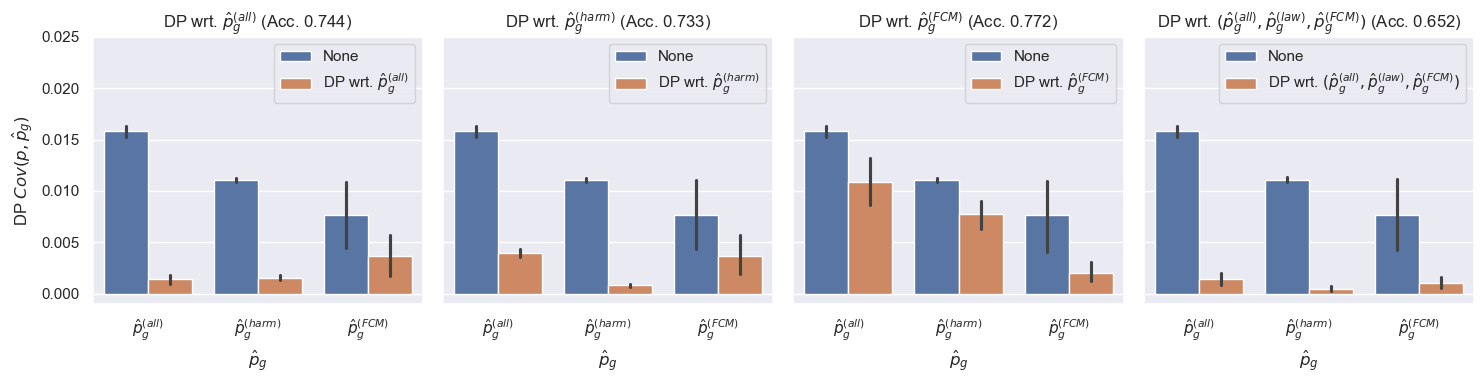

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df['intervention_pg'].value_counts().index[1:]):
    print(key)
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df['intervention_pg'].isin([key, 'None'])]
    sns.barplot(data=subplot_df, x='eval_pg', y='abs_value', hue='intervention_pg', ax=ax)
    ax.legend(title=None, loc='upper right')
    ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r'$\hat{p}_g$')
    ax.set_ylabel(r'DP $Cov(p, \hat{p}_g)$') 
    ax.set_title(f'{key} (Acc. {acc_dict[key]:.3f})')

plt.tight_layout()
plt.savefig('img/nels/dp_all_nels.pdf')

## Equal Opportunity

In [49]:
# DP Post Processing
EO_plot = [] 

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
acc_list = [] 

i = 0 
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]

    # 2) harmful stereotypes
    test_pg_clf_base = LogisticRegression() 
    test_pg_clf_base = test_pg_clf_base.fit(x_train_sub[:, feature_indices], g_train_sub)
    test_pg_clf = md.HarmfulFeaturesClassifier(base_clf=test_pg_clf_base, feature_ind=feature_indices)
    
    # 2c) clustering 
    cntr = find_means(pca.transform(x_train_sub), g_train_sub)
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)


    pg_dict = {'all_pg': all_pg_clf,
               'harm_pg': test_pg_clf,
               'cluster_pg': cluster_pg_clf}
    
    
    prev_results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=dataset.x_test, 
                            y=dataset.y_test, 
                            g=dataset.g_test)

    clfs = [
        ([all_pg_clf], r'$\hat{p}_g^{(all)}$'), 
        ([test_pg_clf], r'$\hat{p}_g^{(harm)}$'), 
        ([cluster_pg_clf], r'$\hat{p}_g^{(FCM)}$'), 
        ([all_pg_clf, test_pg_clf, cluster_pg_clf], r'$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$'),
    ]
    
    for clf_list, clf_list_name in clfs: 

        if clf_list_name == r'$\hat{p}_g^{(all)}$': 
            for key in pg_dict.keys(): 
                EO_plot.append({
                    'eval_pg': key, 
                    'intervention_pg': 'None',  
                    'value': np.abs(prev_results[f'cov(p, {key} |y=1)']), 
                    'run': i, 
                    'acc': prev_results['accuracy'], 
                })

        
        eo_clf = md.EOClf(base_clf=clf, pg_clf_list=clf_list)
        eo_clf.fit_exact(x=x_train_sub, y=y_train_sub)
    
        results = ut.results_summary(p=eo_clf.predict_proba(dataset.x_test)[:, 1], 
                                pg_dict=pg_dict, 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
        for key in pg_dict.keys(): 
            EO_plot.append({
                'eval_pg': key, 
                'intervention_pg': f'EO wrt. {clf_list_name}', 
                'value': np.abs(results[f'cov(p, {key} |y=1)']),
                'acc': results['accuracy'], 
                'run': i, 
            })

/Users/jhs/Code/stereotypes/models.py:217: RuntimeWarning: Mean of empty slice.
  bin_marginal_mean = p[mask].mean()
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jhs/Code/stereotypes/models.py:228: RuntimeWarning: Mean of empty slice.
  neg_bins += p_bin * delta * pg[mask].mean()
/Users/jhs/Code/stereotypes/models.py:217: RuntimeWarning: Mean of empty slice.
  bin_marginal_mean = p[mask].mean()
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jhs/Code/stereotypes/models.py:228: RuntimeWarning: Mean of empty slice.
  neg_bins += p_bin * delta * pg[mask].mean()
/Users/jhs/Code/stereotypes/models.py:217: RuntimeWarning: Mean of empty slice.
  bin_marginal_mean = p[mask].mean()
/Users/jhs/miniforge3/envs/mc/l

In [50]:
plot_df.to_csv('results/nels_eo_new.csv')

EO wrt. $\hat{p}_g^{(all)}$
EO wrt. $\hat{p}_g^{(harm)}$
EO wrt. $\hat{p}_g^{(FCM)}$
EO wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$


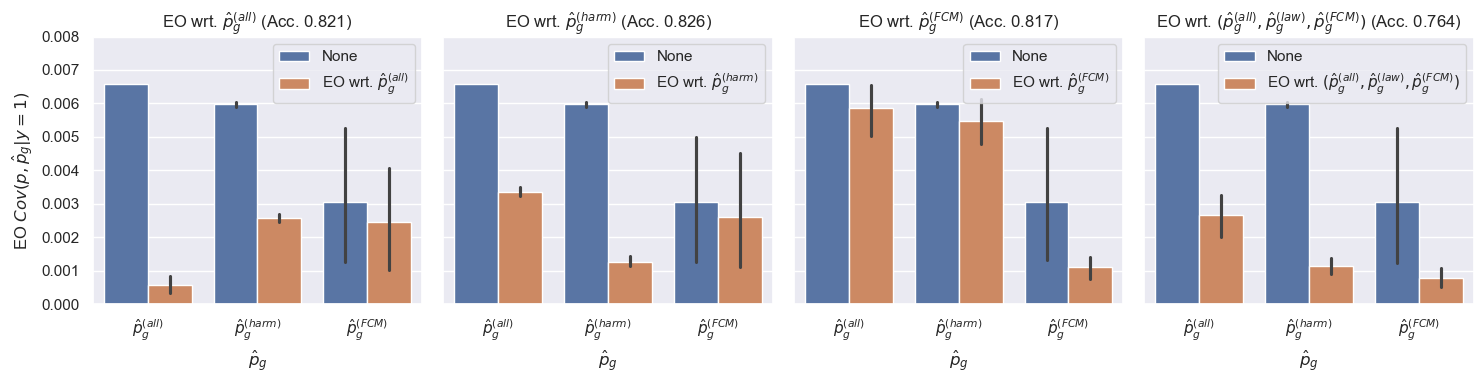

In [54]:
plot_df = pd.DataFrame(EO_plot)
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'harm_pg': r'$\hat{p}_g^{(harm)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['eval_pg'] = plot_df['eval_pg'].map(plot_map)
acc_dict=plot_df.groupby("intervention_pg")['acc'].mean().to_dict()

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df['intervention_pg'].value_counts().index[1:]):
    print(key)
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df['intervention_pg'].isin([key, 'None'])]
    sns.barplot(data=subplot_df, x='eval_pg', y='value', hue='intervention_pg', ax=ax)
    ax.legend(title=None, loc='upper right')
    ax.set_ylim(-0.00, 0.008)
    ax.set_xlabel(r'$\hat{p}_g$')
    ax.set_ylabel(r'EO $Cov(p, \hat{p}_g |y=1)$') 
    ax.set_title(f'{key} (Acc. {acc_dict[key]:.3f})')

plt.tight_layout()
plt.savefig('img/nels/eo_all_nels.pdf')

status
EO wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$    0.880211
original                                                               0.884876
Name: acc, dtype: float64


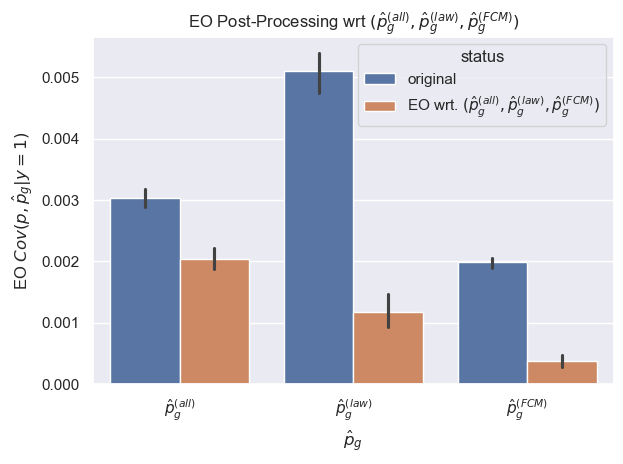

In [432]:
plot_df = pd.DataFrame(DP_plot)
print(plot_df.groupby("status")['acc'].mean())
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'occ_pg': r'$\hat{p}_g^{(law)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['pg'] = plot_df['pg'].map(plot_map)

sns.barplot(data=plot_df, x='pg', y='value', hue='status')
plt.xlabel(r'$\hat{p}_g$')
plt.ylabel(r'EO $Cov(p, \hat{p}_g | y=1)$') 
plt.title(f'EO Post-Processing wrt {clf_list_name}')
plt.tight_layout()
#plt.savefig(f'img/eo_{clf_name}.pdf')